**Titanic - Machine Learning from Disaster**

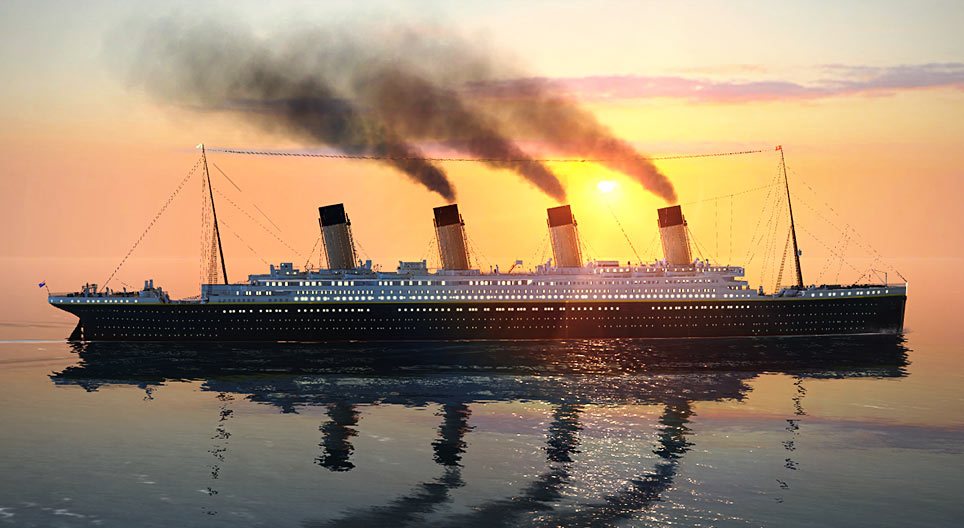

# **Tổng quan**

Bộ dữ liệu được chia thành hai nhóm:

Tập huấn luyện (train.csv)

Tập kiểm tra (test.csv)

Tập huấn luyện được dùng để xây dựng mô hình học máy. Với tập này, chúng tôi cung cấp kết quả thực (còn gọi là “ground truth”) cho từng hành khách. Mô hình của bạn sẽ dựa trên các đặc trưng (features) như giới tính và hạng vé của hành khách. Bạn cũng có thể kỹ thuật đặc trưng (feature engineering) để tạo thêm các đặc trưng mới.

Tập kiểm tra được dùng để đánh giá mô hình trên dữ liệu chưa thấy. Với tập này, chúng tôi không cung cấp ground truth cho từng hành khách. Nhiệm vụ của bạn là dự đoán kết cục của họ. Với mỗi hành khách trong tập kiểm tra, hãy dùng mô hình đã huấn luyện để dự đoán họ có sống sót sau vụ đắm tàu Titanic hay không.


# Data Preprocessing

In [1]:
#import thư viện
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
print('Train set shape:', train_df.shape)
train_df.head()

Train set shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print('Test set shape:', test_df.shape)
test_df.head()

Test set shape: (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


+ PassengerId: ID duy nhất (không có giá trị dự đoán)

+ Survived: Target variable (0/1)

+ Pclass: Hạng vé (1, 2, 3)

+ Name: Tên hành khách

+ Sex: Giới tính (male/female)

+ Age: Tuổi

+ SibSp: Số anh chị em/vợ chồng đi cùng

+ Parch: Số cha mẹ/con cái đi cùng

+ Ticket: Số vé

+ Fare: Giá vé

+ Cabin: Số cabin

+ Embarked: Cảng lên tàu (C, Q, S)

### Missing Values

In [5]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
missing_percent = train_df.isna().mean() * 100
missing_summary = pd.DataFrame({
    'Missing Values': train_df.isna().sum(),
    'Percent (%)': missing_percent
})
print(missing_summary)

             Missing Values  Percent (%)
PassengerId               0     0.000000
Survived                  0     0.000000
Pclass                    0     0.000000
Name                      0     0.000000
Sex                       0     0.000000
Age                     177    19.865320
SibSp                     0     0.000000
Parch                     0     0.000000
Ticket                    0     0.000000
Fare                      0     0.000000
Cabin                   687    77.104377
Embarked                  2     0.224467


Xử lý missing values cho Age bằng median theo Sex và Pclass

In [7]:
age_missing_pattern = train_df.groupby(['Sex', 'Pclass'])['Age'].agg(['count', 'mean', 'median'])
print(age_missing_pattern)

               count       mean  median
Sex    Pclass                          
female 1          85  34.611765    35.0
       2          74  28.722973    28.0
       3         102  21.750000    21.5
male   1         101  41.281386    40.0
       2          99  30.740707    30.0
       3         253  26.507589    25.0


In [8]:
median_age = train_df.groupby(['Sex', 'Pclass'])['Age'].median()

# train: lấp bằng median theo nhóm
train_df['Age'] = train_df.groupby(['Sex', 'Pclass'])['Age'] \
                          .transform(lambda s: s.fillna(s.median()))

# test: dùng median đã fit từ train, fallback sang median toàn cục nếu thiếu key
global_median = train_df['Age'].median()
test_df['Age'] = test_df.apply(
    lambda row: row['Age']
    if pd.notna(row['Age'])
    else median_age.get((row['Sex'], row['Pclass']), global_median),
    axis=1,
)

In [9]:
train_df['Age'].isna().sum()
test_df['Age'].isna().sum()

np.int64(0)

Xử lý missing values cho Cabin

In [10]:
train_df['Cabin'].dropna().unique()

array(['C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31',
       'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47',
       'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4',
       'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77',
       'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37',
       'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104',
       'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30',
       'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22',
       'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20',
       'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126',
       'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64',
       'E24

+ Deck lấy chữ cái đầu (boong) từ Cabin và gán 'U' cho phần thiếu (không có cabin).

+ Sau đó sẽ one-hot encode Deck thành các cột Deck_A, Deck_B, ..., Deck_U.
+ Deck_U = 1 nghĩa là hành khách không có cabin (giữ lại thông tin quan trọng này).

In [11]:
for df in (train_df, test_df):
    df['Deck'] = df['Cabin'].str[0].fillna('U')

Loại bỏ cột Cabin

In [12]:
for dataset in (train_df, test_df):
    dataset.drop(columns='Cabin', inplace=True)

In [13]:
train_df[['Deck']].head()
train_df['Deck'].value_counts()

Deck
U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64

One-hot encode Deck để chuyển nhãn chữ cái thành nhiều cột nhị phân

In [14]:
deck_cols = pd.get_dummies(train_df['Deck'], prefix='Deck')
train_df = pd.concat(
    [train_df.drop(columns=['Deck'], errors='ignore'), deck_cols],
    axis=1,
)

test_deck_cols = pd.get_dummies(test_df['Deck'], prefix='Deck')
test_deck_cols = test_deck_cols.reindex(columns=deck_cols.columns, fill_value=0)

test_df = pd.concat(
    [test_df.drop(columns=['Deck'], errors='ignore'), test_deck_cols],
    axis=1,
)

Kiểm tra lại sau khi thực hiện One-hot encode Desk

In [15]:
train_df.filter(like='Deck_').head()

,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U
0,False,False,False,False,False,False,False,False,True
1,False,False,True,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True
3,False,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,True


Xử lý missing values cho Embarked

In [16]:
most_freq_embarked = train_df['Embarked'].mode()[0]

for dataset in (train_df, test_df):
    dataset['Embarked'] = dataset['Embarked'].fillna(most_freq_embarked)


Xử lý missing values cho Fare

In [17]:
fare_by_pclass = train_df.groupby('Pclass')['Fare'].median()

mask = test_df['Fare'].isna()
test_df.loc[mask, 'Fare'] = test_df.loc[mask, 'Pclass'].map(fare_by_pclass)

# nếu nhóm Pclass không tồn tại (hiếm), fallback sang median toàn cục
test_df['Fare'] = test_df['Fare'].fillna(train_df['Fare'].median())

Kiểm tra lại giá trị bị thiếu ở 2 tập

In [18]:
missing_summary = pd.DataFrame({
    'train_missing': train_df.isna().sum(),
    'test_missing': test_df.isna().sum(),
})
missing_summary

,train_missing,test_missing
Age,0,0.0
Deck_A,0,0.0
Deck_B,0,0.0
Deck_C,0,0.0
Deck_D,0,0.0
Deck_E,0,0.0
Deck_F,0,0.0
Deck_G,0,0.0
Deck_T,0,0.0
Deck_U,0,0.0


Kiểm tra trùng lặp trong dữ liệu

In [19]:
for name, df in [("train", train_df), ("test", test_df)]:
    duplicates = df.duplicated().sum()
    print(f"Số dòng trùng lặp trong {name}: {duplicates}")

Số dòng trùng lặp trong train: 0
Số dòng trùng lặp trong test: 0


Gán biến nhị phân cho cột Sex

In [20]:
train_df['Sex'].dropna().unique()

array(['male', 'female'], dtype=object)

In [21]:
sex_map = {'male': 1, 'female': 0}

for df in (train_df, test_df):
    df['Sex'] = df['Sex'].map(sex_map).astype(int)


In [22]:
train_df['Sex'].dropna().unique()

array([1, 0])

In [23]:
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
Deck_A            bool
Deck_B            bool
Deck_C            bool
Deck_D            bool
Deck_E            bool
Deck_F            bool
Deck_G            bool
Deck_T            bool
Deck_U            bool
dtype: object

Xử lý kiểu dữ liệu cho Embarked

In [24]:
embarked_cols = pd.get_dummies(train_df['Embarked'], prefix='Embarked')
train_df = pd.concat([train_df.drop(columns='Embarked'), embarked_cols], axis=1)

test_embarked_cols = pd.get_dummies(test_df['Embarked'], prefix='Embarked')
test_embarked_cols = test_embarked_cols.reindex(columns=embarked_cols.columns, fill_value=0)
test_df = pd.concat([test_df.drop(columns='Embarked'), test_embarked_cols], axis=1)


# Exploratory Data Analysis (EDA)

Khởi tạo & chuẩn bị dữ liệu

In [25]:
raw_train = train_df.copy()
raw_test = test_df.copy()

Tổng quan dữ liệu

In [26]:
display(raw_train.info())
display(raw_train.describe(include="all"))
display(raw_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Deck_A       891 non-null    bool   
 11  Deck_B       891 non-null    bool   
 12  Deck_C       891 non-null    bool   
 13  Deck_D       891 non-null    bool   
 14  Deck_E       891 non-null    bool   
 15  Deck_F       891 non-null    bool   
 16  Deck_G       891 non-null    bool   
 17  Deck_T       891 non-null    bool   
 18  Deck_U       891 non-null    bool   
 19  Embarked

None

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U,Embarked_C,Embarked_Q,Embarked_S
count,891.000000,891.000000,891.000000,891,891.000000,891.000000,891.000000,891.000000,891,891.000000,...,891,891,891,891,891,891,891,891,891,891
unique,NaN,NaN,NaN,891,NaN,NaN,NaN,NaN,681,NaN,...,2,2,2,2,2,2,2,2,2,2
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",NaN,NaN,NaN,NaN,347082,NaN,...,False,False,False,False,False,False,True,False,False,True
freq,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,7,NaN,...,832,858,859,878,887,890,687,723,814,646
mean,446.000000,0.383838,2.308642,NaN,0.647587,29.112424,0.523008,0.381594,NaN,32.204208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,0.477990,13.304424,1.102743,0.806057,NaN,49.693429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,0.000000,0.420000,0.000000,0.000000,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,0.000000,21.500000,0.000000,0.000000,NaN,7.910400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,1.000000,26.000000,0.000000,0.000000,NaN,14.454200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,1.000000,36.000000,1.000000,0.000000,NaN,31.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    int64  
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Deck_A       418 non-null    bool   
 10  Deck_B       418 non-null    bool   
 11  Deck_C       418 non-null    bool   
 12  Deck_D       418 non-null    bool   
 13  Deck_E       418 non-null    bool   
 14  Deck_F       418 non-null    bool   
 15  Deck_G       418 non-null    bool   
 16  Deck_T       418 non-null    int64  
 17  Deck_U       418 non-null    bool   
 18  Embarked_C   418 non-null    bool   
 19  Embarked

None

**Phân bố biến mục tiêu**

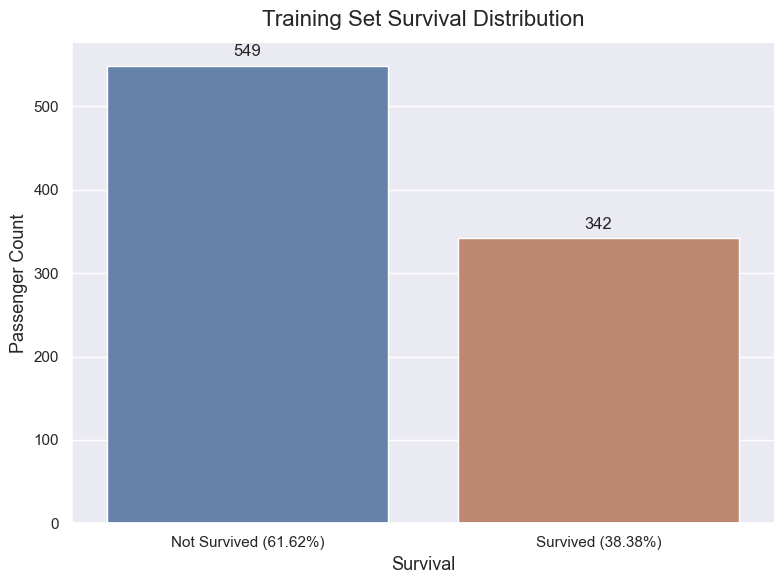

In [27]:
sns.set_theme(style="darkgrid")
counts = raw_train['Survived'].value_counts().reindex([0, 1])
labels = ['Not Survived', 'Survived']
percents = (counts / counts.sum() * 100).round(2)

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=labels, y=counts.values, palette=['#5B80B5', '#C98266'], ax=ax)

for i, (count, pct) in enumerate(zip(counts.values, percents)):
    ax.text(i, count + 8, f'{count}', ha='center', va='bottom', fontsize=12)
ax.set_xticklabels([f'{label} ({pct:.2f}%)' for label, pct in zip(labels, percents)])
ax.set_title('Training Set Survival Distribution', fontsize=16, pad=12)
ax.set_xlabel('Survival', fontsize=13)
ax.set_ylabel('Passenger Count', fontsize=13)
sns.despine()
plt.tight_layout()
plt.show()


**Tỷ lệ sống sót theo boong**

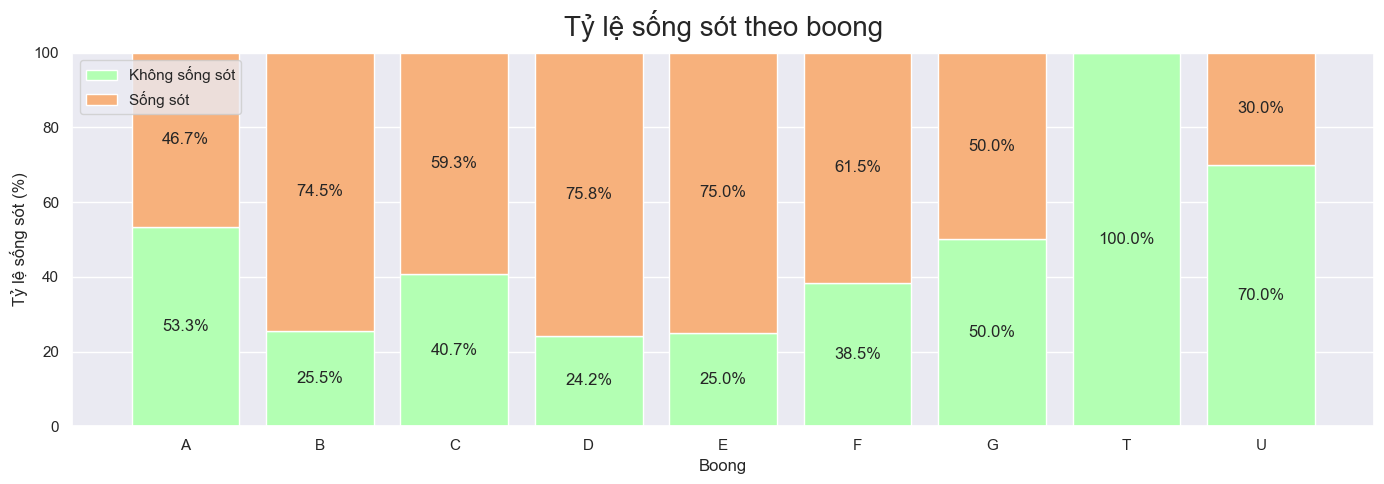

In [28]:
deck_cols = [c for c in train_df.columns if c.startswith('Deck_')]

deck_info = (
    train_df[['Survived'] + deck_cols]
    .assign(
        Deck=lambda df: df[deck_cols]
        .idxmax(axis=1)
        .str.replace('Deck_', '', regex=False)
    )
    [['Survived', 'Deck']]
)

survival_pct = (
    deck_info.groupby(['Deck', 'Survived'])
    .size()
    .unstack(fill_value=0)
    .pipe(lambda df: df.div(df.sum(axis=1), axis=0) * 100)
    .reindex(sorted(deck_info['Deck'].unique()))  
)

fig, ax = plt.subplots(figsize=(14, 5))
bottom = np.zeros(len(survival_pct))
labels = {0: 'Không sống sót', 1: 'Sống sót'}
colors = {0: '#b3ffb3', 1: '#f7b17c'}

for surv in [0, 1]:
    ax.bar(
        survival_pct.index,
        survival_pct[surv],
        bottom=bottom,
        color=colors[surv],
        edgecolor='white',
        label=labels[surv]
    )
    bottom += survival_pct[surv].values

for idx, deck in enumerate(survival_pct.index):
    not_surv = survival_pct.loc[deck, 0]
    surv = survival_pct.loc[deck, 1]
    if not_surv > 0:
        ax.text(idx, not_surv / 2, f"{not_surv:.1f}%", ha='center', va='center')
    if surv > 0:
        ax.text(idx, not_surv + surv / 2, f"{surv:.1f}%", ha='center', va='center')

ax.set_ylabel('Tỷ lệ sống sót (%)', fontsize=12)
ax.set_xlabel('Boong', fontsize=12)
ax.set_title('Tỷ lệ sống sót theo boong', fontsize=20, pad=12)
ax.set_ylim(0, 100)
ax.legend()
plt.tight_layout()
plt.show()


**Tương tác Sex × Pclass và tỷ lệ sống sót**

Mục tiêu: Xác nhận tương tác mạnh giữa giới tính và hạng vé.

Kỳ vọng: Nữ ở Pclass 1–2 sống sót rất cao; Nam ở Pclass 3 thấp nhất.

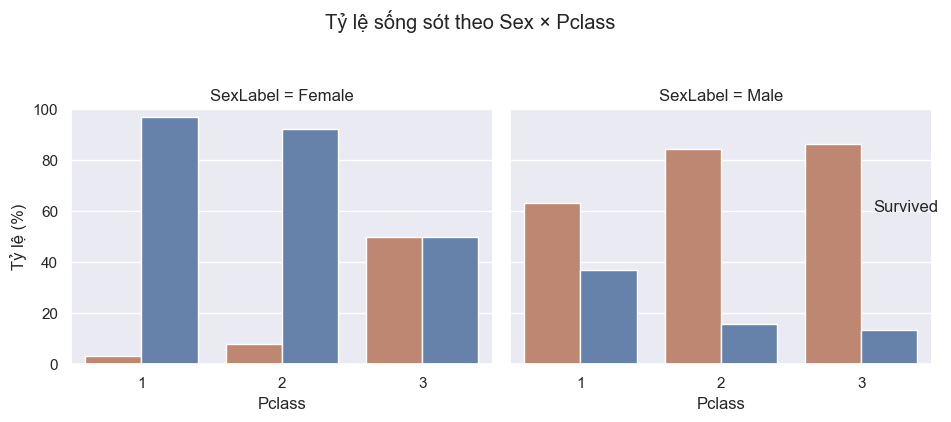

In [29]:
train_view = raw_train.copy()
train_view['SexLabel'] = train_view['Sex'].map({0: 'Female', 1: 'Male'})

ct = pd.crosstab(
    [train_view['SexLabel'], train_view['Pclass']],
    train_view['Survived'],
    normalize='index'
).mul(100)
pct = ct.reset_index().melt(
    id_vars=['SexLabel','Pclass'],
    var_name='Survived',
    value_name='pct'
)
g = sns.catplot(
    data=pct, x='Pclass', y='pct', hue='Survived', col='SexLabel',
    kind='bar', height=4, aspect=1.1, palette=['#C98266','#5B80B5'],
    legend=False
)
g.set_axis_labels('Pclass', 'Tỷ lệ (%)')
for ax in g.axes.flat:
    ax.set_ylim(0, 100)
g.add_legend(title='Survived')
plt.suptitle('Tỷ lệ sống sót theo Sex × Pclass', y=1.05)
plt.tight_layout()
plt.show()

**FarePerPerson (giá vé/người) và xác suất sống sót**

Mục tiêu: “Sức mua” sau khi điều chỉnh quy mô nhóm (FamilySize) thường mạnh hơn Fare thô.

Kỳ vọng: FarePerPerson cao → cơ hội sống sót cao, đặc biệt ở Pclass cao.

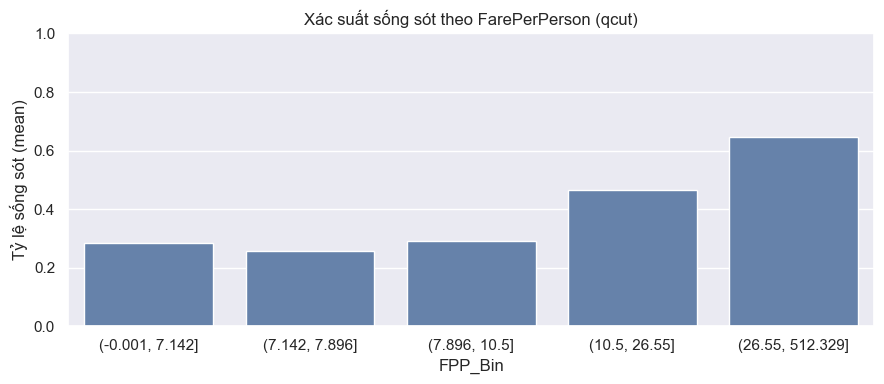

In [30]:
train_view = (raw_train
              .assign(FamilySize=lambda d: d['SibSp'] + d['Parch'] + 1)
              .assign(FarePerPerson=lambda d: d['Fare'] / d['FamilySize'].clip(lower=1))
              .loc[lambda d: d['FarePerPerson'].notna()]
              .assign(FPP_Bin=lambda d: pd.qcut(d['FarePerPerson'], q=5, duplicates='drop')))

fpp_surv = (train_view.groupby('FPP_Bin')['Survived']
            .mean().reset_index().rename(columns={'Survived':'SurvivalRate'}))

plt.figure(figsize=(9,4))
sns.barplot(data=fpp_surv, x='FPP_Bin', y='SurvivalRate', color='#5B80B5')
plt.ylim(0,1)
plt.ylabel('Tỷ lệ sống sót (mean)')
plt.title('Xác suất sống sót theo FarePerPerson (qcut)')
plt.tight_layout()
plt.show()

+ Hành khách trả nhiều tiền/người thường thuộc Pclass cao, gần boong/cửa thoát → ưu tiên cứu hộ.

+ Chia đều theo người giúp giảm nhiễu từ nhóm đi đông (Fare cao nhưng chia nhiều người → FPP thấp).

### Phân phối và ngoại lệ: Age, Fare, FamilySize

Mục tiêu: trực quan hóa phân phối và phát hiện ngoại lệ (đặc biệt là đuôi phải của Fare).
- Dùng các biến đã có sẵn trong flow (không lặp lại import).
- Histogram + KDE và boxplot cho `Age`, `Fare`, `FamilySize`.
- Kiểm tra outliers `Fare` bằng IQR và trực quan trên thang log.


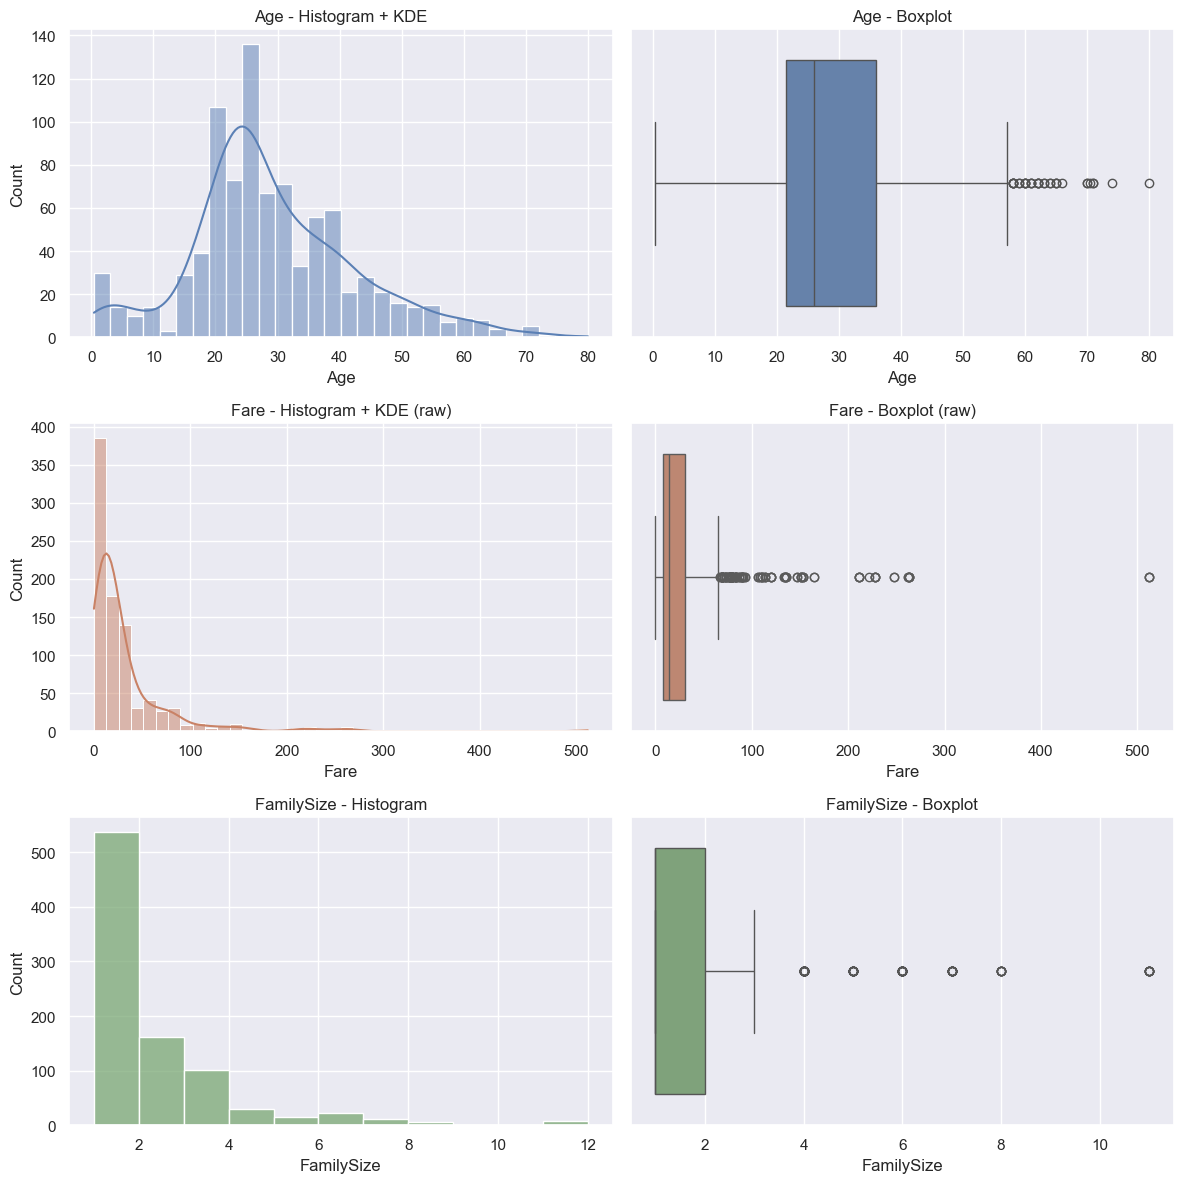

In [31]:
_df = raw_train if 'raw_train' in globals() else train_df.copy()

viz_df = (
    _df[['Age', 'Fare', 'SibSp', 'Parch']]
    .assign(FamilySize=lambda d: d['SibSp'] + d['Parch'] + 1)
)

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Age
sns.histplot(viz_df['Age'].dropna(), kde=True, bins=30, ax=axes[0, 0], color='#5B80B5')
axes[0, 0].set_title('Age - Histogram + KDE')
axes[0, 0].set_xlabel('Age')

sns.boxplot(x=viz_df['Age'], ax=axes[0, 1], color='#5B80B5')
axes[0, 1].set_title('Age - Boxplot')
axes[0, 1].set_xlabel('Age')

# Fare
sns.histplot(viz_df['Fare'].dropna(), kde=True, bins=40, ax=axes[1, 0], color='#C98266')
axes[1, 0].set_title('Fare - Histogram + KDE (raw)')
axes[1, 0].set_xlabel('Fare')

sns.boxplot(x=viz_df['Fare'], ax=axes[1, 1], color='#C98266')
axes[1, 1].set_title('Fare - Boxplot (raw)')
axes[1, 1].set_xlabel('Fare')

# FamilySize
sns.histplot(viz_df['FamilySize'], bins=range(1, int(viz_df['FamilySize'].max()) + 2), ax=axes[2, 0], color='#7AA874')
axes[2, 0].set_title('FamilySize - Histogram')
axes[2, 0].set_xlabel('FamilySize')

sns.boxplot(x=viz_df['FamilySize'], ax=axes[2, 1], color='#7AA874')
axes[2, 1].set_title('FamilySize - Boxplot')
axes[2, 1].set_xlabel('FamilySize')

plt.tight_layout()
plt.show()


+ Age

    Phân phối một đỉnh, lệch phải nhẹ; tập trung khoảng 20–35 tuổi.
    Boxplot có vài điểm xa ở hai đầu nhưng không nhiều. Không cần xử lý outlier mạnh; có thể cân nhắc binning (qcut 4–5) cho mô hình tuyến tính.
+ Fare

    Rất lệch phải, đuôi dài; nhiều outlier rõ rệt vượt xa whisker.
    Nên log-transform (log1p(Fare)) hoặc winsorize/cap theo IQR hoặc p99/p99.5. Biểu đồ gợi ý log1p sẽ ổn định phương sai.
+ FamilySize

    Lệch phải mạnh; đa số là 1–2 người, số lượng lớn gia đình rất ít nhưng bị xem là outlier.
    Tiếp tục dùng IsAlone là hợp lý; cân nhắc cap FamilySize ở 6 hoặc phân nhóm Small/Medium/Big.

# **Feature Engineering**

## **Title từ Name**

**Title** được tạo ra bằng cách trích xuất phần tiền tố (prefix) nằm trước thuộc tính Name. Theo biểu đồ dưới đây, có rất nhiều danh xưng (title) xuất hiện rất ít lần. Một số trong số đó có vẻ không chính xác và cần được thay thế.

Các danh xưng Miss, Mrs, Ms, Mlle, Lady, Mme, the Countess, Dona được thay thế bằng Miss/Mrs/Ms vì tất cả đều là nữ.
Những giá trị như Mlle, Mme và Dona thực ra là tên của hành khách, nhưng lại bị phân loại thành danh xưng vì cột Name được tách bằng dấu phẩy.

Các danh xưng Dr, Col, Major, Jonkheer, Capt, Sir, Don và Rev được thay thế tương ứng bằng Dr/Military/Noble/Clergy vì những hành khách này có đặc điểm tương tự nhau.

Master là một danh xưng đặc biệt. Nó được dùng cho nam hành khách dưới 26 tuổi. Họ có tỷ lệ sống sót cao nhất trong số tất cả nam giới.

In [32]:
title_pattern = r",\s*([^\.]+)\."

female_titles = {"Miss", "Mrs", "Ms", "Mlle", "Lady", "Mme", "the Countess", "Countess", "Dona"}
military_titles = {"Col", "Major", "Capt"}
noble_titles = {"Sir", "Don", "Jonkheer"}
clergy_titles = {"Rev"}
doctor_titles = {"Dr"}  # giữ riêng vì hành khách bác sĩ thường có đặc điểm khác

def normalize_title(raw_title):
    if pd.isna(raw_title):
        return "Unknown"
    title = raw_title.strip()
    if title in female_titles:
        return "Miss/Mrs/Ms"
    if title in military_titles:
        return "Military"
    if title in noble_titles:
        return "Noble"
    if title in clergy_titles:
        return "Clergy"
    if title in doctor_titles:
        return "Dr"
    if title == "Master":
        return "Master"
    return "Other"

for dataset in (train_df, test_df):
    extracted = dataset["Name"].str.extract(title_pattern, expand=False)
    dataset["Title"] = extracted.apply(normalize_title)


In [33]:
title_cols = pd.get_dummies(train_df["Title"], prefix="Title")
train_df = pd.concat([train_df.drop(columns="Title"), title_cols], axis=1)

test_title_cols = pd.get_dummies(test_df["Title"], prefix="Title")
test_title_cols = test_title_cols.reindex(columns=title_cols.columns, fill_value=0)
test_df = pd.concat([test_df.drop(columns="Title"), test_title_cols], axis=1)

train_df.filter(like="Title_").sum()


Title_Clergy           6
Title_Dr               7
Title_Master          40
Title_Military         5
Title_Miss/Mrs/Ms    313
Title_Noble            3
Title_Other          517
dtype: int64

## **Extract Ticket prefix và number patterns**

In [34]:
# Thêm vào sau cell 67 (trước khi xóa Name)
# Extract Ticket prefix và number patterns
def extract_ticket_info(ticket):
    if pd.isna(ticket):
        return 'NONE', 0
    ticket_str = str(ticket)
    parts = ticket_str.split()
    if len(parts) > 1:
        prefix = parts[0]
        try:
            number = int(parts[-1])
        except:
            number = 0
    else:
        prefix = 'NONE'
        try:
            number = int(ticket_str)
        except:
            number = 0
    return prefix, number

for df in [train_df, test_df]:
    ticket_info = df['Ticket'].apply(lambda x: extract_ticket_info(x))
    df['TicketPrefix'] = ticket_info.apply(lambda x: x[0])
    df['TicketNumber'] = ticket_info.apply(lambda x: x[1])
    
    # Ticket group size - số người cùng ticket
    ticket_counts = df['Ticket'].value_counts()
    df['TicketGroupSize'] = df['Ticket'].map(ticket_counts)

# One-hot encode TicketPrefix (chỉ top 5 phổ biến nhất)
common_tickets = train_df['TicketPrefix'].value_counts().head(5).index.tolist()
for df in [train_df, test_df]:
    df['TicketPrefix'] = df['TicketPrefix'].apply(lambda x: x if x in common_tickets else 'Other')

train_ticket_cols = pd.get_dummies(train_df['TicketPrefix'], prefix='Ticket')
train_df = pd.concat([train_df.drop(columns=['TicketPrefix']), train_ticket_cols], axis=1)
test_ticket_cols = pd.get_dummies(test_df['TicketPrefix'], prefix='Ticket')
test_ticket_cols = test_ticket_cols.reindex(columns=train_ticket_cols.columns, fill_value=0)
test_df = pd.concat([test_df.drop(columns=['TicketPrefix']), test_ticket_cols], axis=1)

## **Family Survival Rate**

In [35]:

# Extract surname từ Name
for df in [train_df, test_df]:
    df['Surname'] = df['Name'].str.split(',').str[0].str.strip()

# Tính Family Survival Rate trên train (chỉ cho families >= 2 người)
family_stats = train_df.groupby('Surname').agg({
    'Survived': ['mean', 'count']
}).reset_index()
family_stats.columns = ['Surname', 'FamilySurvivalRate', 'FamilyCount']
family_stats = family_stats[family_stats['FamilyCount'] >= 2]

# Merge vào train và test
train_df = train_df.merge(family_stats[['Surname', 'FamilySurvivalRate']], on='Surname', how='left')
test_df = test_df.merge(family_stats[['Surname', 'FamilySurvivalRate']], on='Surname', how='left')
train_df['FamilySurvivalRate'] = train_df['FamilySurvivalRate'].fillna(-1)
test_df['FamilySurvivalRate'] = test_df['FamilySurvivalRate'].fillna(-1)

# Sau đó drop Surname và Name

Loại bỏ cột Name

In [36]:
for dataset in (train_df, test_df):
    dataset.drop(columns='Name', inplace=True)

In [37]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E',
       'Deck_F', 'Deck_G', 'Deck_T', 'Deck_U', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Title_Clergy', 'Title_Dr', 'Title_Master',
       'Title_Military', 'Title_Miss/Mrs/Ms', 'Title_Noble', 'Title_Other',
       'TicketNumber', 'TicketGroupSize', 'Ticket_A/5', 'Ticket_C.A.',
       'Ticket_NONE', 'Ticket_Other', 'Ticket_PC', 'Ticket_STON/O', 'Surname',
       'FamilySurvivalRate'],
      dtype='object')

## **Tạo Feature Family Size**

Tổng thành viên đi chung

SibSp đếm số anh/chị/em và vợ/chồng đi cùng, Parch đếm số bố/mẹ/con. Hai cột đó chỉ cộng lại số “người thân đi cùng hành khách”. Để tính đúng quy mô gia đình trên vé, cần tính cả chính hành khách đó, vì họ cũng là một thành viên trong nhóm. Vì vậy chúng ta cộng thêm 1 để ra tổng số người trong “gia đình”/nhóm đi chung. Nếu không cộng thêm 1 thì một hành khách đi một mình sẽ có FamilySize = 0, trong khi trực giác và các nghiên cứu trước đây đều xem “một mình” là size 1.

In [38]:
for df in (train_df, test_df):
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

**Tạo thêm feature cho người đi một mình**

In [39]:
for dataset in (train_df, test_df):
    dataset['IsAlone'] = (dataset['FamilySize'] == 1).astype(int)

In [40]:
display(train_df[['FamilySize', 'IsAlone']].head())
display(test_df[['FamilySize', 'IsAlone']].head())

,FamilySize,IsAlone
0,2,0
1,2,0
2,1,1
3,2,0
4,1,1


,FamilySize,IsAlone
0,1,1
1,2,0
2,1,1
3,1,1
4,3,0


FarePerPerson: giá vé chia theo quy mô nhóm (FamilySize)

In [41]:
for df in (train_df, test_df):
    if 'FamilySize' not in df.columns:
        df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['FarePerPerson'] = df['Fare'] / df['FamilySize'].clip(lower=1)

print('Added FarePerPerson to train_df and test_df')
train_df[['Fare', 'FamilySize', 'FarePerPerson']].head()

Added FarePerPerson to train_df and test_df


,Fare,FamilySize,FarePerPerson
0,7.2500,2,3.62500
1,71.2833,2,35.64165
2,7.9250,1,7.92500
3,53.1000,2,26.55000
4,8.0500,1,8.05000


## Chuẩn bị dữ liệu và Lựa chọn đặc trưng

Phần này sẽ hướng dẫn các bước quan trọng để:
1. **Xử lý Outliers** - Loại bỏ hoặc giảm thiểu ảnh hưởng của giá trị ngoại lai
2. **Scaling/Normalization** - Chuẩn hóa dữ liệu cho các mô hình nhạy cảm với scale
3. **Feature Selection** - Lựa chọn các đặc trưng quan trọng nhất

### 1. Xử lý Outliers

**Tại sao cần xử lý outliers:**
- Outliers có thể làm méo phân phối và ảnh hưởng đến các mô hình nhạy cảm với khoảng cách (KNN, SVM, Logistic Regression)
- Fare có nhiều outliers rõ rệt (đã quan sát trong EDA)
- Age cũng có một số giá trị cực đoan

**Phương pháp:**
- **Log transformation** cho Fare (log1p để tránh log(0))
- **Winsorization** hoặc **capping** cho Age và FarePerPerson
- **IQR method** để xác định và xử lý outliers


In [42]:
# Xử lý outliers cho Fare bằng log transformation
# Log transformation giúp giảm độ lệch và ổn định phương sai

for df in (train_df, test_df):
    df['Fare_log'] = np.log1p(df['Fare'])  # log1p = log(1+x) để tránh log(0)
    
print("Đã tạo Fare_log từ Fare")
print(f"Skewness của Fare: {train_df['Fare'].skew():.2f}")
print(f"Skewness của Fare_log: {train_df['Fare_log'].skew():.2f}")

Đã tạo Fare_log từ Fare
Skewness của Fare: 4.79
Skewness của Fare_log: 0.39


In [43]:
# Xử lý outliers cho FarePerPerson bằng log transformation
for df in (train_df, test_df):
    df['FarePerPerson_log'] = np.log1p(df['FarePerPerson'])
    
print("Đã tạo FarePerPerson_log")
print(f"Skewness của FarePerPerson: {train_df['FarePerPerson'].skew():.2f}")
print(f"Skewness của FarePerPerson_log: {train_df['FarePerPerson_log'].skew():.2f}")

Đã tạo FarePerPerson_log
Skewness của FarePerPerson: 7.77
Skewness của FarePerPerson_log: 0.69


In [44]:
# Winsorization cho Age (giới hạn các giá trị cực đoan)
# Thay vì xóa outliers, chúng ta sẽ "cắt" chúng về giá trị ở percentile 1 và 99

def winsorize_column(df, col, lower=0.01, upper=0.99):
    """Winsorize một cột về percentile lower và upper"""
    lower_bound = df[col].quantile(lower)
    upper_bound = df[col].quantile(upper)
    return df[col].clip(lower=lower_bound, upper=upper_bound)

# Tạo Age_winsorized từ train_df để fit bounds
age_lower = train_df['Age'].quantile(0.01)
age_upper = train_df['Age'].quantile(0.99)

for df in (train_df, test_df):
    df['Age_winsorized'] = df['Age'].clip(lower=age_lower, upper=age_upper)

print(f"Age bounds: [{age_lower:.1f}, {age_upper:.1f}]")
print(f"Age range sau winsorization: [{train_df['Age_winsorized'].min():.1f}, {train_df['Age_winsorized'].max():.1f}]")

Age bounds: [1.0, 65.0]
Age range sau winsorization: [1.0, 65.0]


### 3. Phân tích tương quan và Feature Selection

**Mục tiêu:**
- Xác định các đặc trưng có tương quan cao với target (Survived)
- Loại bỏ các đặc trưng dư thừa (multicollinearity)
- Giảm số chiều để tránh overfitting và tăng tốc độ training


In [45]:
# Chuẩn bị dữ liệu cho phân tích
# Loại bỏ các cột không cần thiết: PassengerId, Survived (target), Ticket (đã được xử lý thành TicketNumber, TicketGroupSize, Ticket_*)
# Chỉ lấy các cột numeric và boolean để tính correlation
feature_cols = [col for col in train_df.columns 
                if col not in ['PassengerId', 'Survived', 'Ticket'] 
                and train_df[col].dtype in ['int64', 'float64', 'bool']]

# Tạo correlation matrix với target
correlation_with_target = train_df[feature_cols + ['Survived']].corr()['Survived'].sort_values(ascending=False)

print("Tương quan với Survived (giảm dần):")
for col, corr in correlation_with_target.items():
    if col != 'Survived':
        print(f"{col:30s}: {corr:6.3f}")

Tương quan với Survived (giảm dần):
Title_Miss/Mrs/Ms             :  0.541
Fare_log                      :  0.330
FarePerPerson_log             :  0.299
Fare                          :  0.257
FarePerPerson                 :  0.222
FamilySurvivalRate            :  0.216
Deck_B                        :  0.175
Embarked_C                    :  0.168
Deck_D                        :  0.151
Ticket_PC                     :  0.147
Deck_E                        :  0.145
Deck_C                        :  0.115
Title_Master                  :  0.085
Parch                         :  0.082
Deck_F                        :  0.058
TicketGroupSize               :  0.038
Ticket_C.A.                   :  0.035
Deck_A                        :  0.022
FamilySize                    :  0.017
Deck_G                        :  0.016
Title_Dr                      :  0.008
Ticket_STON/O                 :  0.008
Embarked_Q                    :  0.004
Title_Military                :  0.002
Ticket_NONE                 

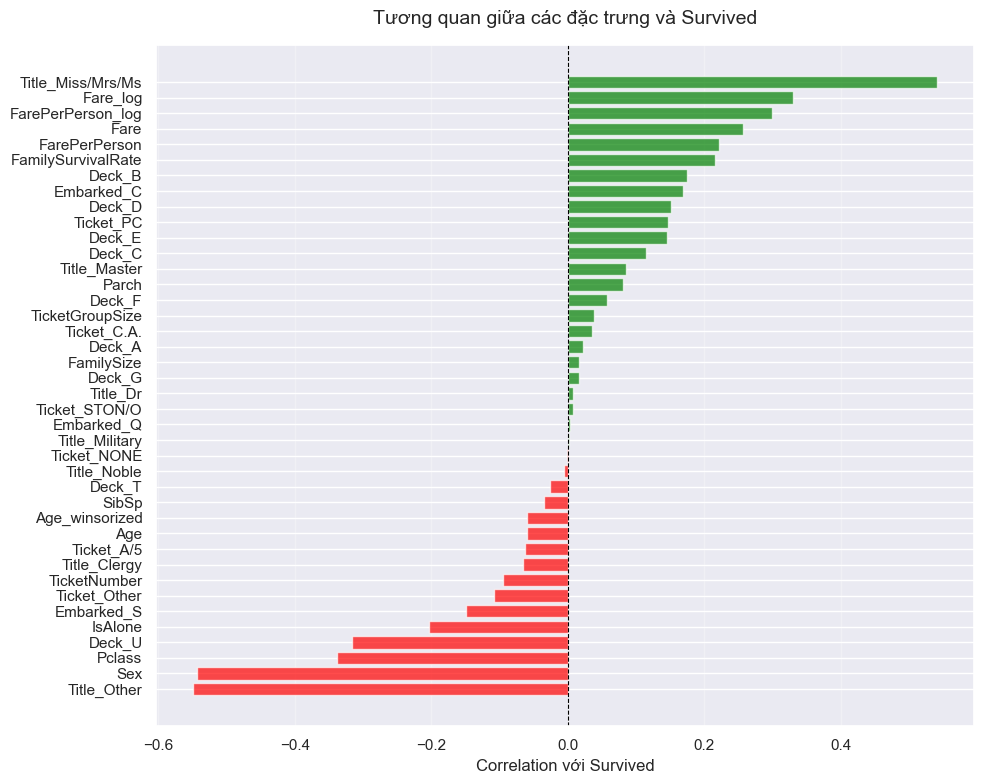


Các đặc trưng có |correlation| > 0.1 được coi là quan trọng:
Title_Other          -0.549199
Sex                  -0.543351
Title_Miss/Mrs/Ms     0.540769
Pclass               -0.338481
Fare_log              0.329862
Deck_U               -0.316912
FarePerPerson_log     0.298824
Fare                  0.257307
FarePerPerson         0.221600
FamilySurvivalRate    0.215522
IsAlone              -0.203367
Deck_B                0.175095
Embarked_C            0.168240
Deck_D                0.150716
Embarked_S           -0.149683
Ticket_PC             0.147062
Deck_E                0.145321
Deck_C                0.114652
Ticket_Other         -0.108708
Name: Survived, dtype: float64


In [46]:
# Visualize correlation matrix với target
plt.figure(figsize=(10, 8))
corr_sorted = correlation_with_target.drop('Survived').sort_values(ascending=True)
colors = ['red' if x < 0 else 'green' for x in corr_sorted.values]

plt.barh(range(len(corr_sorted)), corr_sorted.values, color=colors, alpha=0.7)
plt.yticks(range(len(corr_sorted)), corr_sorted.index)
plt.xlabel('Correlation với Survived', fontsize=12)
plt.title('Tương quan giữa các đặc trưng và Survived', fontsize=14, pad=15)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nCác đặc trưng có |correlation| > 0.1 được coi là quan trọng:")
important_features = corr_sorted[abs(corr_sorted) > 0.1]
print(important_features.sort_values(ascending=False, key=abs))


In [47]:
# Phân tích multicollinearity giữa các features
# Tính correlation matrix giữa các features (không bao gồm Survived)
feature_corr_matrix = train_df[feature_cols].corr().abs()

# Tìm các cặp features có correlation cao (> 0.8)
high_corr_pairs = []
for i in range(len(feature_corr_matrix.columns)):
    for j in range(i+1, len(feature_corr_matrix.columns)):
        corr_val = feature_corr_matrix.iloc[i, j]
        if corr_val > 0.8:
            high_corr_pairs.append((
                feature_corr_matrix.columns[i],
                feature_corr_matrix.columns[j],
                corr_val
            ))

if high_corr_pairs:
    print("Các cặp features có correlation cao (> 0.8) - có thể dư thừa:")
    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: x[2], reverse=True):
        print(f"{feat1:25s} <-> {feat2:25s}: {corr:.3f}")
else:
    print("Không có cặp features nào có correlation > 0.8")


Các cặp features có correlation cao (> 0.8) - có thể dư thừa:
Age                       <-> Age_winsorized           : 0.999
Sex                       <-> Title_Miss/Mrs/Ms        : 0.998
SibSp                     <-> FamilySize               : 0.891
Sex                       <-> Title_Other              : 0.867
Title_Miss/Mrs/Ms         <-> Title_Other              : 0.865
Fare                      <-> FarePerPerson            : 0.841
Fare_log                  <-> FarePerPerson_log        : 0.823


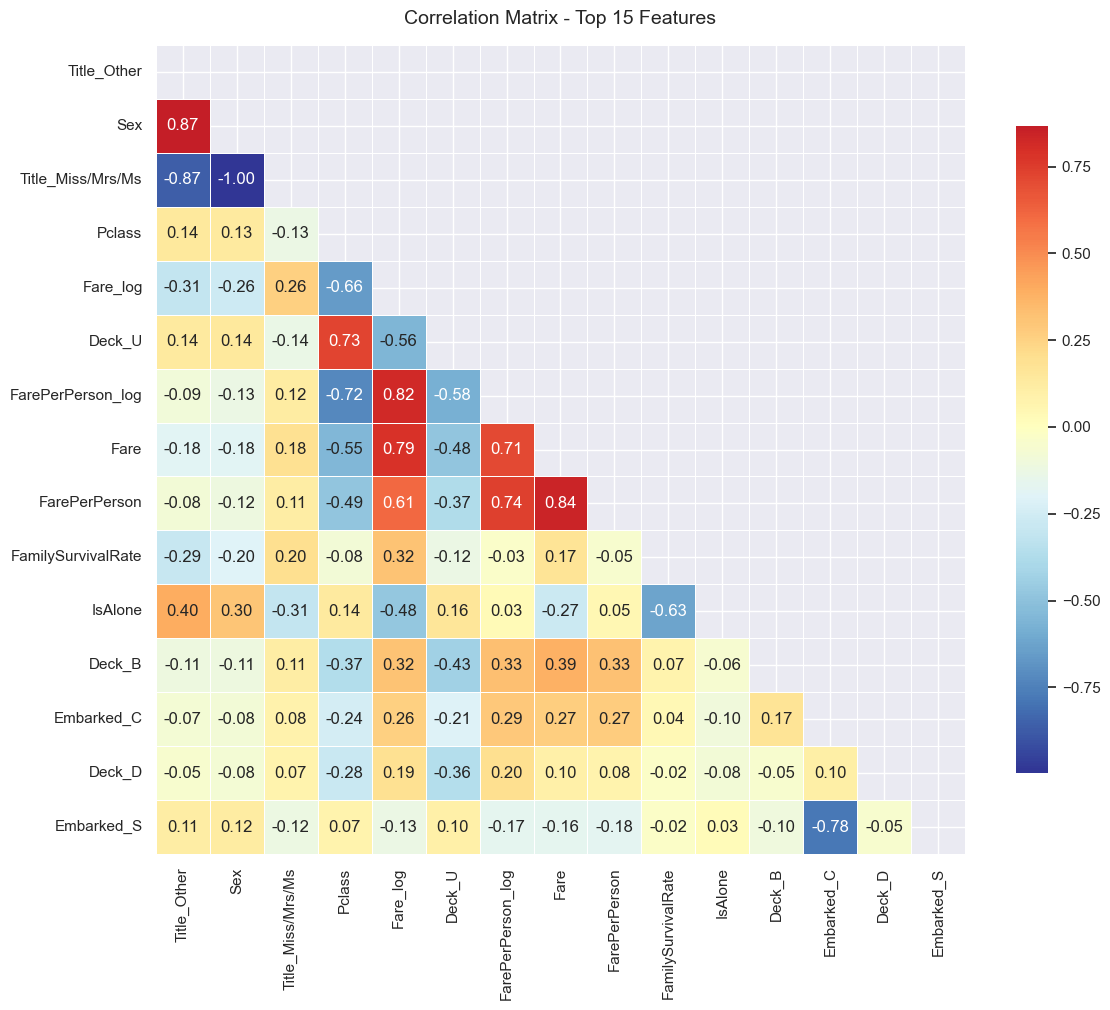

In [48]:
# Visualize correlation matrix giữa các features quan trọng
# Chọn top 15 features có correlation cao nhất với target
top_features = correlation_with_target.drop('Survived').abs().nlargest(15).index.tolist()

plt.figure(figsize=(12, 10))
corr_subset = train_df[top_features].corr()
mask = np.triu(np.ones_like(corr_subset, dtype=bool))  # Chỉ hiển thị tam giác dưới

sns.heatmap(corr_subset, 
            mask=mask,
            annot=True, 
            fmt='.2f', 
            cmap='RdYlBu_r',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Top 15 Features', fontsize=14, pad=15)
plt.tight_layout()
plt.show()


### 4. Feature Selection bằng Machine Learning

Sử dụng các phương pháp ML-based để chọn features:
1. **Univariate Feature Selection** (SelectKBest với chi2 hoặc f_classif)
2. **Tree-based Feature Importance** (Random Forest, XGBoost)
3. **Recursive Feature Elimination (RFE)** với cross-validation


In [49]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score

# Chuẩn bị dữ liệu
X = train_df[feature_cols].copy()
y = train_df['Survived'].copy()

# Chuyển đổi boolean columns thành int để tính toán
X = X.astype(float)

print(f"Số lượng features ban đầu: {X.shape[1]}")
print(f"Số lượng samples: {X.shape[0]}")

Số lượng features ban đầu: 40
Số lượng samples: 891


In [50]:
# Method 1: Univariate Feature Selection với f_classif (ANOVA F-test)
selector_f = SelectKBest(score_func=f_classif, k='all')
selector_f.fit(X, y)

feature_scores_f = pd.DataFrame({
    'Feature': feature_cols,
    'Score': selector_f.scores_
}).sort_values('Score', ascending=False)

print("Top 20 features theo Univariate Selection (f_classif):")
print(feature_scores_f.head(20).to_string(index=False))

Top 20 features theo Univariate Selection (f_classif):
           Feature      Score
       Title_Other 383.945495
               Sex 372.405724
 Title_Miss/Mrs/Ms 367.414594
            Pclass 115.031272
          Fare_log 108.541519
            Deck_U  99.253142
 FarePerPerson_log  87.167879
              Fare  63.030764
     FarePerPerson  45.910184
FamilySurvivalRate  43.305389
           IsAlone  38.353651
            Deck_B  28.117228
        Embarked_C  25.895987
            Deck_D  20.663186
        Embarked_S  20.374460
         Ticket_PC  19.651485
            Deck_E  19.179221
            Deck_C  11.841661
      Ticket_Other  10.631276
      TicketNumber   8.200774


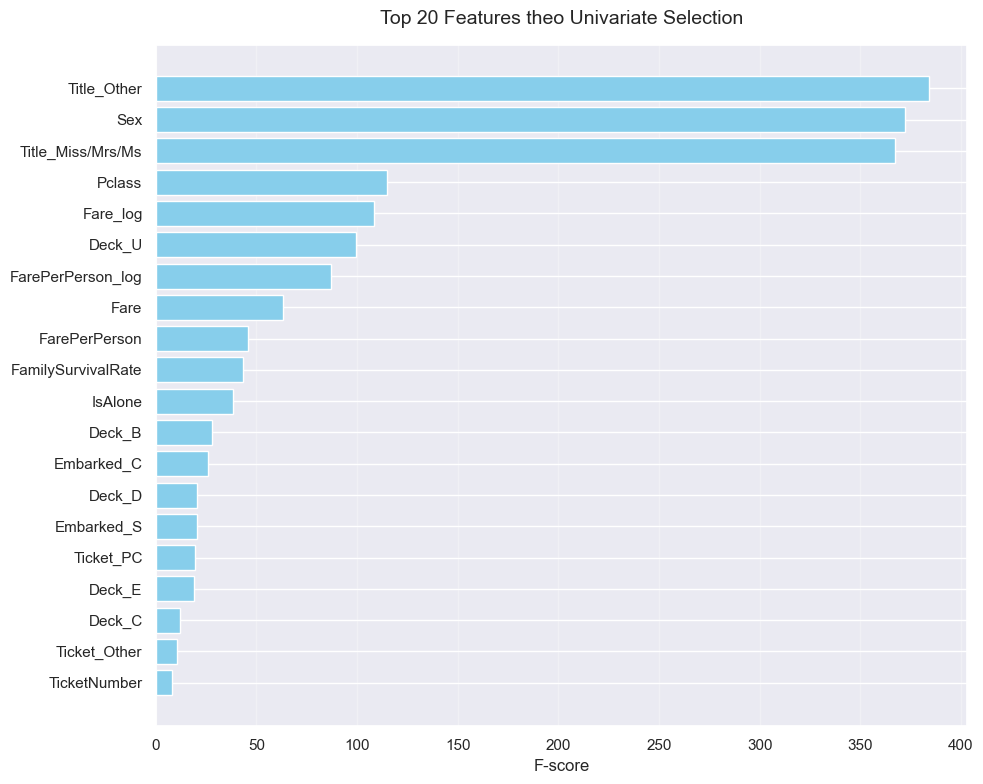

In [51]:
# Visualize feature scores
plt.figure(figsize=(10, 8))
top_n = 20
top_features_f = feature_scores_f.head(top_n)
plt.barh(range(len(top_features_f)), top_features_f['Score'].values, color='skyblue')
plt.yticks(range(len(top_features_f)), top_features_f['Feature'].values)
plt.xlabel('F-score', fontsize=12)
plt.title(f'Top {top_n} Features theo Univariate Selection', fontsize=14, pad=15)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [52]:
# Method 2: Tree-based Feature Importance (Random Forest)
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf.fit(X, y)

feature_importance_rf = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 20 features theo Random Forest Importance:")
print(feature_importance_rf.head(20).to_string(index=False))

Top 20 features theo Random Forest Importance:
           Feature  Importance
       Title_Other    0.134652
FamilySurvivalRate    0.114673
               Sex    0.092219
 Title_Miss/Mrs/Ms    0.082864
      TicketNumber    0.069609
     FarePerPerson    0.058244
 FarePerPerson_log    0.055554
          Fare_log    0.054764
    Age_winsorized    0.053345
               Age    0.053113
              Fare    0.047216
            Pclass    0.029442
   TicketGroupSize    0.026363
        FamilySize    0.023506
             SibSp    0.013745
            Deck_U    0.013206
        Embarked_S    0.007556
             Parch    0.007223
       Ticket_NONE    0.006577
      Title_Master    0.006316


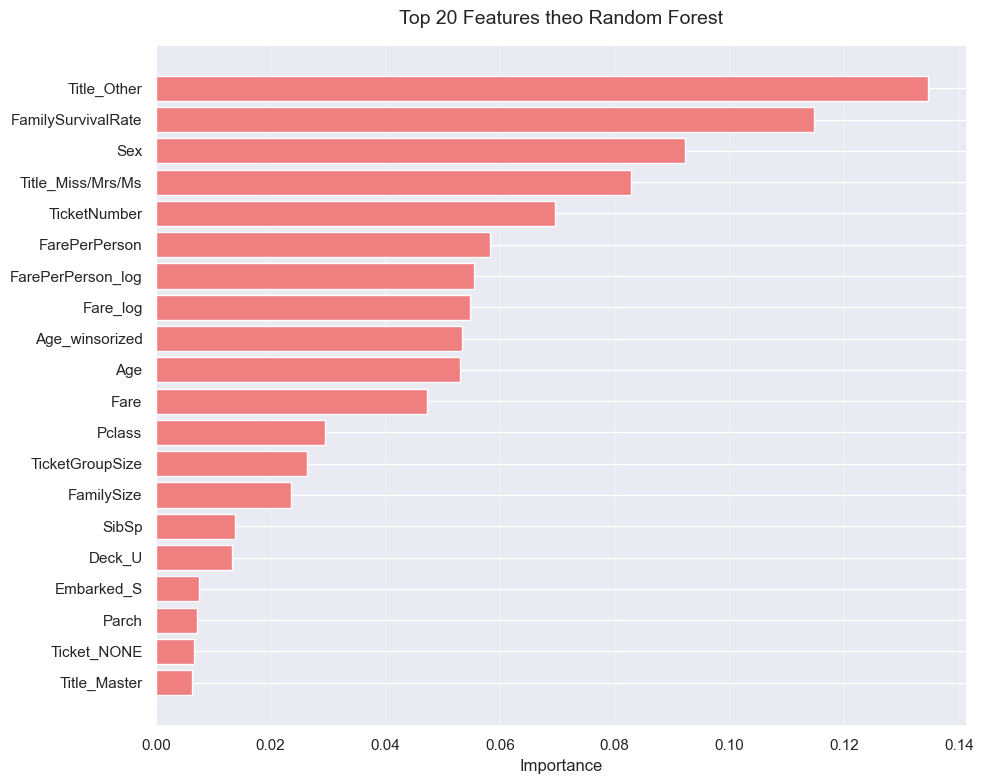

In [53]:
# Visualize Random Forest feature importance
plt.figure(figsize=(10, 8))
top_n = 20
top_features_rf = feature_importance_rf.head(top_n)
plt.barh(range(len(top_features_rf)), top_features_rf['Importance'].values, color='lightcoral')
plt.yticks(range(len(top_features_rf)), top_features_rf['Feature'].values)
plt.xlabel('Importance', fontsize=12)
plt.title(f'Top {top_n} Features theo Random Forest', fontsize=14, pad=15)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [54]:
# Method 3: Recursive Feature Elimination (RFE) với Random Forest
# RFE loại bỏ từng feature và đánh giá performance
rfe_rf = RFE(estimator=RandomForestClassifier(n_estimators=50, random_state=42, max_depth=10), 
             n_features_to_select=20,  # Chọn top 20 features
             step=1)
rfe_rf.fit(X, y)

feature_ranking_rfe = pd.DataFrame({
    'Feature': feature_cols,
    'RFE_Ranking': rfe_rf.ranking_,
    'Selected': rfe_rf.support_
}).sort_values('RFE_Ranking')

print("Top features được chọn bởi RFE:")
selected_features_rfe = feature_ranking_rfe[feature_ranking_rfe['Selected'] == True]
print(selected_features_rfe[['Feature', 'RFE_Ranking']].to_string(index=False))

Top features được chọn bởi RFE:
           Feature  RFE_Ranking
            Pclass            1
               Sex            1
               Age            1
             SibSp            1
             Parch            1
              Fare            1
            Deck_U            1
        Embarked_S            1
      Ticket_Other            1
       Title_Other            1
   TicketGroupSize            1
       Ticket_NONE            1
 Title_Miss/Mrs/Ms            1
      TicketNumber            1
        FamilySize            1
FamilySurvivalRate            1
     FarePerPerson            1
          Fare_log            1
    Age_winsorized            1
 FarePerPerson_log            1


In [55]:
# So sánh kết quả từ 3 phương pháp
# Tạo một bảng tổng hợp điểm số của từng feature

comparison_df = pd.DataFrame({
    'Feature': feature_cols,
    'Correlation': [correlation_with_target[f] for f in feature_cols],
    'Univariate_Score': [selector_f.scores_[i] for i, f in enumerate(feature_cols)],
    'RF_Importance': rf.feature_importances_,
    'RFE_Selected': rfe_rf.support_
})

# Normalize scores để so sánh (0-1 scale)
comparison_df['Univariate_Norm'] = (comparison_df['Univariate_Score'] - comparison_df['Univariate_Score'].min()) / \
                                    (comparison_df['Univariate_Score'].max() - comparison_df['Univariate_Score'].min() + 1e-10)
comparison_df['RF_Norm'] = (comparison_df['RF_Importance'] - comparison_df['RF_Importance'].min()) / \
                           (comparison_df['RF_Importance'].max() - comparison_df['RF_Importance'].min() + 1e-10)
comparison_df['Correlation_Abs'] = comparison_df['Correlation'].abs()

# Tính điểm tổng hợp (weighted average)
comparison_df['Combined_Score'] = (
    comparison_df['Correlation_Abs'] * 0.3 +
    comparison_df['Univariate_Norm'] * 0.3 +
    comparison_df['RF_Norm'] * 0.4
)

comparison_df = comparison_df.sort_values('Combined_Score', ascending=False)

print("Top 25 features theo điểm tổng hợp (Correlation + Univariate + RF):")
display(comparison_df[['Feature', 'Correlation', 'RF_Importance', 'RFE_Selected', 'Combined_Score']].head(25))


Top 25 features theo điểm tổng hợp (Correlation + Univariate + RF):


,Feature,Correlation,RF_Importance,RFE_Selected,Combined_Score
24,Title_Other,-0.549199,0.134652,True,0.864760
1,Sex,-0.543351,0.092219,True,0.727891
22,Title_Miss/Mrs/Ms,0.540769,0.082864,True,0.695414
33,FamilySurvivalRate,0.215522,0.114673,True,0.439122
37,Fare_log,0.329862,0.054764,True,0.346366
38,FarePerPerson_log,0.298824,0.055554,True,0.322699
0,Pclass,-0.338481,0.029442,True,0.278770
36,FarePerPerson,0.221600,0.058244,True,0.275289
5,Fare,0.257307,0.047216,True,0.266607
25,TicketNumber,-0.095605,0.069609,True,0.241800


### 5. Xác định tập features cuối cùng

Dựa trên phân tích trên, chúng ta sẽ chọn các features:
1. **Có correlation cao với target** (|correlation| > 0.1)
2. **Được đánh giá cao bởi ML methods** (Univariate, RF)
3. **Không có multicollinearity cao** (loại bỏ một trong các cặp có correlation > 0.8)
4. **Domain knowledge** (Sex, Pclass, Age là quan trọng)


In [56]:
# Lấy top features từ combined score
top_n_features = 25
selected_by_score = comparison_df.head(top_n_features)['Feature'].tolist()


features_to_remove = []
if 'Fare' in selected_by_score and 'Fare_log' in selected_by_score:
    features_to_remove.append('Fare')
if 'FarePerPerson' in selected_by_score and 'FarePerPerson_log' in selected_by_score:
    features_to_remove.append('FarePerPerson')
if 'Age' in selected_by_score and 'Age_winsorized' in selected_by_score:
    features_to_remove.append('Age')

# Loại bỏ các features dư thừa
final_features = [f for f in selected_by_score if f not in features_to_remove]

# Đảm bảo các features quan trọng nhất luôn được bao gồm (nếu chưa có)
essential_features = ['Sex', 'Pclass', 'Age_winsorized', 'Fare_log']
for feat in essential_features:
    if feat not in final_features and feat in feature_cols:
        final_features.append(feat)

print(f"\nTổng số features được chọn: {len(final_features)}")
print("\nDanh sách features cuối cùng:")
for i, feat in enumerate(final_features, 1):
    print(f"{i:2d}. {feat}")


Tổng số features được chọn: 22

Danh sách features cuối cùng:
 1. Title_Other
 2. Sex
 3. Title_Miss/Mrs/Ms
 4. FamilySurvivalRate
 5. Fare_log
 6. FarePerPerson_log
 7. Pclass
 8. TicketNumber
 9. Deck_U
10. Age_winsorized
11. IsAlone
12. TicketGroupSize
13. Embarked_C
14. Embarked_S
15. Deck_B
16. FamilySize
17. Deck_D
18. Deck_E
19. Ticket_PC
20. Ticket_Other
21. Deck_C
22. SibSp


## Chia tập dữ liệu thành Train/Validation/Test

**Mục đích:**
- **Train set**: Huấn luyện mô hình
- **Validation set**: Điều chỉnh hyperparameters và chọn mô hình tốt nhất
- **Test set**: Đánh giá cuối cùng trên dữ liệu chưa thấy

**Lưu ý quan trọng:**
- Tập `test.csv` ban đầu từ Kaggle không có labels, chỉ dùng để submission
- Chúng ta sẽ chia tập `train_df` (891 mẫu) thành 3 tập để phát triển mô hình
- Tỷ lệ chia thường dùng: 60% train, 20% validation, 20% test
- Sử dụng **stratified split** để đảm bảo phân bố của target được giữ nguyên trong cả 3 tập


In [57]:
from sklearn.model_selection import train_test_split

# Chuẩn bị dữ liệu với features đã chọn
X_final = train_df[final_features].copy()
y_final = train_df['Survived'].copy()

# Chuyển đổi boolean columns thành int (nếu cần)
X_final = X_final.astype(float)

print(f"Tổng số mẫu: {len(X_final)}")
print(f"Tổng số features: {len(final_features)}")
print(f"\nPhân bố target trong tập gốc:")
print(y_final.value_counts().sort_index())
print(f"\nTỷ lệ:")
print(y_final.value_counts(normalize=True).sort_index())

Tổng số mẫu: 891
Tổng số features: 22

Phân bố target trong tập gốc:
Survived
0    549
1    342
Name: count, dtype: int64

Tỷ lệ:
Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


In [58]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X_final, y_final, 
    test_size=0.2,           # 20% cho test set
    random_state=42,         
    stratify=y_final         
)

# Chia phần còn lại thành train và validation (60%/20% )
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,          
    random_state=42,
    stratify=y_temp
)
print("Kích thước các tập sau khi chia:")
print(f"Train set:      {X_train.shape[0]:4d} mẫu ({X_train.shape[0]/len(X_final)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:4d} mẫu ({X_val.shape[0]/len(X_final)*100:.1f}%)")
print(f"Test set:       {X_test.shape[0]:4d} mẫu ({X_test.shape[0]/len(X_final)*100:.1f}%)")
print(f"Tổng:           {len(X_final):4d} mẫu")

Kích thước các tập sau khi chia:
Train set:       534 mẫu (59.9%)
Validation set:  178 mẫu (20.0%)
Test set:        179 mẫu (20.1%)
Tổng:            891 mẫu


In [59]:
# Kiểm tra phân bố target trong từng tập
print("\nPhân bố target trong các tập:")
print("-" * 60)

for name, y_set in [("Train", y_train), ("Validation", y_val), ("Test", y_test)]:
    counts = y_set.value_counts().sort_index()
    proportions = y_set.value_counts(normalize=True).sort_index()
    print(f"\n{name} set:")
    print(f"  Sống sót (1): {counts.get(1, 0):4d} ({proportions.get(1, 0)*100:5.2f}%)")
    print(f"  Tử vong (0):   {counts.get(0, 0):4d} ({proportions.get(0, 0)*100:5.2f}%)")
    print(f"  Tổng:          {len(y_set):4d}")

print("Phân bố target được giữ nguyên nhờ stratified split")


Phân bố target trong các tập:
------------------------------------------------------------

Train set:
  Sống sót (1):  205 (38.39%)
  Tử vong (0):    329 (61.61%)
  Tổng:           534

Validation set:
  Sống sót (1):   68 (38.20%)
  Tử vong (0):    110 (61.80%)
  Tổng:           178

Test set:
  Sống sót (1):   69 (38.55%)
  Tử vong (0):    110 (61.45%)
  Tổng:           179
Phân bố target được giữ nguyên nhờ stratified split


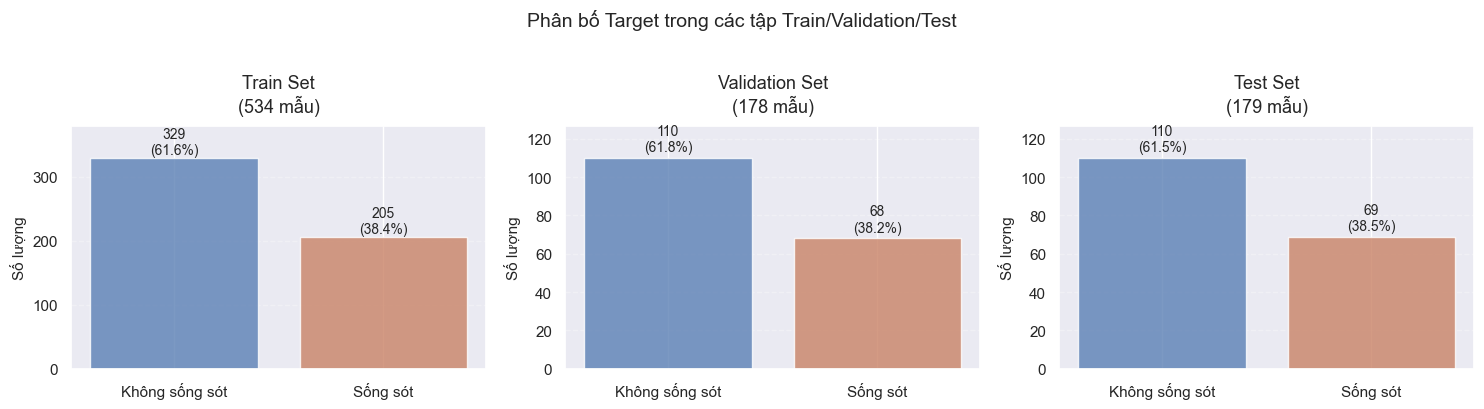

In [60]:
# Visualize phân bố target trong các tập
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (name, y_set, ax) in enumerate(zip(["Train", "Validation", "Test"], 
                                              [y_train, y_val, y_test], 
                                              axes)):
    counts = y_set.value_counts().reindex([0, 1], fill_value=0)
    labels = ['Không sống sót', 'Sống sót']
    colors = ['#5B80B5', '#C98266']
    
    bars = ax.bar(labels, counts.values, color=colors, alpha=0.8)
    ax.set_title(f'{name} Set\n({len(y_set)} mẫu)', fontsize=13, pad=10)
    ax.set_ylabel('Số lượng', fontsize=11)
    
    # Thêm nhãn số lượng và phần trăm
    total = counts.sum()
    for i, (bar, count) in enumerate(zip(bars, counts.values)):
        height = bar.get_height()
        pct = (count / total * 100) if total > 0 else 0
        ax.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{int(count)}\n({pct:.1f}%)',
                ha='center', va='bottom', fontsize=10)
    
    ax.set_ylim(0, max(counts.values) * 1.15)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.suptitle('Phân bố Target trong các tập Train/Validation/Test', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

**Lưu ý:**
- Tập `test_df` ban đầu (418 mẫu) từ Kaggle sẽ được giữ lại để tạo submission file sau khi đã chọn mô hình tốt nhất
- Chúng ta sẽ dùng `X_test` và `y_test` để đánh giá mô hình cuối cùng trước khi submit
- Thứ tự sử dụng:
  1. **Train set**: Huấn luyện mô hình
  2. **Validation set**: Điều chỉnh hyperparameters
  3. **Test set**: Đánh giá cuối cùng
  4. **Kaggle test set**: Tạo submission file


# Model Training

In [61]:
# Tiện ích đánh giá mô hình
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier



def evaluate_model(trained_model, X_eval, y_eval, model_name="model"):
    y_pred = trained_model.predict(X_eval)
    y_proba = None
    try:
        y_proba = trained_model.predict_proba(X_eval)[:, 1]
    except Exception:
        try:
            # một số mô hình có decision_function
            scores = trained_model.decision_function(X_eval)
            # scale về [0,1] gần đúng để tính ROC-AUC
            y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)
        except Exception:
            y_proba = None

    metrics = {
        "model": model_name,
        "accuracy": accuracy_score(y_eval, y_pred),
        "precision": precision_score(y_eval, y_pred),
        "recall": recall_score(y_eval, y_pred),
        "f1": f1_score(y_eval, y_pred),
        "roc_auc": roc_auc_score(y_eval, y_proba) if y_proba is not None else np.nan,
    }
    return metrics


def cv_score(model, X, y, scoring="accuracy", n_splits=5, random_state=42):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=None)
    return scores.mean(), scores.std()


In [62]:
# Tạo bản sao dữ liệu để đảm bảo dùng đúng splits đã tạo ở trên
X_tr, y_tr = X_train.copy(), y_train.copy()
X_vl, y_vl = X_val.copy(), y_val.copy()
X_ts, y_ts = X_test.copy(), y_test.copy()

# 1) Logistic Regression
logreg = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=200, random_state=42)
scaler = StandardScaler()
X_tr_lr = scaler.fit_transform(X_tr)
X_vl_lr = scaler.transform(X_vl)
X_ts_lr = scaler.transform(X_ts)

# 2) Random Forest
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
)

# 3) Gradient Boosting
gb = GradientBoostingClassifier(
    n_estimators=250,
    learning_rate=0.05,
    max_depth=3,
    subsample=1.0,
    random_state=42,
)

# 4) XGBoostClassifier
xgb = XGBClassifier(
    n_estimators=250,
    learning_rate=0.05,
    max_depth=3,
    subsample=1.0,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=1,
    use_label_encoder=False,
    eval_metric='logloss', 
    random_state=42,
)

# Cross-validation (accuracy) trên Train cho từng mô hình
lr_cv_mean, lr_cv_std = cv_score(LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=200, random_state=42),
                                 X_tr_lr, y_tr, scoring='accuracy', n_splits=5)
rf_cv_mean, rf_cv_std = cv_score(rf, X_tr, y_tr, scoring='accuracy', n_splits=5)
gb_cv_mean, gb_cv_std = cv_score(gb, X_tr, y_tr, scoring='accuracy', n_splits=5)
xgb_cv_mean, xgb_cv_std = cv_score(xgb, X_tr, y_tr, scoring='accuracy', n_splits=5)


print("CV Accuracy (mean ± std) trên Train:")
print(f"- LogisticRegression: {lr_cv_mean:.4f} ± {lr_cv_std:.4f}")
print(f"- RandomForest     : {rf_cv_mean:.4f} ± {rf_cv_std:.4f}")
print(f"- GradientBoosting : {gb_cv_mean:.4f} ± {gb_cv_std:.4f}")
print(f"- XGBoost          : {xgb_cv_mean:.4f} ± {xgb_cv_std:.4f}")
# Fit trên Train và đánh giá trên Validation
logreg.fit(X_tr_lr, y_tr)
rf.fit(X_tr, y_tr)
gb.fit(X_tr, y_tr)
xgb.fit(X_tr, y_tr)

# Đánh giá trên Training set
train_results = []
train_results.append(evaluate_model(logreg, X_tr_lr, y_tr, model_name='LogisticRegression'))
train_results.append(evaluate_model(rf, X_tr, y_tr, model_name='RandomForest'))
train_results.append(evaluate_model(gb, X_tr, y_tr, model_name='GradientBoosting'))
train_results.append(evaluate_model(xgb, X_tr, y_tr, model_name='XGBoost'))

train_results_df = pd.DataFrame(train_results).sort_values(['f1','accuracy','roc_auc'], ascending=False)
print("\nKết quả Training (sắp xếp theo F1, rồi Accuracy, ROC-AUC):")
display(train_results_df)

val_results = []
val_results.append(evaluate_model(logreg, X_vl_lr, y_vl, model_name='LogisticRegression'))
val_results.append(evaluate_model(rf, X_vl, y_vl, model_name='RandomForest'))
val_results.append(evaluate_model(gb, X_vl, y_vl, model_name='GradientBoosting'))
val_results.append(evaluate_model(xgb, X_vl, y_vl, model_name='XGBoost'))

val_df = pd.DataFrame(val_results).sort_values(['f1','accuracy','roc_auc'], ascending=False)
print("\nKết quả Validation (sắp xếp theo F1, rồi Accuracy, ROC-AUC):")
display(val_df)


CV Accuracy (mean ± std) trên Train:
- LogisticRegression: 0.8240 ± 0.0416
- RandomForest     : 0.8633 ± 0.0274
- GradientBoosting : 0.8689 ± 0.0464
- XGBoost          : 0.8726 ± 0.0351

Kết quả Training (sắp xếp theo F1, rồi Accuracy, ROC-AUC):


,model,accuracy,precision,recall,f1,roc_auc
1,RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000
2,GradientBoosting,0.955056,0.959391,0.921951,0.940299,0.995048
3,XGBoost,0.936330,0.947644,0.882927,0.914141,0.985707
0,LogisticRegression,0.850187,0.804878,0.804878,0.804878,0.892120



Kết quả Validation (sắp xếp theo F1, rồi Accuracy, ROC-AUC):


,model,accuracy,precision,recall,f1,roc_auc
2,GradientBoosting,0.865169,0.843750,0.794118,0.818182,0.930080
1,RandomForest,0.853933,0.800000,0.823529,0.811594,0.909492
3,XGBoost,0.848315,0.815385,0.779412,0.796992,0.926003
0,LogisticRegression,0.820225,0.772727,0.750000,0.761194,0.856150


In [63]:
# Đánh giá trên tập Test cho 3 mô hình và chọn mô hình tốt nhất theo F1

test_results = []
test_results.append(evaluate_model(logreg, X_ts_lr, y_ts, model_name='LogisticRegression'))
test_results.append(evaluate_model(rf, X_ts, y_ts, model_name='RandomForest'))
test_results.append(evaluate_model(gb, X_ts, y_ts, model_name='GradientBoosting'))
test_results.append(evaluate_model(xgb, X_ts, y_ts, model_name='XGBoost'))

test_metrics_df = pd.DataFrame(test_results).sort_values(['f1','accuracy','roc_auc'], ascending=False)
print("Kết quả Test (sắp xếp theo F1, rồi Accuracy, ROC-AUC):")
display(test_metrics_df)

best_name = test_metrics_df.iloc[0]['model']
print(f"\nMô hình tốt nhất trên Test: {best_name}")

best_model = {
    'LogisticRegression': logreg,
    'RandomForest': rf,
    'GradientBoosting': gb,
    'XGBoost': xgb,
}[best_name]

Kết quả Test (sắp xếp theo F1, rồi Accuracy, ROC-AUC):


,model,accuracy,precision,recall,f1,roc_auc
3,XGBoost,0.849162,0.838710,0.753623,0.793893,0.872003
2,GradientBoosting,0.832402,0.774648,0.797101,0.785714,0.863307
1,RandomForest,0.826816,0.787879,0.753623,0.770370,0.863439
0,LogisticRegression,0.776536,0.704225,0.724638,0.714286,0.844005



Mô hình tốt nhất trên Test: XGBoost


Huấn luyện lại mô hình tốt nhất

In [64]:
# Ghép Train + Validation
X_train_full = pd.concat([X_tr, X_vl], axis=0)
y_train_full = pd.concat([y_tr, y_vl], axis=0)

from sklearn.pipeline import Pipeline

final_model = None
if best_name == 'LogisticRegression':
    final_model = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=200, random_state=42)),
    ])
elif best_name == 'RandomForest':
    final_model = RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=42,
    )
elif best_name == 'GradientBoosting':
    final_model = GradientBoostingClassifier(
        n_estimators=250,
        learning_rate=0.05,
        max_depth=3,
        subsample=1.0,
        random_state=42,
    )
elif best_name == 'XGBoost':
    final_model = XGBClassifier(
        n_estimators=250,
        learning_rate=0.05,
        max_depth=3,
        subsample=1.0,
        colsample_bytree=1,
        reg_alpha=0,
        reg_lambda=1,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
    )
else:
    raise ValueError(f"best_name không hợp lệ: {best_name}")

# Fit trên Train+Validation
final_model.fit(X_train_full, y_train_full)

train_metrics = evaluate_model(final_model, X_train_full, y_train_full, model_name=best_name)
test_metrics = evaluate_model(final_model, X_ts, y_ts, model_name=best_name)

print("Kết quả trên Train+Validation:")
display(pd.DataFrame([train_metrics]))
print("\nKết quả trên Test:")
display(pd.DataFrame([test_metrics]))

Kết quả trên Train+Validation:


,model,accuracy,precision,recall,f1,roc_auc
0,XGBoost,0.924157,0.92278,0.875458,0.898496,0.977584



Kết quả trên Test:


,model,accuracy,precision,recall,f1,roc_auc
0,XGBoost,0.843575,0.825397,0.753623,0.787879,0.883663


## Hyperparameter Tuning - XGBoost

Tối ưu hyperparameters cho XGBoost để đạt kết quả tốt hơn:
- Sử dụng `GridSearchCV` với `StratifiedKFold`
- Tham số quét: `n_estimators`, `max_depth`, `learning_rate`, `subsample`, `colsample_bytree`
- Tiêu chí: refit theo `f1`


In [ ]:
# ==== Imports (bổ sung) ====
import numpy as np
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import (
    f1_score, roc_auc_score, accuracy_score, precision_score,
    recall_score, precision_recall_curve
)
from sklearn.model_selection import StratifiedKFold

print("="*70)
print("TINH CHỈNH XGBOOST + THRESHOLD TUNING (Optuna)")
print("="*70)

# ==== Helper ====
def best_threshold_for_f1(y_true, y_proba):
    # Dùng PR-curve để quét ngưỡng tối ưu F1
    p, r, thres = precision_recall_curve(y_true, y_proba)
    # precision_recall_curve trả về len(thres) = len(p) - 1
    f1s = (2 * p[:-1] * r[:-1]) / (p[:-1] + r[:-1] + 1e-12)
    i = np.argmax(f1s)
    return float(thres[i]), float(f1s[i])

def evaluate_model(y_true, y_pred, y_proba=None, model_name="Model"):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
    }
    if y_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_proba)
    print(f"=== {model_name} ===")
    print(f"Accuracy: {metrics['accuracy']:.4f} | Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f} | F1: {metrics['f1']:.4f}")
    if y_proba is not None:
        print(f"ROC-AUC: {metrics['roc_auc']:.4f}")
    return metrics

# Ước lượng imbalance để set khung search cho scale_pos_weight
pos = int(np.sum(y_tr))
neg = int(len(y_tr) - pos)
base_spw = (neg / max(pos, 1)) if pos > 0 else 1.0  # phòng hờ chia 0

def objective(trial):
    # ---- Search space tối ưu dựa trên LEARNING CURVE (VERSION 3 - CÂN BẰNG)
    # Phân tích kết quả:
    # - Version 1: 79.18% Kaggle (good) nhưng có overfitting (gap lớn)
    # - Version 2: 74.88% Kaggle (BAD) - regularization QUÁ MỨC → underfitting
    # → CẦN CÂN BẰNG: Giữ được performance tốt nhưng giảm overfitting vừa phải
    # Chiến lược: Giữ những điều tốt từ V1, điều chỉnh regularization nhẹ nhàng
    params = {
        # Giữ n_estimators hợp lý: validation loss min ở 80-100, nhưng không quá nhỏ
        'n_estimators':        trial.suggest_int('n_estimators', 100, 400),
        # Learning rate ổn định
        'learning_rate':       trial.suggest_float('learning_rate', 0.03, 0.12, log=True),
        # max_depth: giữ ở mức trung bình, không quá nông cũng không quá sâu
        'max_depth':           trial.suggest_int('max_depth', 4, 7),
        # min_child_weight: tăng nhẹ so với V1, nhưng không quá như V2
        'min_child_weight':    trial.suggest_float('min_child_weight', 2.0, 8.0),
        # gamma: giữ ở mức trung bình
        'gamma':               trial.suggest_float('gamma', 0.5, 2.5),
        # subsample: không giảm quá nhiều như V2
        'subsample':           trial.suggest_float('subsample', 0.7, 0.95),
        # colsample_bytree: giữ ở mức tốt
        'colsample_bytree':    trial.suggest_float('colsample_bytree', 0.65, 0.9),
        'colsample_bynode':    trial.suggest_float('colsample_bynode', 0.5, 0.9),
        # REGULARIZATION CÂN BẰNG: tăng so với V1 nhưng không quá như V2
        # V1: 0.001-2.0 (quá nhỏ) → V2: 0.01-5.0 (quá lớn) → V3: 0.005-1.5 (cân bằng)
        'reg_alpha':           trial.suggest_float('reg_alpha', 0.005, 1.5, log=True),
        'reg_lambda':          trial.suggest_float('reg_lambda', 0.005, 1.5, log=True),
        'max_delta_step':      trial.suggest_int('max_delta_step', 0, 10),
        'max_bin':             trial.suggest_int('max_bin', 128, 512),
        'grow_policy':         trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'sampling_method':     'uniform',
        'scale_pos_weight':    trial.suggest_float('scale_pos_weight', max(0.5*base_spw, 0.5), 2.0*base_spw),
        # Các thông số cố định
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist'
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X_tr, y_tr)):
        X_tr_f, X_va_f = X_tr.iloc[tr_idx], X_tr.iloc[va_idx]
        y_tr_f, y_va_f = y_tr.iloc[tr_idx], y_tr.iloc[va_idx]

        # Early stopping cân bằng: phù hợp với n_estimators 100-400
        clf = XGBClassifier(**params, early_stopping_rounds=60)
        clf.fit(
            X_tr_f, y_tr_f,
            eval_set=[(X_va_f, y_va_f)],
            verbose=False
        )

        va_proba = clf.predict_proba(X_va_f)[:, 1]
        thres, f1_fold = best_threshold_for_f1(y_va_f, va_proba)
        # dùng ngưỡng tối ưu theo fold để tính F1 fold
        va_pred = (va_proba >= thres).astype(int)
        f1_scores.append(f1_score(y_va_f, va_pred))

        # báo cáo cho pruner
        trial.report(np.mean(f1_scores), fold)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return float(np.mean(f1_scores))

study = optuna.create_study(
    direction='maximize',
    # Tinh chỉnh pruner: tăng n_warmup_steps để đánh giá tốt hơn trước khi prune
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=3, interval_steps=1),
    study_name='XGB_F1_Optuna_V3_Balanced'
)

# Số lượng trials phù hợp với search space mới
n_trials = 200
print(f"\nTrials: {n_trials} | CV: 5-fold | Optimize: F1 (threshold-tuned) | EarlyStopping: aucpr")
print("="*70)
print("SEARCH SPACE V3 - CÂN BẰNG (Từ kinh nghiệm V1 và V2):")
print("  📊 Kết quả: V1=79.18%, V2=74.88% → V3 tìm điểm cân bằng")
print("  - n_estimators: [100-400] (không quá nhỏ như V2)")
print("  - max_depth: [4-7] (cân bằng, không quá nông)")
print("  - reg_alpha/lambda: [0.005-1.5] (tăng nhẹ so với V1, không quá như V2)")
print("  - min_child_weight: [2.0-8.0] (tăng nhẹ so với V1)")
print("  - subsample: [0.7-0.95] (không giảm quá nhiều như V2)")
print("="*70)
print()
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

print("\n" + "="*70)
print("KẾT QUẢ TUNING (CV theo F1 với threshold):")
print("="*70)
print(f"Best F1 (CV): {study.best_value:.4f}\n")
print("Best Params:")
for k, v in sorted(study.best_params.items()):
    print(f"  {k:22s}: {v}")

# ---- Train full TRAIN rồi đánh giá VALID/TEST với threshold tối ưu trên VALID
best_params = study.best_params.copy()
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'random_state': 42,
    'n_jobs': -1,
    'tree_method': 'hist'
})

print("\n" + "="*70)
print("HUẤN LUYỆN MÔ HÌNH TỐT NHẤT & TỐI ƯU THRESHOLD TRÊN VALID")
print("="*70)

# Early stopping cân bằng: phù hợp với n_estimators 100-400
best_xgb = XGBClassifier(**best_params, early_stopping_rounds=80)
best_xgb.fit(
    X_tr, y_tr,
    eval_set=[(X_vl, y_vl)],
    verbose=False
)

# --- VALID: tối ưu threshold theo F1 rồi chấm điểm
vl_proba = best_xgb.predict_proba(X_vl)[:, 1]
best_thres, vl_best_f1 = best_threshold_for_f1(y_vl, vl_proba)
vl_pred = (vl_proba >= best_thres).astype(int)
print(f"Best threshold on VALID (for F1): {best_thres:.4f} | F1: {vl_best_f1:.4f}")
_ = evaluate_model(y_vl, vl_pred, vl_proba, "Optimized XGB (VALID, tuned thr)")

print("\n" + "="*70)
# --- TEST: dùng đúng threshold đã tối ưu trên VALID
ts_proba = best_xgb.predict_proba(X_ts)[:, 1]
ts_pred = (ts_proba >= best_thres).astype(int)
_ = evaluate_model(y_ts, ts_pred, ts_proba, "Optimized XGB (TEST, thr from VALID)")
print("="*70)


[I 2025-11-02 17:10:31,192] A new study created in memory with name: XGB_F1_Optuna_V2_Strong_Regularization


TINH CHỈNH XGBOOST + THRESHOLD TUNING (Optuna)

Trials: 200 | CV: 5-fold | Optimize: F1 (threshold-tuned) | EarlyStopping: aucpr
SEARCH SPACE TỐI ƯU V2 - TĂNG REGULARIZATION MẠNH:
  - n_estimators: [80-300] (validation loss min ở 80-100 rounds)
  - max_depth: [3-6] (giảm độ phức tạp)
  - reg_alpha/lambda: [0.01-5.0] (tăng regularization mạnh)
  - min_child_weight: [3.0-12.0] (tăng regularization)
  - subsample: [0.6-0.9] (giảm để tăng regularization)



Best trial: 0. Best value: 0.851764:   0%|          | 1/200 [00:00<01:11,  2.77it/s]

[I 2025-11-02 17:10:31,552] Trial 0 finished with value: 0.851764171458019 and parameters: {'n_estimators': 169, 'learning_rate': 0.0697692158631906, 'max_depth': 4, 'min_child_weight': 9.179650602116688, 'gamma': 2.6085424497954213, 'subsample': 0.7449374689346303, 'colsample_bytree': 0.6904575825850583, 'colsample_bynode': 0.5153126622476825, 'reg_alpha': 3.194236944639213, 'reg_lambda': 0.03934805928816244, 'max_delta_step': 10, 'max_bin': 338, 'grow_policy': 'lossguide', 'scale_pos_weight': 3.039647417018312}. Best is trial 0 with value: 0.851764171458019.


Best trial: 0. Best value: 0.851764:   1%|          | 2/200 [00:00<01:21,  2.44it/s]

[I 2025-11-02 17:10:31,997] Trial 1 finished with value: 0.8506051954928415 and parameters: {'n_estimators': 288, 'learning_rate': 0.062047711706722526, 'max_depth': 4, 'min_child_weight': 9.948364697801125, 'gamma': 1.0850424258245648, 'subsample': 0.8028971107950557, 'colsample_bytree': 0.760576433878846, 'colsample_bynode': 0.6639789175704206, 'reg_alpha': 1.2265895937175944, 'reg_lambda': 3.2097470049962493, 'max_delta_step': 7, 'max_bin': 476, 'grow_policy': 'lossguide', 'scale_pos_weight': 2.237570985858837}. Best is trial 0 with value: 0.851764171458019.


Best trial: 2. Best value: 0.863263:   2%|▏         | 3/200 [00:01<01:09,  2.83it/s]

[I 2025-11-02 17:10:32,282] Trial 2 finished with value: 0.8632631132783641 and parameters: {'n_estimators': 114, 'learning_rate': 0.10724217817364634, 'max_depth': 3, 'min_child_weight': 7.537871476835678, 'gamma': 1.4378477732508328, 'subsample': 0.7905714426410371, 'colsample_bytree': 0.7972666626763009, 'colsample_bynode': 0.5045129312523493, 'reg_alpha': 0.022990559116532985, 'reg_lambda': 0.3443878626453719, 'max_delta_step': 6, 'max_bin': 252, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.9862359151974855}. Best is trial 2 with value: 0.8632631132783641.


Best trial: 2. Best value: 0.863263:   2%|▏         | 4/200 [00:01<01:06,  2.96it/s]

[I 2025-11-02 17:10:32,597] Trial 3 finished with value: 0.8565427888948642 and parameters: {'n_estimators': 96, 'learning_rate': 0.0817935866891719, 'max_depth': 5, 'min_child_weight': 6.917705715510211, 'gamma': 1.3498896336086756, 'subsample': 0.6628275443644586, 'colsample_bytree': 0.8409413775657639, 'colsample_bynode': 0.7599773594226258, 'reg_alpha': 0.03491530442750091, 'reg_lambda': 0.013258989990417728, 'max_delta_step': 7, 'max_bin': 335, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.9389091730750614}. Best is trial 2 with value: 0.8632631132783641.


Best trial: 2. Best value: 0.863263:   2%|▎         | 5/200 [00:01<01:05,  2.99it/s]

[I 2025-11-02 17:10:32,925] Trial 4 finished with value: 0.8343915425591868 and parameters: {'n_estimators': 106, 'learning_rate': 0.032686886075165365, 'max_depth': 6, 'min_child_weight': 7.591515402484638, 'gamma': 0.9280493323868795, 'subsample': 0.6997132062823298, 'colsample_bytree': 0.726523959048528, 'colsample_bynode': 0.5760551783283934, 'reg_alpha': 0.29573835259257797, 'reg_lambda': 1.34872795459654, 'max_delta_step': 3, 'max_bin': 425, 'grow_policy': 'lossguide', 'scale_pos_weight': 1.1953591721514494}. Best is trial 2 with value: 0.8632631132783641.


Best trial: 2. Best value: 0.863263:   3%|▎         | 6/200 [00:01<00:58,  3.33it/s]

[I 2025-11-02 17:10:33,161] Trial 5 finished with value: 0.8477967047961134 and parameters: {'n_estimators': 83, 'learning_rate': 0.10840034795133222, 'max_depth': 6, 'min_child_weight': 6.380056214723281, 'gamma': 2.8724919493589165, 'subsample': 0.6289288961403006, 'colsample_bytree': 0.8456488533592755, 'colsample_bynode': 0.7355656199199508, 'reg_alpha': 0.46484699275572955, 'reg_lambda': 3.82871901856843, 'max_delta_step': 6, 'max_bin': 194, 'grow_policy': 'lossguide', 'scale_pos_weight': 1.360650722056517}. Best is trial 2 with value: 0.8632631132783641.


Best trial: 6. Best value: 0.863577:   4%|▎         | 7/200 [00:02<00:59,  3.24it/s]

[I 2025-11-02 17:10:33,484] Trial 6 finished with value: 0.8635769587866882 and parameters: {'n_estimators': 125, 'learning_rate': 0.05890094865249712, 'max_depth': 4, 'min_child_weight': 8.132358088260533, 'gamma': 2.3774672856983443, 'subsample': 0.8325971503876205, 'colsample_bytree': 0.6688870347548012, 'colsample_bynode': 0.8038168144520157, 'reg_alpha': 0.06134615627884128, 'reg_lambda': 0.07430523225711118, 'max_delta_step': 10, 'max_bin': 249, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.9839753604438037}. Best is trial 6 with value: 0.8635769587866882.


Best trial: 7. Best value: 0.864448:   4%|▍         | 8/200 [00:02<01:04,  3.00it/s]

[I 2025-11-02 17:10:33,872] Trial 7 finished with value: 0.8644480094319382 and parameters: {'n_estimators': 228, 'learning_rate': 0.08172556568980725, 'max_depth': 3, 'min_child_weight': 4.720927836824453, 'gamma': 1.270285178721315, 'subsample': 0.8960758460624182, 'colsample_bytree': 0.787069336767163, 'colsample_bynode': 0.7684558388217542, 'reg_alpha': 0.06074763515891934, 'reg_lambda': 0.060627334070392586, 'max_delta_step': 2, 'max_bin': 277, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.6801707309232201}. Best is trial 7 with value: 0.8644480094319382.


Best trial: 7. Best value: 0.864448:   4%|▍         | 9/200 [00:03<01:09,  2.75it/s]

[I 2025-11-02 17:10:34,301] Trial 8 finished with value: 0.8619621968371582 and parameters: {'n_estimators': 129, 'learning_rate': 0.042769753180451786, 'max_depth': 6, 'min_child_weight': 3.2641897039973897, 'gamma': 2.6389148805129037, 'subsample': 0.7332807622689242, 'colsample_bytree': 0.722469958396071, 'colsample_bynode': 0.7432214220805444, 'reg_alpha': 0.02723091364435725, 'reg_lambda': 2.0660321713105376, 'max_delta_step': 9, 'max_bin': 195, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.9657339635632773}. Best is trial 7 with value: 0.8644480094319382.


Best trial: 7. Best value: 0.864448:   5%|▌         | 10/200 [00:03<01:08,  2.79it/s]

[I 2025-11-02 17:10:34,648] Trial 9 finished with value: 0.8538489658489657 and parameters: {'n_estimators': 293, 'learning_rate': 0.05585812786903822, 'max_depth': 3, 'min_child_weight': 9.352985307278622, 'gamma': 1.2449251059164663, 'subsample': 0.8813838241657944, 'colsample_bytree': 0.6092973198840834, 'colsample_bynode': 0.8321173225363192, 'reg_alpha': 0.03188191614745029, 'reg_lambda': 1.0605130568535097, 'max_delta_step': 7, 'max_bin': 158, 'grow_policy': 'lossguide', 'scale_pos_weight': 2.4511904095930506}. Best is trial 7 with value: 0.8644480094319382.


Best trial: 7. Best value: 0.864448:   6%|▌         | 11/200 [00:03<01:06,  2.84it/s]

[I 2025-11-02 17:10:34,985] Trial 10 finished with value: 0.8566777595072168 and parameters: {'n_estimators': 230, 'learning_rate': 0.08229432852957314, 'max_depth': 3, 'min_child_weight': 4.084889732965014, 'gamma': 2.032756606700755, 'subsample': 0.8931778397087509, 'colsample_bytree': 0.7819763912675469, 'colsample_bynode': 0.652514562104549, 'reg_alpha': 0.10917121400126996, 'reg_lambda': 0.13480528866645125, 'max_delta_step': 0, 'max_bin': 394, 'grow_policy': 'depthwise', 'scale_pos_weight': 0.8835551716392758}. Best is trial 7 with value: 0.8644480094319382.


Best trial: 11. Best value: 0.864994:   6%|▌         | 12/200 [00:04<01:05,  2.86it/s]

[I 2025-11-02 17:10:35,329] Trial 11 finished with value: 0.8649941729319688 and parameters: {'n_estimators': 222, 'learning_rate': 0.04885312908090454, 'max_depth': 4, 'min_child_weight': 5.166048189356143, 'gamma': 1.9549614256238994, 'subsample': 0.8408358032436516, 'colsample_bytree': 0.6383884099345905, 'colsample_bynode': 0.8205087559679489, 'reg_alpha': 0.11107598791663728, 'reg_lambda': 0.07852462382370044, 'max_delta_step': 3, 'max_bin': 280, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.6422909437233688}. Best is trial 11 with value: 0.8649941729319688.


Best trial: 11. Best value: 0.864994:   6%|▋         | 13/200 [00:04<01:06,  2.79it/s]

[I 2025-11-02 17:10:35,707] Trial 12 finished with value: 0.8577665544332211 and parameters: {'n_estimators': 216, 'learning_rate': 0.044974047433622474, 'max_depth': 5, 'min_child_weight': 5.095108052463866, 'gamma': 1.7976103322767119, 'subsample': 0.8494848954003132, 'colsample_bytree': 0.6161958831277605, 'colsample_bynode': 0.8379194191592358, 'reg_alpha': 0.010517463696178819, 'reg_lambda': 0.025394879785102138, 'max_delta_step': 3, 'max_bin': 275, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.6477544208854475}. Best is trial 11 with value: 0.8649941729319688.


Best trial: 11. Best value: 0.864994:   7%|▋         | 14/200 [00:04<01:13,  2.53it/s]

[I 2025-11-02 17:10:36,187] Trial 13 finished with value: 0.8627048260381593 and parameters: {'n_estimators': 249, 'learning_rate': 0.0424287223842017, 'max_depth': 3, 'min_child_weight': 5.295515120867662, 'gamma': 0.5116298409741928, 'subsample': 0.8518430953882656, 'colsample_bytree': 0.6531901565196357, 'colsample_bynode': 0.7791866441189862, 'reg_alpha': 0.10740720954605092, 'reg_lambda': 0.3163854217718557, 'max_delta_step': 2, 'max_bin': 302, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.5905681603227806}. Best is trial 11 with value: 0.8649941729319688.


Best trial: 11. Best value: 0.864994:   8%|▊         | 15/200 [00:05<01:11,  2.60it/s]

[I 2025-11-02 17:10:36,545] Trial 14 finished with value: 0.8581910875918366 and parameters: {'n_estimators': 180, 'learning_rate': 0.0868357366885021, 'max_depth': 4, 'min_child_weight': 5.338989290628009, 'gamma': 1.9857564088437203, 'subsample': 0.7928527490037939, 'colsample_bytree': 0.8032817930563922, 'colsample_bynode': 0.6995212567228238, 'reg_alpha': 0.15396958624150223, 'reg_lambda': 0.10391562932257262, 'max_delta_step': 0, 'max_bin': 383, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.510761958303241}. Best is trial 11 with value: 0.8649941729319688.


Best trial: 11. Best value: 0.864994:   8%|▊         | 16/200 [00:05<01:14,  2.48it/s]

[I 2025-11-02 17:10:36,993] Trial 15 finished with value: 0.8586756453423119 and parameters: {'n_estimators': 260, 'learning_rate': 0.049166271505489405, 'max_depth': 5, 'min_child_weight': 3.1850657809546314, 'gamma': 0.6942497136824369, 'subsample': 0.8904109345830262, 'colsample_bytree': 0.7385175473579322, 'colsample_bynode': 0.7087431909096072, 'reg_alpha': 0.5934508089936532, 'reg_lambda': 0.04028174743510119, 'max_delta_step': 2, 'max_bin': 225, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.6908024316805594}. Best is trial 11 with value: 0.8649941729319688.


Best trial: 11. Best value: 0.864994:   8%|▊         | 17/200 [00:06<01:12,  2.53it/s]

[I 2025-11-02 17:10:37,370] Trial 16 finished with value: 0.8311996384518439 and parameters: {'n_estimators': 202, 'learning_rate': 0.03281308726468836, 'max_depth': 3, 'min_child_weight': 11.37742735738058, 'gamma': 1.5941828060272167, 'subsample': 0.8241943623332488, 'colsample_bytree': 0.6982559696854505, 'colsample_bynode': 0.7966327276483272, 'reg_alpha': 0.07249321630008204, 'reg_lambda': 0.2054351661671944, 'max_delta_step': 4, 'max_bin': 332, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.1455063333467892}. Best is trial 11 with value: 0.8649941729319688.


Best trial: 11. Best value: 0.864994:   9%|▉         | 18/200 [00:06<01:08,  2.65it/s]

[I 2025-11-02 17:10:37,704] Trial 17 finished with value: 0.8564310040746822 and parameters: {'n_estimators': 151, 'learning_rate': 0.07127062922878237, 'max_depth': 4, 'min_child_weight': 4.461787201038289, 'gamma': 2.1679863225551257, 'subsample': 0.8693132735622714, 'colsample_bytree': 0.6432104976281057, 'colsample_bynode': 0.6178045054722123, 'reg_alpha': 0.2702448513040933, 'reg_lambda': 0.011609444352340854, 'max_delta_step': 1, 'max_bin': 138, 'grow_policy': 'depthwise', 'scale_pos_weight': 0.831032078325816}. Best is trial 11 with value: 0.8649941729319688.


Best trial: 11. Best value: 0.864994:  10%|▉         | 19/200 [00:06<01:04,  2.82it/s]

[I 2025-11-02 17:10:38,007] Trial 18 finished with value: 0.8610036876703543 and parameters: {'n_estimators': 253, 'learning_rate': 0.0929962265483996, 'max_depth': 3, 'min_child_weight': 6.203415085598159, 'gamma': 1.7308267279183869, 'subsample': 0.7767494534655062, 'colsample_bytree': 0.7618516081030668, 'colsample_bynode': 0.8386330772262667, 'reg_alpha': 1.0974004327169653, 'reg_lambda': 0.06001432438171713, 'max_delta_step': 4, 'max_bin': 290, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.4273156870560457}. Best is trial 11 with value: 0.8649941729319688.


Best trial: 19. Best value: 0.867046:  10%|█         | 20/200 [00:07<01:08,  2.62it/s]

[I 2025-11-02 17:10:38,448] Trial 19 finished with value: 0.8670456267753641 and parameters: {'n_estimators': 229, 'learning_rate': 0.051645099538508744, 'max_depth': 4, 'min_child_weight': 4.146746595335347, 'gamma': 0.9419477560782108, 'subsample': 0.8243030599780096, 'colsample_bytree': 0.8170861248626062, 'colsample_bynode': 0.7973608595596555, 'reg_alpha': 0.05656418339457813, 'reg_lambda': 0.02264038939027985, 'max_delta_step': 2, 'max_bin': 373, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.8953054683801178}. Best is trial 19 with value: 0.8670456267753641.


Best trial: 19. Best value: 0.867046:  10%|█         | 21/200 [00:07<01:16,  2.35it/s]

[I 2025-11-02 17:10:38,977] Trial 20 finished with value: 0.8629355140983048 and parameters: {'n_estimators': 203, 'learning_rate': 0.037451558644314646, 'max_depth': 5, 'min_child_weight': 6.116628641152282, 'gamma': 0.866585820962774, 'subsample': 0.714538113585161, 'colsample_bytree': 0.8208737116332352, 'colsample_bynode': 0.8104005036710528, 'reg_alpha': 0.17455853528531154, 'reg_lambda': 0.02225566019776881, 'max_delta_step': 4, 'max_bin': 493, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.242263663292098}. Best is trial 19 with value: 0.8670456267753641.


Best trial: 19. Best value: 0.867046:  11%|█         | 22/200 [00:08<01:15,  2.36it/s]

[I 2025-11-02 17:10:39,397] Trial 21 finished with value: 0.8612595837897044 and parameters: {'n_estimators': 229, 'learning_rate': 0.04892047861520618, 'max_depth': 4, 'min_child_weight': 4.172765002858709, 'gamma': 1.1319197756033792, 'subsample': 0.8178331755384882, 'colsample_bytree': 0.8188812818266584, 'colsample_bynode': 0.7678052405401748, 'reg_alpha': 0.05423070945114312, 'reg_lambda': 0.02296187434626498, 'max_delta_step': 2, 'max_bin': 374, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.869034853974292}. Best is trial 19 with value: 0.8670456267753641.


Best trial: 22. Best value: 0.871095:  12%|█▏        | 23/200 [00:08<01:15,  2.33it/s]

[I 2025-11-02 17:10:39,837] Trial 22 finished with value: 0.8710949881650715 and parameters: {'n_estimators': 273, 'learning_rate': 0.053047183152698796, 'max_depth': 4, 'min_child_weight': 4.424483271169881, 'gamma': 1.5179605565456624, 'subsample': 0.8569865864328532, 'colsample_bytree': 0.7724712610417132, 'colsample_bynode': 0.7277190664857524, 'reg_alpha': 0.012582152378305534, 'reg_lambda': 0.04941883701848056, 'max_delta_step': 1, 'max_bin': 412, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.226424048384562}. Best is trial 22 with value: 0.8710949881650715.


Best trial: 22. Best value: 0.871095:  12%|█▏        | 24/200 [00:09<01:14,  2.35it/s]

[I 2025-11-02 17:10:40,258] Trial 23 finished with value: 0.8625308017004214 and parameters: {'n_estimators': 275, 'learning_rate': 0.052584726217135, 'max_depth': 4, 'min_child_weight': 3.0463882939272837, 'gamma': 1.5089435803141371, 'subsample': 0.855666078702733, 'colsample_bytree': 0.7575320695581054, 'colsample_bynode': 0.7224702843498118, 'reg_alpha': 0.011671164465054683, 'reg_lambda': 0.033256011808272236, 'max_delta_step': 1, 'max_bin': 444, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.157735715101629}. Best is trial 22 with value: 0.8710949881650715.


Best trial: 22. Best value: 0.871095:  12%|█▎        | 25/200 [00:09<01:14,  2.34it/s]

[I 2025-11-02 17:10:40,684] Trial 24 finished with value: 0.8642523069157747 and parameters: {'n_estimators': 266, 'learning_rate': 0.06735591890270587, 'max_depth': 4, 'min_child_weight': 3.916298543679879, 'gamma': 1.8001764226378918, 'subsample': 0.7612804082358244, 'colsample_bytree': 0.8188114283355532, 'colsample_bynode': 0.6920822684502995, 'reg_alpha': 0.017592740190507473, 'reg_lambda': 0.1521992460816249, 'max_delta_step': 1, 'max_bin': 432, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.6378891300086633}. Best is trial 22 with value: 0.8710949881650715.


Best trial: 22. Best value: 0.871095:  13%|█▎        | 26/200 [00:09<01:17,  2.26it/s]

[I 2025-11-02 17:10:41,168] Trial 25 finished with value: 0.8677891026214766 and parameters: {'n_estimators': 244, 'learning_rate': 0.040281695089853596, 'max_depth': 5, 'min_child_weight': 3.812899835418218, 'gamma': 2.3253104414411645, 'subsample': 0.8290743565438469, 'colsample_bytree': 0.7025408062229511, 'colsample_bynode': 0.8054589456135981, 'reg_alpha': 0.014372352279733028, 'reg_lambda': 0.41775256517088094, 'max_delta_step': 3, 'max_bin': 357, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.831829594673895}. Best is trial 22 with value: 0.8710949881650715.


Best trial: 22. Best value: 0.871095:  14%|█▎        | 27/200 [00:10<01:18,  2.20it/s]

[I 2025-11-02 17:10:41,648] Trial 26 finished with value: 0.8642850161737945 and parameters: {'n_estimators': 241, 'learning_rate': 0.037549464180507065, 'max_depth': 5, 'min_child_weight': 3.3775277292537504, 'gamma': 2.398957813938434, 'subsample': 0.8134060670442771, 'colsample_bytree': 0.6892992972115474, 'colsample_bynode': 0.7892985706781022, 'reg_alpha': 0.016182744391185857, 'reg_lambda': 0.5292243324943877, 'max_delta_step': 5, 'max_bin': 363, 'grow_policy': 'lossguide', 'scale_pos_weight': 2.7127591903847357}. Best is trial 22 with value: 0.8710949881650715.


Best trial: 22. Best value: 0.871095:  14%|█▍        | 28/200 [00:10<01:20,  2.14it/s]

[I 2025-11-02 17:10:42,140] Trial 27 finished with value: 0.8610658035115358 and parameters: {'n_estimators': 282, 'learning_rate': 0.03785493190483412, 'max_depth': 5, 'min_child_weight': 5.877525493309118, 'gamma': 0.888699618006031, 'subsample': 0.8666355252794696, 'colsample_bytree': 0.7098564986989216, 'colsample_bynode': 0.7459799304860241, 'reg_alpha': 0.04316245843741218, 'reg_lambda': 0.742518929057483, 'max_delta_step': 0, 'max_bin': 410, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.3454875230952994}. Best is trial 22 with value: 0.8710949881650715.


Best trial: 22. Best value: 0.871095:  14%|█▍        | 29/200 [00:11<01:18,  2.19it/s]

[I 2025-11-02 17:10:42,575] Trial 28 finished with value: 0.8672498471686121 and parameters: {'n_estimators': 202, 'learning_rate': 0.05424989930043269, 'max_depth': 5, 'min_child_weight': 3.7516164630754547, 'gamma': 2.1744567798711008, 'subsample': 0.7878064414323493, 'colsample_bytree': 0.7466924825457295, 'colsample_bynode': 0.8499486410472751, 'reg_alpha': 0.018507072920284653, 'reg_lambda': 0.01495632101609432, 'max_delta_step': 1, 'max_bin': 457, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.8586330638601072}. Best is trial 22 with value: 0.8710949881650715.


Best trial: 22. Best value: 0.871095:  15%|█▌        | 30/200 [00:11<01:20,  2.12it/s]

[I 2025-11-02 17:10:43,083] Trial 29 finished with value: 0.8618727966829232 and parameters: {'n_estimators': 157, 'learning_rate': 0.06370447159944277, 'max_depth': 5, 'min_child_weight': 4.765725214600933, 'gamma': 2.346815073948916, 'subsample': 0.7530474536316926, 'colsample_bytree': 0.7446063903876475, 'colsample_bynode': 0.5541172614556166, 'reg_alpha': 4.439744078720321, 'reg_lambda': 0.015803902602277497, 'max_delta_step': 1, 'max_bin': 457, 'grow_policy': 'lossguide', 'scale_pos_weight': 2.0851837783947857}. Best is trial 22 with value: 0.8710949881650715.


Best trial: 22. Best value: 0.871095:  16%|█▌        | 31/200 [00:12<01:12,  2.32it/s]

[I 2025-11-02 17:10:43,419] Trial 30 finished with value: 0.8629408482342207 and parameters: {'n_estimators': 197, 'learning_rate': 0.07190481297140094, 'max_depth': 6, 'min_child_weight': 3.7248765161372974, 'gamma': 2.6639279645638765, 'subsample': 0.7781718417769851, 'colsample_bytree': 0.6770242137652593, 'colsample_bynode': 0.6214170358762625, 'reg_alpha': 0.01730589272268536, 'reg_lambda': 0.4455845329683508, 'max_delta_step': 3, 'max_bin': 500, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.822749265349981}. Best is trial 22 with value: 0.8710949881650715.


Best trial: 22. Best value: 0.871095:  16%|█▌        | 32/200 [00:12<01:10,  2.38it/s]

[I 2025-11-02 17:10:43,816] Trial 31 finished with value: 0.8686483320159942 and parameters: {'n_estimators': 187, 'learning_rate': 0.053363396514255784, 'max_depth': 5, 'min_child_weight': 3.72876053326193, 'gamma': 2.200829630903688, 'subsample': 0.8318780879945871, 'colsample_bytree': 0.7707511400064465, 'colsample_bynode': 0.8457275947558465, 'reg_alpha': 0.012835903058351054, 'reg_lambda': 0.041439135049652756, 'max_delta_step': 1, 'max_bin': 349, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.8798211768764668}. Best is trial 22 with value: 0.8710949881650715.


Best trial: 22. Best value: 0.871095:  16%|█▋        | 33/200 [00:12<01:06,  2.53it/s]

[I 2025-11-02 17:10:44,154] Trial 32 finished with value: 0.8606953542121311 and parameters: {'n_estimators': 154, 'learning_rate': 0.05650212313963887, 'max_depth': 5, 'min_child_weight': 3.607506920296844, 'gamma': 2.2362336389055186, 'subsample': 0.8034025800241902, 'colsample_bytree': 0.7716827281195356, 'colsample_bynode': 0.8392291297677692, 'reg_alpha': 0.011529023961895936, 'reg_lambda': 0.048568352515760554, 'max_delta_step': 0, 'max_bin': 466, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.047683589930473}. Best is trial 22 with value: 0.8710949881650715.


Best trial: 22. Best value: 0.871095:  17%|█▋        | 34/200 [00:13<01:07,  2.47it/s]

[I 2025-11-02 17:10:44,578] Trial 33 finished with value: 0.8611639700756534 and parameters: {'n_estimators': 178, 'learning_rate': 0.04251024102787386, 'max_depth': 5, 'min_child_weight': 5.625205832719299, 'gamma': 2.1567102191789056, 'subsample': 0.7870686067450695, 'colsample_bytree': 0.7483100463928974, 'colsample_bynode': 0.8178118747908402, 'reg_alpha': 0.022095991254171183, 'reg_lambda': 0.010213289551611549, 'max_delta_step': 1, 'max_bin': 350, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.4758301382807777}. Best is trial 22 with value: 0.8710949881650715.


Best trial: 22. Best value: 0.871095:  18%|█▊        | 35/200 [00:13<01:04,  2.55it/s]

[I 2025-11-02 17:10:44,941] Trial 34 finished with value: 0.8653524382092265 and parameters: {'n_estimators': 209, 'learning_rate': 0.06275305937220621, 'max_depth': 5, 'min_child_weight': 4.482906026291313, 'gamma': 2.506780400344394, 'subsample': 0.8373750735204187, 'colsample_bytree': 0.724495572203608, 'colsample_bynode': 0.8466558038660793, 'reg_alpha': 0.014897906273459667, 'reg_lambda': 0.22636132671009496, 'max_delta_step': 1, 'max_bin': 405, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.305898172347106}. Best is trial 22 with value: 0.8710949881650715.


Best trial: 22. Best value: 0.871095:  18%|█▊        | 36/200 [00:14<01:06,  2.46it/s]

[I 2025-11-02 17:10:45,384] Trial 35 finished with value: 0.8539124215722188 and parameters: {'n_estimators': 188, 'learning_rate': 0.030582965482761255, 'max_depth': 6, 'min_child_weight': 6.718500346180776, 'gamma': 2.742142466045289, 'subsample': 0.8038141807512608, 'colsample_bytree': 0.7737067241610479, 'colsample_bynode': 0.6768988568900525, 'reg_alpha': 0.025287617745194887, 'reg_lambda': 0.016234851968071458, 'max_delta_step': 0, 'max_bin': 309, 'grow_policy': 'lossguide', 'scale_pos_weight': 1.813503719170771}. Best is trial 22 with value: 0.8710949881650715.


Best trial: 22. Best value: 0.871095:  18%|█▊        | 37/200 [00:14<01:04,  2.52it/s]

[I 2025-11-02 17:10:45,756] Trial 36 finished with value: 0.8462255560531423 and parameters: {'n_estimators': 271, 'learning_rate': 0.04569744116645479, 'max_depth': 5, 'min_child_weight': 8.330219386983218, 'gamma': 2.9484364008328177, 'subsample': 0.8714299673802358, 'colsample_bytree': 0.7345952378788886, 'colsample_bynode': 0.8481401222626184, 'reg_alpha': 0.0100937766983139, 'reg_lambda': 0.03522730288496269, 'max_delta_step': 3, 'max_bin': 414, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.017350200299029}. Best is trial 22 with value: 0.8710949881650715.


Best trial: 22. Best value: 0.871095:  19%|█▉        | 38/200 [00:14<01:01,  2.63it/s]

[I 2025-11-02 17:10:46,099] Trial 37 finished with value: 0.8362428968922678 and parameters: {'n_estimators': 244, 'learning_rate': 0.054049819620197906, 'max_depth': 5, 'min_child_weight': 11.418257653518214, 'gamma': 2.5234294815152563, 'subsample': 0.6738174740840669, 'colsample_bytree': 0.7026733893945661, 'colsample_bynode': 0.8191185030763791, 'reg_alpha': 0.039951564049767414, 'reg_lambda': 0.08748123317273804, 'max_delta_step': 5, 'max_bin': 352, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.1648275403197172}. Best is trial 22 with value: 0.8710949881650715.


Best trial: 22. Best value: 0.871095:  20%|█▉        | 39/200 [00:15<01:03,  2.52it/s]

[I 2025-11-02 17:10:46,534] Trial 38 finished with value: 0.8434183207667552 and parameters: {'n_estimators': 297, 'learning_rate': 0.039222132728541456, 'max_depth': 6, 'min_child_weight': 10.502159543471311, 'gamma': 1.632179574500269, 'subsample': 0.737654627037978, 'colsample_bytree': 0.7918822476466159, 'colsample_bynode': 0.7812957153848122, 'reg_alpha': 0.022928697392461946, 'reg_lambda': 0.25306502049388263, 'max_delta_step': 2, 'max_bin': 444, 'grow_policy': 'lossguide', 'scale_pos_weight': 1.978529911107502}. Best is trial 22 with value: 0.8710949881650715.


Best trial: 39. Best value: 0.874359:  20%|██        | 40/200 [00:15<00:59,  2.71it/s]

[I 2025-11-02 17:10:46,837] Trial 39 finished with value: 0.8743586582973684 and parameters: {'n_estimators': 140, 'learning_rate': 0.11976448283734191, 'max_depth': 5, 'min_child_weight': 3.625314569759796, 'gamma': 1.9140438396436619, 'subsample': 0.7676412431476238, 'colsample_bytree': 0.7135827815570581, 'colsample_bynode': 0.7542520418394015, 'reg_alpha': 0.014474024420005711, 'reg_lambda': 0.12684677123712895, 'max_delta_step': 1, 'max_bin': 323, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.7409397492803695}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  20%|██        | 41/200 [00:15<00:56,  2.84it/s]

[I 2025-11-02 17:10:47,152] Trial 40 finished with value: 0.8604520761881792 and parameters: {'n_estimators': 136, 'learning_rate': 0.11433576240190821, 'max_depth': 4, 'min_child_weight': 4.930344093184748, 'gamma': 1.8784932435215962, 'subsample': 0.6257940044085859, 'colsample_bytree': 0.7104656826014265, 'colsample_bynode': 0.7548094120988006, 'reg_alpha': 1.6960453352700489, 'reg_lambda': 0.1370115810871531, 'max_delta_step': 8, 'max_bin': 327, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.1998055501324716}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  21%|██        | 42/200 [00:16<01:00,  2.60it/s]

[I 2025-11-02 17:10:47,611] Trial 41 finished with value: 0.8631383513059957 and parameters: {'n_estimators': 170, 'learning_rate': 0.05852241831445947, 'max_depth': 5, 'min_child_weight': 3.681364111599405, 'gamma': 2.1125653113048775, 'subsample': 0.7611191446318221, 'colsample_bytree': 0.7581155751688261, 'colsample_bynode': 0.7278935673687696, 'reg_alpha': 0.014445911799368608, 'reg_lambda': 0.04919393363564965, 'max_delta_step': 1, 'max_bin': 482, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.7431534968849134}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  22%|██▏       | 43/200 [00:16<00:55,  2.81it/s]

[I 2025-11-02 17:10:47,899] Trial 42 finished with value: 0.8680979573333903 and parameters: {'n_estimators': 109, 'learning_rate': 0.09833715718732235, 'max_depth': 5, 'min_child_weight': 4.407658378082914, 'gamma': 2.302768466540596, 'subsample': 0.7708151470573985, 'colsample_bytree': 0.7174078814903606, 'colsample_bynode': 0.7665216245495139, 'reg_alpha': 0.0324611930852496, 'reg_lambda': 0.10084418879785383, 'max_delta_step': 2, 'max_bin': 336, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.5354016516302085}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  22%|██▏       | 44/200 [00:17<00:55,  2.83it/s]

[I 2025-11-02 17:10:48,248] Trial 43 finished with value: 0.8625926901445548 and parameters: {'n_estimators': 123, 'learning_rate': 0.11785283280796112, 'max_depth': 5, 'min_child_weight': 4.541755708960347, 'gamma': 2.3078764637824447, 'subsample': 0.7121368932716482, 'colsample_bytree': 0.6824271638221822, 'colsample_bynode': 0.768933136686046, 'reg_alpha': 0.03145883298285896, 'reg_lambda': 0.1629774075822986, 'max_delta_step': 2, 'max_bin': 350, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.4743935548677392}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  22%|██▎       | 45/200 [00:17<00:51,  3.01it/s]

[I 2025-11-02 17:10:48,532] Trial 44 finished with value: 0.852508379312123 and parameters: {'n_estimators': 97, 'learning_rate': 0.0990970490574923, 'max_depth': 5, 'min_child_weight': 3.033220349066946, 'gamma': 2.507582621876791, 'subsample': 0.7280889021232617, 'colsample_bytree': 0.7184539657317723, 'colsample_bynode': 0.7180634995493695, 'reg_alpha': 0.013551374836882827, 'reg_lambda': 0.10496843784622012, 'max_delta_step': 3, 'max_bin': 322, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.2573971440602627}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  23%|██▎       | 46/200 [00:17<00:49,  3.09it/s]

[I 2025-11-02 17:10:48,834] Trial 45 finished with value: 0.8637882119622387 and parameters: {'n_estimators': 85, 'learning_rate': 0.10749976263011045, 'max_depth': 6, 'min_child_weight': 4.1842041902543645, 'gamma': 1.4603446587689444, 'subsample': 0.6045176942536039, 'colsample_bytree': 0.6647263052028849, 'colsample_bynode': 0.7453293852337103, 'reg_alpha': 0.022809031050979707, 'reg_lambda': 0.06575701126276481, 'max_delta_step': 0, 'max_bin': 260, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.5630436133158296}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  24%|██▎       | 47/200 [00:17<00:48,  3.13it/s]

[I 2025-11-02 17:10:49,145] Trial 46 finished with value: 0.8570544102044175 and parameters: {'n_estimators': 145, 'learning_rate': 0.09255458977797981, 'max_depth': 5, 'min_child_weight': 5.490290363494796, 'gamma': 2.038288722512164, 'subsample': 0.8291163471599023, 'colsample_bytree': 0.7305793560406941, 'colsample_bynode': 0.7584573046182324, 'reg_alpha': 0.04231938901851951, 'reg_lambda': 0.3412764098401081, 'max_delta_step': 4, 'max_bin': 386, 'grow_policy': 'lossguide', 'scale_pos_weight': 1.0197196846006547}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  24%|██▍       | 48/200 [00:18<00:48,  3.16it/s]

[I 2025-11-02 17:10:49,454] Trial 47 finished with value: 0.8551899461834827 and parameters: {'n_estimators': 114, 'learning_rate': 0.1193853559159601, 'max_depth': 4, 'min_child_weight': 7.276278059819428, 'gamma': 1.3621080833425294, 'subsample': 0.7700048833297797, 'colsample_bytree': 0.8042484295338758, 'colsample_bynode': 0.8240572409783732, 'reg_alpha': 0.030218630355530556, 'reg_lambda': 0.1033362448691503, 'max_delta_step': 2, 'max_bin': 311, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.3745624755681112}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  24%|██▍       | 49/200 [00:18<00:47,  3.17it/s]

[I 2025-11-02 17:10:49,766] Trial 48 finished with value: 0.8677461655314843 and parameters: {'n_estimators': 102, 'learning_rate': 0.10177989038274311, 'max_depth': 5, 'min_child_weight': 3.4368622505142175, 'gamma': 1.6936818219815908, 'subsample': 0.6769541162023934, 'colsample_bytree': 0.6954818626582613, 'colsample_bynode': 0.8030282467474898, 'reg_alpha': 0.08109250122999917, 'reg_lambda': 2.28626997468703, 'max_delta_step': 6, 'max_bin': 339, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.737023415440491}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  25%|██▌       | 50/200 [00:18<00:48,  3.11it/s]

[I 2025-11-02 17:10:50,102] Trial 49 finished with value: 0.8658396411550322 and parameters: {'n_estimators': 115, 'learning_rate': 0.07415166504013707, 'max_depth': 6, 'min_child_weight': 4.822231187995262, 'gamma': 1.9009825782337157, 'subsample': 0.8436399471506028, 'colsample_bytree': 0.7141419905913144, 'colsample_bynode': 0.7865635732126114, 'reg_alpha': 0.020115371400498332, 'reg_lambda': 0.48961234514225627, 'max_delta_step': 3, 'max_bin': 397, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.5312106363291678}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  26%|██▌       | 51/200 [00:19<00:47,  3.15it/s]

[I 2025-11-02 17:10:50,411] Trial 50 finished with value: 0.8598089826489124 and parameters: {'n_estimators': 286, 'learning_rate': 0.11122710593963323, 'max_depth': 4, 'min_child_weight': 8.179744894363548, 'gamma': 2.4350359390016507, 'subsample': 0.8815640620459653, 'colsample_bytree': 0.7811996730248648, 'colsample_bynode': 0.734468646749518, 'reg_alpha': 0.012660407156263211, 'reg_lambda': 0.9689130802376167, 'max_delta_step': 0, 'max_bin': 228, 'grow_policy': 'depthwise', 'scale_pos_weight': 3.1210654420407034}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  26%|██▌       | 52/200 [00:19<00:46,  3.20it/s]

[I 2025-11-02 17:10:50,712] Trial 51 finished with value: 0.8645679012345677 and parameters: {'n_estimators': 99, 'learning_rate': 0.10061858503400949, 'max_depth': 5, 'min_child_weight': 3.359334085725889, 'gamma': 1.7133031818544322, 'subsample': 0.6883815536432616, 'colsample_bytree': 0.6968113898761469, 'colsample_bynode': 0.8026895696201165, 'reg_alpha': 0.09616210083422218, 'reg_lambda': 3.060022487804505, 'max_delta_step': 6, 'max_bin': 339, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.7425031751433664}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  26%|██▋       | 53/200 [00:19<00:43,  3.40it/s]

[I 2025-11-02 17:10:50,960] Trial 52 finished with value: 0.858431164408176 and parameters: {'n_estimators': 81, 'learning_rate': 0.09887436332129956, 'max_depth': 5, 'min_child_weight': 4.364150519882744, 'gamma': 2.2647859542182016, 'subsample': 0.6478137225305214, 'colsample_bytree': 0.6739871759324815, 'colsample_bynode': 0.7739429392191451, 'reg_alpha': 0.07216287332399982, 'reg_lambda': 1.5272212695786778, 'max_delta_step': 7, 'max_bin': 359, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.7526683531979248}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  27%|██▋       | 54/200 [00:20<00:43,  3.35it/s]

[I 2025-11-02 17:10:51,271] Trial 53 finished with value: 0.8675695255110154 and parameters: {'n_estimators': 106, 'learning_rate': 0.10340760009914626, 'max_depth': 5, 'min_child_weight': 3.4211953104036237, 'gamma': 1.5766730705920786, 'subsample': 0.745029690921096, 'colsample_bytree': 0.6859864622971722, 'colsample_bynode': 0.8083200676596944, 'reg_alpha': 0.010064910917824302, 'reg_lambda': 2.538605738825183, 'max_delta_step': 6, 'max_bin': 291, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.9405072829076002}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  28%|██▊       | 55/200 [00:20<00:42,  3.38it/s]

[I 2025-11-02 17:10:51,560] Trial 54 finished with value: 0.8660244576750532 and parameters: {'n_estimators': 91, 'learning_rate': 0.08739473433004273, 'max_depth': 5, 'min_child_weight': 3.982509682567544, 'gamma': 2.054619334171233, 'subsample': 0.8568441042845809, 'colsample_bytree': 0.6561406914088054, 'colsample_bynode': 0.8297928570630189, 'reg_alpha': 0.035531925249025674, 'reg_lambda': 1.612511736202502, 'max_delta_step': 6, 'max_bin': 337, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.5981496209958077}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  28%|██▊       | 56/200 [00:20<00:51,  2.77it/s]

[I 2025-11-02 17:10:52,073] Trial 55 finished with value: 0.865935456338873 and parameters: {'n_estimators': 140, 'learning_rate': 0.033782225295715174, 'max_depth': 5, 'min_child_weight': 5.151676267104339, 'gamma': 1.8149354498357826, 'subsample': 0.8113785127260257, 'colsample_bytree': 0.7040328634371987, 'colsample_bynode': 0.7907696892344843, 'reg_alpha': 0.026733248434913724, 'reg_lambda': 0.05123940632827193, 'max_delta_step': 7, 'max_bin': 376, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.4228093529295505}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  28%|██▊       | 57/200 [00:21<00:55,  2.59it/s]

[I 2025-11-02 17:10:52,520] Trial 56 finished with value: 0.866781917269722 and parameters: {'n_estimators': 166, 'learning_rate': 0.04574288023032831, 'max_depth': 5, 'min_child_weight': 3.856257149055547, 'gamma': 1.6644698855053521, 'subsample': 0.7194226083623102, 'colsample_bytree': 0.721749799262186, 'colsample_bynode': 0.6517475327009172, 'reg_alpha': 0.44893630627443337, 'reg_lambda': 0.1829603457207247, 'max_delta_step': 1, 'max_bin': 298, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.6624656547738657}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  29%|██▉       | 58/200 [00:21<00:53,  2.63it/s]

[I 2025-11-02 17:10:52,885] Trial 57 finished with value: 0.8704109438669325 and parameters: {'n_estimators': 129, 'learning_rate': 0.09358183548340891, 'max_depth': 4, 'min_child_weight': 3.005997832232632, 'gamma': 1.333575238827379, 'subsample': 0.7956536737475272, 'colsample_bytree': 0.7375756301018516, 'colsample_bynode': 0.756900388320725, 'reg_alpha': 0.052503076368445416, 'reg_lambda': 0.09216147498805088, 'max_delta_step': 5, 'max_bin': 322, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.1404308468260633}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  30%|██▉       | 59/200 [00:22<00:50,  2.78it/s]

[I 2025-11-02 17:10:53,197] Trial 58 finished with value: 0.8638217338217338 and parameters: {'n_estimators': 131, 'learning_rate': 0.06584850273938059, 'max_depth': 4, 'min_child_weight': 3.116602767310848, 'gamma': 1.935870902458569, 'subsample': 0.8038639835043933, 'colsample_bytree': 0.7369452923033516, 'colsample_bynode': 0.6857182969173315, 'reg_alpha': 0.052080394484107805, 'reg_lambda': 0.07969994051417058, 'max_delta_step': 2, 'max_bin': 266, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.199004803061177}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  30%|███       | 60/200 [00:22<00:49,  2.80it/s]

[I 2025-11-02 17:10:53,548] Trial 59 finished with value: 0.868377696833847 and parameters: {'n_estimators': 217, 'learning_rate': 0.0817582757032045, 'max_depth': 4, 'min_child_weight': 4.324051411089496, 'gamma': 1.3008536408988987, 'subsample': 0.7901287113028737, 'colsample_bytree': 0.7666055397817855, 'colsample_bynode': 0.7036027936174212, 'reg_alpha': 0.014595439290770895, 'reg_lambda': 0.2599072032689161, 'max_delta_step': 5, 'max_bin': 316, 'grow_policy': 'lossguide', 'scale_pos_weight': 2.082295262486861}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  30%|███       | 61/200 [00:22<00:49,  2.83it/s]

[I 2025-11-02 17:10:53,893] Trial 60 finished with value: 0.8505475291643745 and parameters: {'n_estimators': 121, 'learning_rate': 0.07806530493109583, 'max_depth': 4, 'min_child_weight': 8.951880645619768, 'gamma': 1.2448904314442253, 'subsample': 0.791470380042371, 'colsample_bytree': 0.7673829637584675, 'colsample_bynode': 0.7075656343791946, 'reg_alpha': 0.018390413331149106, 'reg_lambda': 0.029932168686412644, 'max_delta_step': 8, 'max_bin': 280, 'grow_policy': 'lossguide', 'scale_pos_weight': 2.5628285720542148}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  31%|███       | 62/200 [00:23<00:48,  2.85it/s]

[I 2025-11-02 17:10:54,236] Trial 61 finished with value: 0.8643056758400253 and parameters: {'n_estimators': 237, 'learning_rate': 0.08751211818820866, 'max_depth': 4, 'min_child_weight': 4.389498398825474, 'gamma': 1.1464937467007983, 'subsample': 0.7713533536911225, 'colsample_bytree': 0.7519691586937318, 'colsample_bynode': 0.7559629756748374, 'reg_alpha': 0.014461414657271344, 'reg_lambda': 0.10666648854871211, 'max_delta_step': 5, 'max_bin': 313, 'grow_policy': 'lossguide', 'scale_pos_weight': 2.1156330980812976}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  32%|███▏      | 63/200 [00:23<00:51,  2.67it/s]

[I 2025-11-02 17:10:54,668] Trial 62 finished with value: 0.8685425167770271 and parameters: {'n_estimators': 255, 'learning_rate': 0.059408240754536754, 'max_depth': 4, 'min_child_weight': 4.046437183333963, 'gamma': 1.3871618201609837, 'subsample': 0.8247135620594302, 'colsample_bytree': 0.780106081088168, 'colsample_bynode': 0.7129323358473085, 'reg_alpha': 0.012982104029856188, 'reg_lambda': 0.29018143290186255, 'max_delta_step': 4, 'max_bin': 319, 'grow_policy': 'lossguide', 'scale_pos_weight': 2.2542071950795646}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  32%|███▏      | 64/200 [00:23<00:51,  2.62it/s]

[I 2025-11-02 17:10:55,063] Trial 63 finished with value: 0.8660343735027279 and parameters: {'n_estimators': 256, 'learning_rate': 0.09356285952985707, 'max_depth': 4, 'min_child_weight': 4.691489445043424, 'gamma': 1.302704407145426, 'subsample': 0.7809048795897336, 'colsample_bytree': 0.8006028145768316, 'colsample_bynode': 0.7072863925095687, 'reg_alpha': 0.012134464844466005, 'reg_lambda': 0.27032249278657094, 'max_delta_step': 4, 'max_bin': 299, 'grow_policy': 'lossguide', 'scale_pos_weight': 2.278105802269902}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  32%|███▎      | 65/200 [00:24<00:51,  2.60it/s]

[I 2025-11-02 17:10:55,455] Trial 64 finished with value: 0.8638155026320842 and parameters: {'n_estimators': 223, 'learning_rate': 0.07929208957587273, 'max_depth': 4, 'min_child_weight': 4.296886122806012, 'gamma': 1.0245293574700647, 'subsample': 0.8178954354321714, 'colsample_bytree': 0.7764493293899761, 'colsample_bynode': 0.7328950107704967, 'reg_alpha': 0.1553020883088619, 'reg_lambda': 0.18997663363502593, 'max_delta_step': 5, 'max_bin': 319, 'grow_policy': 'lossguide', 'scale_pos_weight': 2.394122181482136}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  33%|███▎      | 66/200 [00:24<00:53,  2.51it/s]

[I 2025-11-02 17:10:55,889] Trial 65 finished with value: 0.8625218948512996 and parameters: {'n_estimators': 278, 'learning_rate': 0.05171091260574392, 'max_depth': 3, 'min_child_weight': 4.028875450477059, 'gamma': 1.4136224190942603, 'subsample': 0.7561522099565732, 'colsample_bytree': 0.7878970335323461, 'colsample_bynode': 0.7153031843397278, 'reg_alpha': 0.019700354194187912, 'reg_lambda': 0.1310750594807116, 'max_delta_step': 5, 'max_bin': 370, 'grow_policy': 'lossguide', 'scale_pos_weight': 1.95442661586458}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  34%|███▎      | 67/200 [00:25<00:56,  2.36it/s]

[I 2025-11-02 17:10:56,370] Trial 66 finished with value: 0.8617474445537757 and parameters: {'n_estimators': 266, 'learning_rate': 0.05631304026809162, 'max_depth': 4, 'min_child_weight': 3.5370710670453125, 'gamma': 1.5393638109735237, 'subsample': 0.7976932680674033, 'colsample_bytree': 0.8095701855799706, 'colsample_bynode': 0.6889639290898149, 'reg_alpha': 0.02739184900553894, 'reg_lambda': 0.634011322922633, 'max_delta_step': 4, 'max_bin': 330, 'grow_policy': 'lossguide', 'scale_pos_weight': 2.082568225934816}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  34%|███▍      | 68/200 [00:25<00:52,  2.51it/s]

[I 2025-11-02 17:10:56,711] Trial 67 finished with value: 0.8671975147910291 and parameters: {'n_estimators': 189, 'learning_rate': 0.09538498239586471, 'max_depth': 4, 'min_child_weight': 5.885836336084957, 'gamma': 1.431277013910486, 'subsample': 0.8452053636590524, 'colsample_bytree': 0.8323143101307732, 'colsample_bynode': 0.6553811184666792, 'reg_alpha': 0.017226649884369772, 'reg_lambda': 0.04154180489805104, 'max_delta_step': 4, 'max_bin': 236, 'grow_policy': 'lossguide', 'scale_pos_weight': 2.4992465903777665}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  34%|███▍      | 69/200 [00:25<00:52,  2.49it/s]

[I 2025-11-02 17:10:57,118] Trial 68 finished with value: 0.8663688286373574 and parameters: {'n_estimators': 214, 'learning_rate': 0.059810976367720876, 'max_depth': 3, 'min_child_weight': 5.003891933482951, 'gamma': 1.1862100321894942, 'subsample': 0.861895162744603, 'colsample_bytree': 0.7652232626872267, 'colsample_bynode': 0.6671266717085435, 'reg_alpha': 0.011632256797997988, 'reg_lambda': 0.06630386162993002, 'max_delta_step': 5, 'max_bin': 281, 'grow_policy': 'lossguide', 'scale_pos_weight': 2.2254471714525628}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  35%|███▌      | 70/200 [00:26<00:50,  2.58it/s]

[I 2025-11-02 17:10:57,473] Trial 69 finished with value: 0.8655410013229238 and parameters: {'n_estimators': 109, 'learning_rate': 0.08271833412227772, 'max_depth': 4, 'min_child_weight': 3.2470648466495784, 'gamma': 1.3280462757494567, 'subsample': 0.8116274594557018, 'colsample_bytree': 0.795175345017747, 'colsample_bynode': 0.7426236470755235, 'reg_alpha': 0.03319631757752755, 'reg_lambda': 0.12249907159006145, 'max_delta_step': 2, 'max_bin': 193, 'grow_policy': 'lossguide', 'scale_pos_weight': 2.044390634961812}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  36%|███▌      | 71/200 [00:26<00:54,  2.38it/s]

[I 2025-11-02 17:10:57,968] Trial 70 finished with value: 0.8676876966465583 and parameters: {'n_estimators': 163, 'learning_rate': 0.04989054833684089, 'max_depth': 4, 'min_child_weight': 4.000321215782374, 'gamma': 1.0254276248017455, 'subsample': 0.7679545723459209, 'colsample_bytree': 0.7418962097504889, 'colsample_bynode': 0.6977818751732117, 'reg_alpha': 0.01603642200346753, 'reg_lambda': 0.3859247405063333, 'max_delta_step': 1, 'max_bin': 345, 'grow_policy': 'lossguide', 'scale_pos_weight': 2.343357721170366}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  36%|███▌      | 72/200 [00:27<00:52,  2.44it/s]

[I 2025-11-02 17:10:58,356] Trial 71 finished with value: 0.8639764938921056 and parameters: {'n_estimators': 250, 'learning_rate': 0.06779874048449375, 'max_depth': 4, 'min_child_weight': 3.719781266002134, 'gamma': 1.4995714135442613, 'subsample': 0.8325953356473516, 'colsample_bytree': 0.7545066388685359, 'colsample_bynode': 0.7510042128357294, 'reg_alpha': 0.013217625532207308, 'reg_lambda': 0.25171863358211644, 'max_delta_step': 3, 'max_bin': 366, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.8957100841995211}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  36%|███▋      | 73/200 [00:27<00:58,  2.17it/s]

[I 2025-11-02 17:10:58,932] Trial 72 finished with value: 0.8650531333020786 and parameters: {'n_estimators': 235, 'learning_rate': 0.04702645797853146, 'max_depth': 4, 'min_child_weight': 4.606991596158656, 'gamma': 1.2288607953960704, 'subsample': 0.8231666921480087, 'colsample_bytree': 0.7824232239464347, 'colsample_bynode': 0.7653289612806089, 'reg_alpha': 0.022479161674329257, 'reg_lambda': 0.09107833976054834, 'max_delta_step': 3, 'max_bin': 320, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.8828786695171447}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  37%|███▋      | 74/200 [00:28<00:58,  2.14it/s]

[I 2025-11-02 17:10:59,416] Trial 73 finished with value: 0.862988839571118 and parameters: {'n_estimators': 262, 'learning_rate': 0.040475530628632364, 'max_depth': 4, 'min_child_weight': 3.597405106778722, 'gamma': 2.2336220477106448, 'subsample': 0.7839980063701776, 'colsample_bytree': 0.7286148800527046, 'colsample_bynode': 0.778874788826974, 'reg_alpha': 0.010235429015955477, 'reg_lambda': 0.406273915627785, 'max_delta_step': 4, 'max_bin': 387, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.132703123952649}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  38%|███▊      | 75/200 [00:28<00:54,  2.29it/s]

[I 2025-11-02 17:10:59,782] Trial 74 finished with value: 0.8666962509147428 and parameters: {'n_estimators': 245, 'learning_rate': 0.07408341672405637, 'max_depth': 5, 'min_child_weight': 3.9822176658324073, 'gamma': 1.3824072479675218, 'subsample': 0.7974719107347836, 'colsample_bytree': 0.7733196005615725, 'colsample_bynode': 0.7254089988339795, 'reg_alpha': 0.015336366598057817, 'reg_lambda': 0.28554606922725817, 'max_delta_step': 1, 'max_bin': 305, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.8381279791257952}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  38%|███▊      | 76/200 [00:28<00:49,  2.51it/s]

[I 2025-11-02 17:11:00,090] Trial 75 finished with value: 0.8572754639460299 and parameters: {'n_estimators': 146, 'learning_rate': 0.08959505324657911, 'max_depth': 4, 'min_child_weight': 3.061651454625208, 'gamma': 2.397930066504021, 'subsample': 0.8778182570059981, 'colsample_bytree': 0.766403004581463, 'colsample_bynode': 0.739504611857842, 'reg_alpha': 0.01985336886883018, 'reg_lambda': 0.5881535964194663, 'max_delta_step': 2, 'max_bin': 357, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.000751012845402}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  38%|███▊      | 77/200 [00:29<00:47,  2.62it/s]

[I 2025-11-02 17:11:00,435] Trial 76 finished with value: 0.8681270302240305 and parameters: {'n_estimators': 290, 'learning_rate': 0.06150580954922479, 'max_depth': 5, 'min_child_weight': 4.268201471985687, 'gamma': 2.5885321549181572, 'subsample': 0.836860502468889, 'colsample_bytree': 0.706821061835937, 'colsample_bynode': 0.7015910155393419, 'reg_alpha': 0.012480331120372203, 'reg_lambda': 0.16019662528097867, 'max_delta_step': 10, 'max_bin': 289, 'grow_policy': 'lossguide', 'scale_pos_weight': 1.7925822173655725}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  39%|███▉      | 78/200 [00:29<00:46,  2.63it/s]

[I 2025-11-02 17:11:00,812] Trial 77 finished with value: 0.8602024402407329 and parameters: {'n_estimators': 299, 'learning_rate': 0.06061149966609791, 'max_depth': 4, 'min_child_weight': 5.413451467004114, 'gamma': 2.794864008583901, 'subsample': 0.8382459075944532, 'colsample_bytree': 0.7181468578512121, 'colsample_bynode': 0.6765056468943471, 'reg_alpha': 0.04749298594379947, 'reg_lambda': 0.16636744860125116, 'max_delta_step': 10, 'max_bin': 247, 'grow_policy': 'lossguide', 'scale_pos_weight': 2.211158016422765}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  40%|███▉      | 79/200 [00:30<00:46,  2.62it/s]

[I 2025-11-02 17:11:01,195] Trial 78 finished with value: 0.8663233850490286 and parameters: {'n_estimators': 291, 'learning_rate': 0.06391638149326785, 'max_depth': 5, 'min_child_weight': 4.235378528995279, 'gamma': 2.5938488805398197, 'subsample': 0.8505207500065192, 'colsample_bytree': 0.7585133453371711, 'colsample_bynode': 0.6330797566553846, 'reg_alpha': 0.02532595437779096, 'reg_lambda': 0.21678541641919144, 'max_delta_step': 8, 'max_bin': 269, 'grow_policy': 'lossguide', 'scale_pos_weight': 1.640676802574517}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  40%|████      | 80/200 [00:30<00:47,  2.54it/s]

[I 2025-11-02 17:11:01,618] Trial 79 finished with value: 0.8665265198630061 and parameters: {'n_estimators': 272, 'learning_rate': 0.05439797487219615, 'max_depth': 3, 'min_child_weight': 4.965616569123514, 'gamma': 0.7521821798570311, 'subsample': 0.8193737981303346, 'colsample_bytree': 0.7303073578008183, 'colsample_bynode': 0.701613895037369, 'reg_alpha': 0.036460261651140684, 'reg_lambda': 0.05615806383582873, 'max_delta_step': 0, 'max_bin': 292, 'grow_policy': 'lossguide', 'scale_pos_weight': 2.2648248913759588}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  40%|████      | 81/200 [00:30<00:45,  2.63it/s]

[I 2025-11-02 17:11:01,964] Trial 80 finished with value: 0.864705726209612 and parameters: {'n_estimators': 283, 'learning_rate': 0.10610062283808129, 'max_depth': 5, 'min_child_weight': 6.633798312233346, 'gamma': 1.841624729198453, 'subsample': 0.8988552623514435, 'colsample_bytree': 0.748413303453821, 'colsample_bynode': 0.7176967011886598, 'reg_alpha': 0.012387984773486854, 'reg_lambda': 0.06771178018738044, 'max_delta_step': 5, 'max_bin': 333, 'grow_policy': 'lossguide', 'scale_pos_weight': 1.9358338887037363}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 39. Best value: 0.874359:  41%|████      | 82/200 [00:31<00:44,  2.66it/s]

[I 2025-11-02 17:11:02,333] Trial 81 finished with value: 0.8646506981045133 and parameters: {'n_estimators': 257, 'learning_rate': 0.0831292298413547, 'max_depth': 5, 'min_child_weight': 3.8177844333591615, 'gamma': 2.4623905917892976, 'subsample': 0.8312511296628511, 'colsample_bytree': 0.7154156602982591, 'colsample_bynode': 0.7302193016245191, 'reg_alpha': 0.015764720613435115, 'reg_lambda': 4.759578203827674, 'max_delta_step': 2, 'max_bin': 310, 'grow_policy': 'lossguide', 'scale_pos_weight': 1.8421651881928538}. Best is trial 39 with value: 0.8743586582973684.


Best trial: 82. Best value: 0.876297:  42%|████▏     | 83/200 [00:31<00:41,  2.79it/s]

[I 2025-11-02 17:11:02,648] Trial 82 finished with value: 0.8762974374203447 and parameters: {'n_estimators': 221, 'learning_rate': 0.05752618496810809, 'max_depth': 5, 'min_child_weight': 4.569232484010305, 'gamma': 2.312969755890508, 'subsample': 0.8587350943577761, 'colsample_bytree': 0.7035077336813444, 'colsample_bynode': 0.6837687618519785, 'reg_alpha': 0.013502821380794774, 'reg_lambda': 0.14698742131728815, 'max_delta_step': 9, 'max_bin': 324, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.7837472078916732}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  42%|████▏     | 84/200 [00:31<00:42,  2.70it/s]

[I 2025-11-02 17:11:03,047] Trial 83 finished with value: 0.8749028313510049 and parameters: {'n_estimators': 196, 'learning_rate': 0.0615296357591919, 'max_depth': 5, 'min_child_weight': 4.671315048141545, 'gamma': 2.116189554597625, 'subsample': 0.8531780835174807, 'colsample_bytree': 0.7101006542271519, 'colsample_bynode': 0.6861840001816778, 'reg_alpha': 0.01097055138234564, 'reg_lambda': 0.12030823479773027, 'max_delta_step': 9, 'max_bin': 326, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.7848846014412818}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  42%|████▎     | 85/200 [00:32<00:43,  2.62it/s]

[I 2025-11-02 17:11:03,457] Trial 84 finished with value: 0.8672668412629129 and parameters: {'n_estimators': 196, 'learning_rate': 0.05886224467312823, 'max_depth': 5, 'min_child_weight': 4.671897734656223, 'gamma': 2.1057531103978846, 'subsample': 0.8594896875956158, 'colsample_bytree': 0.7032930243835468, 'colsample_bynode': 0.6839176087693788, 'reg_alpha': 0.01109610413464599, 'reg_lambda': 0.12062866427111542, 'max_delta_step': 9, 'max_bin': 512, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.914592351280859}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  43%|████▎     | 86/200 [00:32<00:44,  2.56it/s]

[I 2025-11-02 17:11:03,868] Trial 85 finished with value: 0.8687239686395805 and parameters: {'n_estimators': 210, 'learning_rate': 0.05719162177448282, 'max_depth': 5, 'min_child_weight': 5.190894406224668, 'gamma': 2.008062620620043, 'subsample': 0.8683400205485834, 'colsample_bytree': 0.6935334555504344, 'colsample_bynode': 0.6665288123962899, 'reg_alpha': 0.013512301494185081, 'reg_lambda': 0.14522830907686698, 'max_delta_step': 9, 'max_bin': 323, 'grow_policy': 'lossguide', 'scale_pos_weight': 1.7725400020802948}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  44%|████▎     | 87/200 [00:33<00:43,  2.62it/s]

[I 2025-11-02 17:11:04,228] Trial 86 finished with value: 0.843149207841482 and parameters: {'n_estimators': 209, 'learning_rate': 0.050144291092169536, 'max_depth': 5, 'min_child_weight': 11.826038118558039, 'gamma': 2.0277439672207236, 'subsample': 0.878479707783423, 'colsample_bytree': 0.6872216070984001, 'colsample_bynode': 0.6654378044300181, 'reg_alpha': 0.01753581525949252, 'reg_lambda': 0.07713353949385258, 'max_delta_step': 9, 'max_bin': 325, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.071493233654907}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  44%|████▍     | 88/200 [00:33<00:42,  2.61it/s]

[I 2025-11-02 17:11:04,614] Trial 87 finished with value: 0.8631868533073351 and parameters: {'n_estimators': 224, 'learning_rate': 0.05383722052192745, 'max_depth': 4, 'min_child_weight': 5.295778628378355, 'gamma': 1.9654084850039015, 'subsample': 0.8718941043054452, 'colsample_bytree': 0.7876481980099299, 'colsample_bynode': 0.648620306983064, 'reg_alpha': 0.021003575622278968, 'reg_lambda': 0.1449108171619344, 'max_delta_step': 9, 'max_bin': 344, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.7113513965570928}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  44%|████▍     | 89/200 [00:33<00:43,  2.56it/s]

[I 2025-11-02 17:11:05,020] Trial 88 finished with value: 0.8676713792536577 and parameters: {'n_estimators': 178, 'learning_rate': 0.04749529611481551, 'max_depth': 5, 'min_child_weight': 5.674874374012135, 'gamma': 2.192245303610146, 'subsample': 0.8479432773771441, 'colsample_bytree': 0.6956398977079186, 'colsample_bynode': 0.6370910473907581, 'reg_alpha': 0.01392606213883688, 'reg_lambda': 0.31308333878821243, 'max_delta_step': 9, 'max_bin': 314, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.9902735979229114}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  45%|████▌     | 90/200 [00:34<00:42,  2.57it/s]

[I 2025-11-02 17:11:05,407] Trial 89 finished with value: 0.8657264790881264 and parameters: {'n_estimators': 199, 'learning_rate': 0.05741802847035216, 'max_depth': 4, 'min_child_weight': 3.2910770195648413, 'gamma': 2.1265053758583083, 'subsample': 0.8908168513965689, 'colsample_bytree': 0.6793569690375473, 'colsample_bynode': 0.6718084898553056, 'reg_alpha': 0.010045126101496675, 'reg_lambda': 0.04071898916498112, 'max_delta_step': 8, 'max_bin': 303, 'grow_policy': 'lossguide', 'scale_pos_weight': 2.16369162193869}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  46%|████▌     | 91/200 [00:34<00:43,  2.52it/s]

[I 2025-11-02 17:11:05,822] Trial 90 finished with value: 0.8717967341854642 and parameters: {'n_estimators': 209, 'learning_rate': 0.06429082575195733, 'max_depth': 5, 'min_child_weight': 4.825336691453704, 'gamma': 1.7680013763924656, 'subsample': 0.8647192023537354, 'colsample_bytree': 0.7775640854602228, 'colsample_bynode': 0.6951523297878381, 'reg_alpha': 0.2170745958203225, 'reg_lambda': 0.19625802627572633, 'max_delta_step': 9, 'max_bin': 424, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.7817251619367676}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  46%|████▌     | 92/200 [00:34<00:41,  2.58it/s]

[I 2025-11-02 17:11:06,188] Trial 91 finished with value: 0.8702673489723193 and parameters: {'n_estimators': 216, 'learning_rate': 0.06433276777410588, 'max_depth': 5, 'min_child_weight': 5.171950782018356, 'gamma': 1.742062777316477, 'subsample': 0.8649692213781708, 'colsample_bytree': 0.7818766491481228, 'colsample_bynode': 0.584307675559457, 'reg_alpha': 0.5236724319800083, 'reg_lambda': 0.21715046335674792, 'max_delta_step': 9, 'max_bin': 421, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.600393315311216}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  46%|████▋     | 93/200 [00:35<00:39,  2.69it/s]

[I 2025-11-02 17:11:06,523] Trial 92 finished with value: 0.861725422680135 and parameters: {'n_estimators': 207, 'learning_rate': 0.06961857015125958, 'max_depth': 5, 'min_child_weight': 4.781257088053615, 'gamma': 1.7664217549249337, 'subsample': 0.8648928316911808, 'colsample_bytree': 0.7800483805628452, 'colsample_bynode': 0.5775660718672343, 'reg_alpha': 0.5928111809896277, 'reg_lambda': 0.19995710893982224, 'max_delta_step': 9, 'max_bin': 441, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.591382296778016}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  47%|████▋     | 94/200 [00:35<00:40,  2.59it/s]

[I 2025-11-02 17:11:06,942] Trial 93 finished with value: 0.8670273943795618 and parameters: {'n_estimators': 193, 'learning_rate': 0.0636513703358681, 'max_depth': 5, 'min_child_weight': 5.136921943357438, 'gamma': 1.8811674247819834, 'subsample': 0.8546933525297811, 'colsample_bytree': 0.7938658041094327, 'colsample_bynode': 0.5242531898052352, 'reg_alpha': 1.228063610462756, 'reg_lambda': 0.22322499111326521, 'max_delta_step': 10, 'max_bin': 409, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.68127515199873}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  48%|████▊     | 95/200 [00:36<00:40,  2.62it/s]

[I 2025-11-02 17:11:07,314] Trial 94 finished with value: 0.8703104212860311 and parameters: {'n_estimators': 214, 'learning_rate': 0.05575681711348228, 'max_depth': 5, 'min_child_weight': 6.062799233228691, 'gamma': 1.7665685960122082, 'subsample': 0.8856952242629839, 'colsample_bytree': 0.7773832733540226, 'colsample_bynode': 0.615325998432325, 'reg_alpha': 0.24505909987271143, 'reg_lambda': 0.11982095824354644, 'max_delta_step': 8, 'max_bin': 416, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.7751583641843545}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  48%|████▊     | 96/200 [00:36<00:40,  2.59it/s]

[I 2025-11-02 17:11:07,710] Trial 95 finished with value: 0.865219638242894 and parameters: {'n_estimators': 183, 'learning_rate': 0.0553241589779236, 'max_depth': 5, 'min_child_weight': 5.576008866821254, 'gamma': 1.5998290759180718, 'subsample': 0.8831841497997062, 'colsample_bytree': 0.6910529544646248, 'colsample_bynode': 0.6257282688440459, 'reg_alpha': 0.22837183059415855, 'reg_lambda': 0.09169522167929488, 'max_delta_step': 8, 'max_bin': 421, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.7920668597361429}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  48%|████▊     | 97/200 [00:37<00:44,  2.29it/s]

[I 2025-11-02 17:11:08,262] Trial 96 finished with value: 0.858095238095238 and parameters: {'n_estimators': 205, 'learning_rate': 0.05215634894586788, 'max_depth': 5, 'min_child_weight': 6.1208642554970005, 'gamma': 1.7596532000994136, 'subsample': 0.8726777817379953, 'colsample_bytree': 0.8070413564314193, 'colsample_bynode': 0.616727131934389, 'reg_alpha': 0.3561159947474796, 'reg_lambda': 0.11800954047185391, 'max_delta_step': 9, 'max_bin': 431, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.6270789531014382}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  49%|████▉     | 98/200 [00:37<00:43,  2.36it/s]

[I 2025-11-02 17:11:08,660] Trial 97 finished with value: 0.8659184619100231 and parameters: {'n_estimators': 217, 'learning_rate': 0.06601644576283991, 'max_depth': 5, 'min_child_weight': 5.913545990543596, 'gamma': 1.9972468735865292, 'subsample': 0.8913724223709039, 'colsample_bytree': 0.6173769990996849, 'colsample_bynode': 0.5823852838014925, 'reg_alpha': 0.8207810969827407, 'reg_lambda': 0.17330129208785663, 'max_delta_step': 9, 'max_bin': 420, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.4753195020842527}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  50%|████▉     | 99/200 [00:37<00:43,  2.32it/s]

[I 2025-11-02 17:11:09,107] Trial 98 finished with value: 0.8667719680464778 and parameters: {'n_estimators': 214, 'learning_rate': 0.05689665661901785, 'max_depth': 5, 'min_child_weight': 6.350940899265758, 'gamma': 1.6663273875206013, 'subsample': 0.8875086595576308, 'colsample_bytree': 0.7096624097857032, 'colsample_bynode': 0.6061872058604403, 'reg_alpha': 0.3013344159008427, 'reg_lambda': 0.14682345442480427, 'max_delta_step': 10, 'max_bin': 399, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.7813861870961691}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  50%|█████     | 100/200 [00:38<00:42,  2.37it/s]

[I 2025-11-02 17:11:09,509] Trial 99 finished with value: 0.8626786785149647 and parameters: {'n_estimators': 172, 'learning_rate': 0.062107366971272844, 'max_depth': 5, 'min_child_weight': 5.261245751765324, 'gamma': 2.0950594008215084, 'subsample': 0.8670403545373169, 'colsample_bytree': 0.6699424750962231, 'colsample_bynode': 0.5608721027202782, 'reg_alpha': 0.20437416213756943, 'reg_lambda': 0.08446765428128668, 'max_delta_step': 9, 'max_bin': 458, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.3660978231420293}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  50%|█████     | 101/200 [00:38<00:41,  2.37it/s]

[I 2025-11-02 17:11:09,932] Trial 100 finished with value: 0.865935456338873 and parameters: {'n_estimators': 233, 'learning_rate': 0.050782423615455465, 'max_depth': 5, 'min_child_weight': 4.865242009614718, 'gamma': 1.9069807488810715, 'subsample': 0.8748712614344603, 'colsample_bytree': 0.8115557725751612, 'colsample_bynode': 0.6566965997903969, 'reg_alpha': 0.12412693427404173, 'reg_lambda': 0.030984432648407254, 'max_delta_step': 8, 'max_bin': 432, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.890413458459301}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  51%|█████     | 102/200 [00:39<00:41,  2.36it/s]

[I 2025-11-02 17:11:10,360] Trial 101 finished with value: 0.861369883161891 and parameters: {'n_estimators': 225, 'learning_rate': 0.05905186630874369, 'max_depth': 5, 'min_child_weight': 4.449051221381925, 'gamma': 1.8430436438667508, 'subsample': 0.8548795929877098, 'colsample_bytree': 0.7853878962604389, 'colsample_bynode': 0.5962975278263232, 'reg_alpha': 0.4159386024273057, 'reg_lambda': 0.026474855603306962, 'max_delta_step': 9, 'max_bin': 328, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.6869928489118813}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  52%|█████▏    | 103/200 [00:39<00:43,  2.25it/s]

[I 2025-11-02 17:11:10,854] Trial 102 finished with value: 0.8558194611460662 and parameters: {'n_estimators': 200, 'learning_rate': 0.053120135867065425, 'max_depth': 5, 'min_child_weight': 7.396676200047796, 'gamma': 1.527574078547837, 'subsample': 0.8418595912703344, 'colsample_bytree': 0.7619823929064928, 'colsample_bynode': 0.6953108451648246, 'reg_alpha': 2.0040714387695546, 'reg_lambda': 0.11108981850826732, 'max_delta_step': 10, 'max_bin': 441, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.525964915190819}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  52%|█████▏    | 104/200 [00:40<00:41,  2.31it/s]

[I 2025-11-02 17:11:11,259] Trial 103 finished with value: 0.8684323503087464 and parameters: {'n_estimators': 218, 'learning_rate': 0.055525712585066236, 'max_depth': 5, 'min_child_weight': 4.583290288117572, 'gamma': 1.6198220084476476, 'subsample': 0.8644761734431609, 'colsample_bytree': 0.8011965864978501, 'colsample_bynode': 0.6803744377901372, 'reg_alpha': 0.8591921673096974, 'reg_lambda': 0.13582614298220103, 'max_delta_step': 8, 'max_bin': 379, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.752068396569482}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  52%|█████▎    | 105/200 [00:40<00:39,  2.43it/s]

[I 2025-11-02 17:11:11,620] Trial 104 finished with value: 0.8624932873034139 and parameters: {'n_estimators': 209, 'learning_rate': 0.057657322115119126, 'max_depth': 5, 'min_child_weight': 4.12034831926797, 'gamma': 1.7521909492513226, 'subsample': 0.849357042378056, 'colsample_bytree': 0.7748941849645934, 'colsample_bynode': 0.562438781849982, 'reg_alpha': 0.5284125513396192, 'reg_lambda': 0.2078202929908454, 'max_delta_step': 9, 'max_bin': 348, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.692278545621901}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  53%|█████▎    | 106/200 [00:40<00:37,  2.50it/s]

[I 2025-11-02 17:11:11,990] Trial 105 finished with value: 0.8613204246898517 and parameters: {'n_estimators': 185, 'learning_rate': 0.06521552436136431, 'max_depth': 5, 'min_child_weight': 3.567351456368772, 'gamma': 2.2064051494648322, 'subsample': 0.8862218268612558, 'colsample_bytree': 0.7403551639200823, 'colsample_bynode': 0.7101702439941571, 'reg_alpha': 0.13239776264137865, 'reg_lambda': 0.2368585517634331, 'max_delta_step': 9, 'max_bin': 467, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.8389731291864702}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  54%|█████▎    | 107/200 [00:41<00:37,  2.47it/s]

[I 2025-11-02 17:11:12,410] Trial 106 finished with value: 0.8680579655177864 and parameters: {'n_estimators': 192, 'learning_rate': 0.0613375800288814, 'max_depth': 6, 'min_child_weight': 5.095506344060909, 'gamma': 1.944105893367114, 'subsample': 0.8613978951010999, 'colsample_bytree': 0.7888356710838236, 'colsample_bynode': 0.6027284031437102, 'reg_alpha': 0.2474655659979197, 'reg_lambda': 0.30100700734136426, 'max_delta_step': 8, 'max_bin': 417, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.8723105230459118}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  54%|█████▍    | 108/200 [00:41<00:39,  2.34it/s]

[I 2025-11-02 17:11:12,893] Trial 107 finished with value: 0.864419099644468 and parameters: {'n_estimators': 212, 'learning_rate': 0.04786881997749033, 'max_depth': 5, 'min_child_weight': 5.7289324868060065, 'gamma': 1.4789808697455937, 'subsample': 0.8275017981809667, 'colsample_bytree': 0.7797413253385065, 'colsample_bynode': 0.6906933086814921, 'reg_alpha': 0.1818603997288431, 'reg_lambda': 0.09628653678030523, 'max_delta_step': 7, 'max_bin': 401, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.315199087870995}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  55%|█████▍    | 109/200 [00:42<00:36,  2.50it/s]

[I 2025-11-02 17:11:13,225] Trial 108 finished with value: 0.8628343226735817 and parameters: {'n_estimators': 230, 'learning_rate': 0.06882773911761145, 'max_depth': 5, 'min_child_weight': 3.8786883752771963, 'gamma': 2.277150741244656, 'subsample': 0.8685864557968919, 'colsample_bytree': 0.7256358407752523, 'colsample_bynode': 0.5343684799183352, 'reg_alpha': 0.36733721148655, 'reg_lambda': 0.3615907669831499, 'max_delta_step': 10, 'max_bin': 427, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.029760423145281}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  55%|█████▌    | 110/200 [00:42<00:36,  2.45it/s]

[I 2025-11-02 17:11:13,652] Trial 109 finished with value: 0.8608340701444149 and parameters: {'n_estimators': 130, 'learning_rate': 0.04406063628928908, 'max_depth': 5, 'min_child_weight': 7.0232467165188295, 'gamma': 1.5645919192851219, 'subsample': 0.8442839654889684, 'colsample_bytree': 0.7698785166514477, 'colsample_bynode': 0.7229082599867573, 'reg_alpha': 0.08574014581489292, 'reg_lambda': 0.15371532072336647, 'max_delta_step': 9, 'max_bin': 361, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.4099573825370006}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  56%|█████▌    | 111/200 [00:43<00:40,  2.22it/s]

[I 2025-11-02 17:11:14,204] Trial 110 finished with value: 0.8632565618840127 and parameters: {'n_estimators': 219, 'learning_rate': 0.06021142536159753, 'max_depth': 5, 'min_child_weight': 4.9182229987469235, 'gamma': 1.687791300038562, 'subsample': 0.8962086264653697, 'colsample_bytree': 0.7971242891138558, 'colsample_bynode': 0.6432369464886543, 'reg_alpha': 0.06501414241688878, 'reg_lambda': 0.019458119141787366, 'max_delta_step': 10, 'max_bin': 394, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.5712236701366125}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  56%|█████▌    | 112/200 [00:43<00:43,  2.04it/s]

[I 2025-11-02 17:11:14,787] Trial 111 finished with value: 0.8676713792536577 and parameters: {'n_estimators': 239, 'learning_rate': 0.055488856957434905, 'max_depth': 5, 'min_child_weight': 4.6151926542179, 'gamma': 1.6198525599710978, 'subsample': 0.8585828164695202, 'colsample_bytree': 0.8262209007010707, 'colsample_bynode': 0.675482998092591, 'reg_alpha': 0.011591238642629806, 'reg_lambda': 0.12319296191735603, 'max_delta_step': 8, 'max_bin': 379, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.7381151505411891}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  56%|█████▋    | 113/200 [00:44<00:44,  1.96it/s]

[I 2025-11-02 17:11:15,347] Trial 112 finished with value: 0.8591016485162376 and parameters: {'n_estimators': 221, 'learning_rate': 0.05519615676800388, 'max_depth': 5, 'min_child_weight': 7.7034921429699, 'gamma': 1.8035676593343266, 'subsample': 0.8656468745872925, 'colsample_bytree': 0.79224560000104, 'colsample_bynode': 0.6820403791574693, 'reg_alpha': 1.5556211469308607, 'reg_lambda': 0.13726243935834254, 'max_delta_step': 8, 'max_bin': 389, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.7766218935407847}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  57%|█████▋    | 114/200 [00:44<00:43,  1.97it/s]

[I 2025-11-02 17:11:15,847] Trial 113 finished with value: 0.8653259329834804 and parameters: {'n_estimators': 202, 'learning_rate': 0.052666796036702226, 'max_depth': 5, 'min_child_weight': 4.532799502727694, 'gamma': 2.073069554087639, 'subsample': 0.8374706880723454, 'colsample_bytree': 0.8015267946361733, 'colsample_bynode': 0.6604476965542151, 'reg_alpha': 1.013772508245201, 'reg_lambda': 0.07361233654279503, 'max_delta_step': 7, 'max_bin': 413, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.970703371125609}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  57%|█████▊    | 115/200 [00:45<00:42,  2.01it/s]

[I 2025-11-02 17:11:16,320] Trial 114 finished with value: 0.8700015243460936 and parameters: {'n_estimators': 231, 'learning_rate': 0.05696882783145886, 'max_depth': 5, 'min_child_weight': 4.116803611591147, 'gamma': 1.998407834846988, 'subsample': 0.8807220011166699, 'colsample_bytree': 0.7770672539698615, 'colsample_bynode': 0.7119210986293786, 'reg_alpha': 0.6084250676699611, 'reg_lambda': 0.18519861097725018, 'max_delta_step': 9, 'max_bin': 340, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.6494741237299306}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  58%|█████▊    | 116/200 [00:45<00:40,  2.10it/s]

[I 2025-11-02 17:11:16,748] Trial 115 finished with value: 0.8603712531053354 and parameters: {'n_estimators': 230, 'learning_rate': 0.058283389920579486, 'max_depth': 5, 'min_child_weight': 4.124614599257803, 'gamma': 1.9876644799639374, 'subsample': 0.8806484777475739, 'colsample_bytree': 0.699476260624985, 'colsample_bynode': 0.7136445718297147, 'reg_alpha': 0.3145580674325126, 'reg_lambda': 0.17560298316782452, 'max_delta_step': 9, 'max_bin': 340, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.6130615932190897}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  58%|█████▊    | 117/200 [00:46<00:41,  2.00it/s]

[I 2025-11-02 17:11:17,302] Trial 116 finished with value: 0.8674252673408791 and parameters: {'n_estimators': 226, 'learning_rate': 0.05695935527832567, 'max_depth': 5, 'min_child_weight': 3.7855911855382476, 'gamma': 2.1635685523038535, 'subsample': 0.8530454744702145, 'colsample_bytree': 0.784122962600735, 'colsample_bynode': 0.7500068438364115, 'reg_alpha': 0.01328286356674777, 'reg_lambda': 0.04636716386191063, 'max_delta_step': 1, 'max_bin': 326, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.6593746309364856}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  59%|█████▉    | 118/200 [00:46<00:39,  2.06it/s]

[I 2025-11-02 17:11:17,753] Trial 117 finished with value: 0.8676226710283033 and parameters: {'n_estimators': 136, 'learning_rate': 0.07252364248685228, 'max_depth': 5, 'min_child_weight': 3.494344833974519, 'gamma': 2.0265485979247777, 'subsample': 0.8765254853362248, 'colsample_bytree': 0.7626602537791628, 'colsample_bynode': 0.6971500615173649, 'reg_alpha': 0.7128733706129513, 'reg_lambda': 0.20226189498943448, 'max_delta_step': 9, 'max_bin': 353, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.8082172512279473}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  60%|█████▉    | 119/200 [00:46<00:36,  2.23it/s]

[I 2025-11-02 17:11:18,119] Trial 118 finished with value: 0.8557738400665913 and parameters: {'n_estimators': 212, 'learning_rate': 0.11203958673325541, 'max_depth': 5, 'min_child_weight': 3.175076600036062, 'gamma': 2.3318287989953363, 'subsample': 0.8093287869100446, 'colsample_bytree': 0.7770767698982514, 'colsample_bynode': 0.7187549408272418, 'reg_alpha': 0.514062823525109, 'reg_lambda': 0.1858982704649655, 'max_delta_step': 10, 'max_bin': 318, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.5214442355559108}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  60%|██████    | 120/200 [00:47<00:37,  2.15it/s]

[I 2025-11-02 17:11:18,620] Trial 119 finished with value: 0.869533622878216 and parameters: {'n_estimators': 250, 'learning_rate': 0.06304405427002065, 'max_depth': 5, 'min_child_weight': 4.217299720724139, 'gamma': 1.8802469727380517, 'subsample': 0.8480469533361747, 'colsample_bytree': 0.7702182869833448, 'colsample_bynode': 0.7356051012542052, 'reg_alpha': 0.6913220158856835, 'reg_lambda': 0.061513984708812995, 'max_delta_step': 0, 'max_bin': 452, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.8999963834555609}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  60%|██████    | 121/200 [00:47<00:35,  2.23it/s]

[I 2025-11-02 17:11:19,028] Trial 120 finished with value: 0.8619581002845648 and parameters: {'n_estimators': 246, 'learning_rate': 0.06565230263555578, 'max_depth': 5, 'min_child_weight': 5.463947105671307, 'gamma': 1.8506798635172257, 'subsample': 0.8711523212941129, 'colsample_bytree': 0.7693841171616349, 'colsample_bynode': 0.7393155640479276, 'reg_alpha': 0.6353786384881169, 'reg_lambda': 0.05466788136732319, 'max_delta_step': 0, 'max_bin': 451, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.893574500921791}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  61%|██████    | 122/200 [00:48<00:33,  2.33it/s]

[I 2025-11-02 17:11:19,415] Trial 121 finished with value: 0.8606051140589293 and parameters: {'n_estimators': 251, 'learning_rate': 0.06239736679217019, 'max_depth': 5, 'min_child_weight': 4.218607333376162, 'gamma': 1.9129109891966525, 'subsample': 0.847878804339031, 'colsample_bytree': 0.7722896044645691, 'colsample_bynode': 0.7313318815709425, 'reg_alpha': 0.8006334117226744, 'reg_lambda': 0.06360512924142164, 'max_delta_step': 0, 'max_bin': 478, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.7011202317620944}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  62%|██████▏   | 123/200 [00:48<00:33,  2.30it/s]

[I 2025-11-02 17:11:19,863] Trial 122 finished with value: 0.8660163822513136 and parameters: {'n_estimators': 206, 'learning_rate': 0.06369011710241669, 'max_depth': 5, 'min_child_weight': 4.771902830500222, 'gamma': 1.3997505689479328, 'subsample': 0.8571241397103649, 'colsample_bytree': 0.7548288080570531, 'colsample_bynode': 0.7614484927745628, 'reg_alpha': 0.016713150384732763, 'reg_lambda': 0.035987441149375, 'max_delta_step': 1, 'max_bin': 333, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.9422592827430711}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  62%|██████▏   | 124/200 [00:49<00:33,  2.24it/s]

[I 2025-11-02 17:11:20,334] Trial 123 finished with value: 0.8722966411777703 and parameters: {'n_estimators': 235, 'learning_rate': 0.059754591320641516, 'max_depth': 5, 'min_child_weight': 3.9611314451268083, 'gamma': 1.7310279149108752, 'subsample': 0.8238830935683376, 'colsample_bytree': 0.7124388268046642, 'colsample_bynode': 0.7079858014616408, 'reg_alpha': 0.7166372743920715, 'reg_lambda': 0.11040106052681627, 'max_delta_step': 0, 'max_bin': 436, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.1170757839235788}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  62%|██████▎   | 125/200 [00:49<00:32,  2.31it/s]

[I 2025-11-02 17:11:20,738] Trial 124 finished with value: 0.8668147667303785 and parameters: {'n_estimators': 230, 'learning_rate': 0.05361482880697652, 'max_depth': 5, 'min_child_weight': 4.423631342857244, 'gamma': 1.7154660322415514, 'subsample': 0.834730961094799, 'colsample_bytree': 0.7092635013474925, 'colsample_bynode': 0.6886354267942343, 'reg_alpha': 0.6865786674391466, 'reg_lambda': 0.10134735114951476, 'max_delta_step': 0, 'max_bin': 449, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.1262360940305287}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  63%|██████▎   | 126/200 [00:49<00:32,  2.31it/s]

[I 2025-11-02 17:11:21,172] Trial 125 finished with value: 0.8656094480232411 and parameters: {'n_estimators': 239, 'learning_rate': 0.060123348209396674, 'max_depth': 5, 'min_child_weight': 3.350158843939676, 'gamma': 1.7924471108303086, 'subsample': 0.8858953897875126, 'colsample_bytree': 0.7210181199702564, 'colsample_bynode': 0.7027858051067094, 'reg_alpha': 0.5427691590411747, 'reg_lambda': 0.07243848090383524, 'max_delta_step': 0, 'max_bin': 436, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.8121372037153813}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  64%|██████▎   | 127/200 [00:50<00:31,  2.30it/s]

[I 2025-11-02 17:11:21,613] Trial 126 finished with value: 0.8403551511675007 and parameters: {'n_estimators': 222, 'learning_rate': 0.05081894895528811, 'max_depth': 5, 'min_child_weight': 10.241136659395748, 'gamma': 1.858690044696153, 'subsample': 0.8619072497173562, 'colsample_bytree': 0.7347731460336936, 'colsample_bynode': 0.7250710889281516, 'reg_alpha': 0.9225233836114155, 'reg_lambda': 0.08782219086493383, 'max_delta_step': 0, 'max_bin': 466, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.8681240634417513}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  64%|██████▍   | 128/200 [00:50<00:31,  2.31it/s]

[I 2025-11-02 17:11:22,040] Trial 127 finished with value: 0.865551268199825 and parameters: {'n_estimators': 234, 'learning_rate': 0.07612176505426423, 'max_depth': 5, 'min_child_weight': 3.6667241334473153, 'gamma': 1.9507245158218556, 'subsample': 0.8432835737800837, 'colsample_bytree': 0.6898415837753551, 'colsample_bynode': 0.6696814885322177, 'reg_alpha': 1.208577093854843, 'reg_lambda': 0.044932193209208104, 'max_delta_step': 1, 'max_bin': 425, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.003404795638019}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  64%|██████▍   | 129/200 [00:51<00:30,  2.36it/s]

[I 2025-11-02 17:11:22,440] Trial 128 finished with value: 0.8678927203065134 and parameters: {'n_estimators': 194, 'learning_rate': 0.06141884669609881, 'max_depth': 5, 'min_child_weight': 3.9620436356467112, 'gamma': 2.1398782230223095, 'subsample': 0.8698013882239444, 'colsample_bytree': 0.6970733380050587, 'colsample_bynode': 0.7368786433678572, 'reg_alpha': 0.4176168133554717, 'reg_lambda': 0.11411186868091786, 'max_delta_step': 0, 'max_bin': 451, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.7443118802592132}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  65%|██████▌   | 130/200 [00:51<00:27,  2.55it/s]

[I 2025-11-02 17:11:22,762] Trial 129 finished with value: 0.8658489620797388 and parameters: {'n_estimators': 125, 'learning_rate': 0.06710307266997495, 'max_depth': 5, 'min_child_weight': 4.308084462649021, 'gamma': 2.0030806423525065, 'subsample': 0.8805482044024019, 'colsample_bytree': 0.7119720901815583, 'colsample_bynode': 0.747989859035767, 'reg_alpha': 0.6447344870772386, 'reg_lambda': 0.1625291872244202, 'max_delta_step': 9, 'max_bin': 438, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.627546350008759}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  66%|██████▌   | 131/200 [00:52<00:27,  2.47it/s]

[I 2025-11-02 17:11:23,194] Trial 130 finished with value: 0.8577242302543506 and parameters: {'n_estimators': 159, 'learning_rate': 0.07103994864779684, 'max_depth': 5, 'min_child_weight': 4.937719287199254, 'gamma': 2.049474493831361, 'subsample': 0.8519780915230962, 'colsample_bytree': 0.7067269403894682, 'colsample_bynode': 0.5939829965600387, 'reg_alpha': 0.734005931728647, 'reg_lambda': 0.1302978153269544, 'max_delta_step': 1, 'max_bin': 406, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.193879662216772}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  66%|██████▌   | 132/200 [00:52<00:28,  2.42it/s]

[I 2025-11-02 17:11:23,628] Trial 131 finished with value: 0.8691485773830877 and parameters: {'n_estimators': 263, 'learning_rate': 0.05848815886942466, 'max_depth': 5, 'min_child_weight': 3.897517394151242, 'gamma': 1.7284796686743897, 'subsample': 0.8238285659757375, 'colsample_bytree': 0.7794351564241754, 'colsample_bynode': 0.7074495709290414, 'reg_alpha': 0.011040044036247167, 'reg_lambda': 0.05542963643051069, 'max_delta_step': 9, 'max_bin': 322, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.24389200810034}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  66%|██████▋   | 133/200 [00:52<00:28,  2.34it/s]

[I 2025-11-02 17:11:24,088] Trial 132 finished with value: 0.8639888793367841 and parameters: {'n_estimators': 261, 'learning_rate': 0.05838650962340131, 'max_depth': 5, 'min_child_weight': 3.8396117148539033, 'gamma': 1.739734134816357, 'subsample': 0.8146287865622347, 'colsample_bytree': 0.7502793483163042, 'colsample_bynode': 0.7076917149360841, 'reg_alpha': 0.011290305724410466, 'reg_lambda': 0.06252230328802845, 'max_delta_step': 9, 'max_bin': 308, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.1182901581404128}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  67%|██████▋   | 134/200 [00:53<00:27,  2.41it/s]

[I 2025-11-02 17:11:24,474] Trial 133 finished with value: 0.8686759002239489 and parameters: {'n_estimators': 271, 'learning_rate': 0.05655303945201012, 'max_depth': 5, 'min_child_weight': 4.121866900672828, 'gamma': 1.6674902881881613, 'subsample': 0.8332336059895343, 'colsample_bytree': 0.7765341152762226, 'colsample_bynode': 0.7196782837863335, 'reg_alpha': 0.014067297170536548, 'reg_lambda': 0.05388209511759799, 'max_delta_step': 9, 'max_bin': 344, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.3898727021290593}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  68%|██████▊   | 135/200 [00:53<00:27,  2.35it/s]

[I 2025-11-02 17:11:24,923] Trial 134 finished with value: 0.8663129444985079 and parameters: {'n_estimators': 262, 'learning_rate': 0.05686632348850947, 'max_depth': 5, 'min_child_weight': 4.141594086754982, 'gamma': 1.6614001015300999, 'subsample': 0.8239835369531021, 'colsample_bytree': 0.7776191054688437, 'colsample_bynode': 0.7183721763406133, 'reg_alpha': 0.48583801088302137, 'reg_lambda': 0.052083457596885686, 'max_delta_step': 9, 'max_bin': 298, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.4297648087674917}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  68%|██████▊   | 136/200 [00:54<00:26,  2.40it/s]

[I 2025-11-02 17:11:25,323] Trial 135 finished with value: 0.8712107588776146 and parameters: {'n_estimators': 268, 'learning_rate': 0.06447762165388042, 'max_depth': 5, 'min_child_weight': 4.742306782732782, 'gamma': 1.8170358891461296, 'subsample': 0.7980672711366592, 'colsample_bytree': 0.7881358069420688, 'colsample_bynode': 0.6938420535979445, 'reg_alpha': 0.015336877040551731, 'reg_lambda': 0.08332061214340163, 'max_delta_step': 9, 'max_bin': 325, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.3929054493298074}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  68%|██████▊   | 137/200 [00:54<00:25,  2.50it/s]

[I 2025-11-02 17:11:25,682] Trial 136 finished with value: 0.8647233809350631 and parameters: {'n_estimators': 269, 'learning_rate': 0.06421405973761243, 'max_depth': 5, 'min_child_weight': 5.06624699889697, 'gamma': 1.8244723652666663, 'subsample': 0.8012904496031737, 'colsample_bytree': 0.790275436248016, 'colsample_bynode': 0.6944094789276459, 'reg_alpha': 0.01924840575235025, 'reg_lambda': 0.07598725040525496, 'max_delta_step': 10, 'max_bin': 490, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.3355362431422897}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  69%|██████▉   | 138/200 [00:54<00:25,  2.40it/s]

[I 2025-11-02 17:11:26,136] Trial 137 finished with value: 0.869381482714816 and parameters: {'n_estimators': 278, 'learning_rate': 0.06767909186916833, 'max_depth': 5, 'min_child_weight': 4.71844583916074, 'gamma': 1.9131933113174844, 'subsample': 0.7633082571924712, 'colsample_bytree': 0.7133086432745189, 'colsample_bynode': 0.686189722082108, 'reg_alpha': 0.01088348276652035, 'reg_lambda': 0.0833234201591015, 'max_delta_step': 9, 'max_bin': 322, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.366912821286796}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  70%|██████▉   | 139/200 [00:55<00:25,  2.43it/s]

[I 2025-11-02 17:11:26,536] Trial 138 finished with value: 0.8687762311283065 and parameters: {'n_estimators': 279, 'learning_rate': 0.0627781246296283, 'max_depth': 5, 'min_child_weight': 4.466802691294387, 'gamma': 1.882585787276151, 'subsample': 0.7623685280868533, 'colsample_bytree': 0.7151213475704266, 'colsample_bynode': 0.7047903905835902, 'reg_alpha': 0.01082119187485328, 'reg_lambda': 0.08572299481841707, 'max_delta_step': 8, 'max_bin': 335, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.4755728827874757}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  70%|███████   | 140/200 [00:55<00:25,  2.33it/s]

[I 2025-11-02 17:11:27,007] Trial 139 finished with value: 0.8637332841601809 and parameters: {'n_estimators': 276, 'learning_rate': 0.06723078855054958, 'max_depth': 5, 'min_child_weight': 4.737623749809956, 'gamma': 1.7744355251240869, 'subsample': 0.7483839956782076, 'colsample_bytree': 0.7846547269863444, 'colsample_bynode': 0.6880207901333357, 'reg_alpha': 0.015921777703158686, 'reg_lambda': 0.10009689866853595, 'max_delta_step': 9, 'max_bin': 287, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.6295599505092824}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  70%|███████   | 141/200 [00:56<00:25,  2.29it/s]

[I 2025-11-02 17:11:27,460] Trial 140 finished with value: 0.8672660411788751 and parameters: {'n_estimators': 283, 'learning_rate': 0.06909378637901821, 'max_depth': 5, 'min_child_weight': 4.644776167388444, 'gamma': 1.9195723504065463, 'subsample': 0.7760871349695901, 'colsample_bytree': 0.7252158272371927, 'colsample_bynode': 0.6809112443158907, 'reg_alpha': 1.01999627206972, 'reg_lambda': 0.10971087365925934, 'max_delta_step': 9, 'max_bin': 301, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.2840514291544576}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  71%|███████   | 142/200 [00:56<00:25,  2.30it/s]

[I 2025-11-02 17:11:27,889] Trial 141 finished with value: 0.8674593420493599 and parameters: {'n_estimators': 281, 'learning_rate': 0.06273941059240129, 'max_depth': 5, 'min_child_weight': 4.432469921483941, 'gamma': 1.8865417299413756, 'subsample': 0.7614672515143258, 'colsample_bytree': 0.7154782484688815, 'colsample_bynode': 0.7071880769636071, 'reg_alpha': 0.010001597980431026, 'reg_lambda': 0.0833064938735139, 'max_delta_step': 8, 'max_bin': 334, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.497369545322234}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  72%|███████▏  | 143/200 [00:57<00:24,  2.35it/s]

[I 2025-11-02 17:11:28,294] Trial 142 finished with value: 0.8700537303054725 and parameters: {'n_estimators': 278, 'learning_rate': 0.06508908439560389, 'max_depth': 5, 'min_child_weight': 4.493736066305628, 'gamma': 1.7288355094629915, 'subsample': 0.7571228140421775, 'colsample_bytree': 0.721650388887678, 'colsample_bynode': 0.6984245426919484, 'reg_alpha': 0.010374014909353944, 'reg_lambda': 0.05928356392355153, 'max_delta_step': 8, 'max_bin': 312, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.445309849923497}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  72%|███████▏  | 144/200 [00:57<00:23,  2.39it/s]

[I 2025-11-02 17:11:28,698] Trial 143 finished with value: 0.8694179399130523 and parameters: {'n_estimators': 266, 'learning_rate': 0.06468868225248896, 'max_depth': 5, 'min_child_weight': 4.832240624523495, 'gamma': 1.812166055726522, 'subsample': 0.7361356105230722, 'colsample_bytree': 0.7026537858206953, 'colsample_bynode': 0.696012268526596, 'reg_alpha': 0.011716891452017798, 'reg_lambda': 0.061941285545639824, 'max_delta_step': 9, 'max_bin': 310, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.384785625795722}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  72%|███████▎  | 145/200 [00:57<00:23,  2.38it/s]

[I 2025-11-02 17:11:29,122] Trial 144 finished with value: 0.8658849849283493 and parameters: {'n_estimators': 287, 'learning_rate': 0.06509697317499306, 'max_depth': 5, 'min_child_weight': 4.846872883576232, 'gamma': 1.8114893557158869, 'subsample': 0.7347649782525325, 'colsample_bytree': 0.7033487033163851, 'colsample_bynode': 0.6942189617479663, 'reg_alpha': 0.012055378740525816, 'reg_lambda': 0.0695711314958963, 'max_delta_step': 8, 'max_bin': 312, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.3870995780559143}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  73%|███████▎  | 146/200 [00:58<00:23,  2.31it/s]

[I 2025-11-02 17:11:29,582] Trial 145 finished with value: 0.8664351767706266 and parameters: {'n_estimators': 274, 'learning_rate': 0.06677015559686043, 'max_depth': 5, 'min_child_weight': 5.2815195665843335, 'gamma': 1.7734443679749845, 'subsample': 0.7284609467662853, 'colsample_bytree': 0.7289209413838597, 'colsample_bynode': 0.6868784416570138, 'reg_alpha': 0.017733620402961135, 'reg_lambda': 0.09700708309121034, 'max_delta_step': 6, 'max_bin': 426, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.5605456773912834}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  74%|███████▎  | 147/200 [00:58<00:21,  2.43it/s]

[I 2025-11-02 17:11:29,948] Trial 146 finished with value: 0.8682236403942966 and parameters: {'n_estimators': 267, 'learning_rate': 0.07105464236572012, 'max_depth': 5, 'min_child_weight': 4.64124461596002, 'gamma': 1.9531092233926135, 'subsample': 0.7581317949909802, 'colsample_bytree': 0.7211273385717124, 'colsample_bynode': 0.6988529203218385, 'reg_alpha': 0.013904331495505956, 'reg_lambda': 0.05959889880727524, 'max_delta_step': 9, 'max_bin': 307, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.553383319643615}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  74%|███████▍  | 148/200 [00:59<00:21,  2.45it/s]

[I 2025-11-02 17:11:30,348] Trial 147 finished with value: 0.8704982026568187 and parameters: {'n_estimators': 242, 'learning_rate': 0.06053913615254323, 'max_depth': 5, 'min_child_weight': 5.035245133319023, 'gamma': 1.7076946170666196, 'subsample': 0.7419293076685409, 'colsample_bytree': 0.7070566232427451, 'colsample_bynode': 0.73080327631636, 'reg_alpha': 0.015342698584907215, 'reg_lambda': 0.07907126450956134, 'max_delta_step': 10, 'max_bin': 327, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.366036467845041}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  74%|███████▍  | 149/200 [00:59<00:20,  2.43it/s]

[I 2025-11-02 17:11:30,765] Trial 148 finished with value: 0.8661255963646923 and parameters: {'n_estimators': 241, 'learning_rate': 0.06052262466828406, 'max_depth': 5, 'min_child_weight': 5.096402733085525, 'gamma': 1.5690057587187407, 'subsample': 0.7522085536916452, 'colsample_bytree': 0.7045393544488353, 'colsample_bynode': 0.7281893323063565, 'reg_alpha': 0.02436979356599699, 'reg_lambda': 0.11694563421024155, 'max_delta_step': 10, 'max_bin': 417, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.4610164078980006}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  75%|███████▌  | 150/200 [01:00<00:21,  2.29it/s]

[I 2025-11-02 17:11:31,263] Trial 149 finished with value: 0.8645975650095501 and parameters: {'n_estimators': 247, 'learning_rate': 0.06099831917849294, 'max_depth': 5, 'min_child_weight': 4.307846182803509, 'gamma': 1.639070623417332, 'subsample': 0.7383371792842292, 'colsample_bytree': 0.708146288859413, 'colsample_bynode': 0.7561218859069013, 'reg_alpha': 0.015462455756631365, 'reg_lambda': 0.07335219612755062, 'max_delta_step': 10, 'max_bin': 295, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.6389044992180706}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  76%|███████▌  | 151/200 [01:00<00:21,  2.29it/s]

[I 2025-11-02 17:11:31,699] Trial 150 finished with value: 0.8744324206990607 and parameters: {'n_estimators': 254, 'learning_rate': 0.06423991774412768, 'max_depth': 5, 'min_child_weight': 5.019700767783602, 'gamma': 1.7022897775727277, 'subsample': 0.7498224233185444, 'colsample_bytree': 0.7016268500187328, 'colsample_bynode': 0.7355950914343566, 'reg_alpha': 0.6099369501211552, 'reg_lambda': 0.06225512242440123, 'max_delta_step': 10, 'max_bin': 329, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.174531890737171}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  76%|███████▌  | 152/200 [01:01<00:22,  2.17it/s]

[I 2025-11-02 17:11:32,213] Trial 151 finished with value: 0.8659510242843576 and parameters: {'n_estimators': 255, 'learning_rate': 0.06402478846580019, 'max_depth': 5, 'min_child_weight': 4.996945719979205, 'gamma': 1.711310944333408, 'subsample': 0.7409195281259675, 'colsample_bytree': 0.7031026473975454, 'colsample_bynode': 0.7419973703052761, 'reg_alpha': 0.6087370399032689, 'reg_lambda': 0.04589287078636243, 'max_delta_step': 10, 'max_bin': 327, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.1621963172777128}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  76%|███████▋  | 153/200 [01:01<00:20,  2.25it/s]

[I 2025-11-02 17:11:32,619] Trial 152 finished with value: 0.8642275853593032 and parameters: {'n_estimators': 251, 'learning_rate': 0.059641179617824856, 'max_depth': 5, 'min_child_weight': 5.452872294812979, 'gamma': 1.7008486383063017, 'subsample': 0.7277432226959744, 'colsample_bytree': 0.7000906144446896, 'colsample_bynode': 0.7714567508390395, 'reg_alpha': 0.35447895831207216, 'reg_lambda': 0.062432243367823735, 'max_delta_step': 10, 'max_bin': 316, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.2184495762740615}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  77%|███████▋  | 154/200 [01:01<00:21,  2.10it/s]

[I 2025-11-02 17:11:33,169] Trial 153 finished with value: 0.8708953831876928 and parameters: {'n_estimators': 235, 'learning_rate': 0.061818479949056225, 'max_depth': 5, 'min_child_weight': 4.555163856798186, 'gamma': 1.782639143770438, 'subsample': 0.7287613684582391, 'colsample_bytree': 0.6855252474819211, 'colsample_bynode': 0.7330905176915383, 'reg_alpha': 0.45558262684500395, 'reg_lambda': 0.036548919241019294, 'max_delta_step': 10, 'max_bin': 459, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.331602971362769}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  78%|███████▊  | 155/200 [01:02<00:23,  1.92it/s]

[I 2025-11-02 17:11:33,793] Trial 154 finished with value: 0.8615063923839348 and parameters: {'n_estimators': 241, 'learning_rate': 0.06251327102737396, 'max_depth': 5, 'min_child_weight': 4.4653333640096955, 'gamma': 1.612915352493147, 'subsample': 0.7175260292636383, 'colsample_bytree': 0.6868979675253557, 'colsample_bynode': 0.7491921658624169, 'reg_alpha': 0.5668404078761058, 'reg_lambda': 0.13327667166302373, 'max_delta_step': 10, 'max_bin': 460, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.3142750058599004}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  78%|███████▊  | 156/200 [01:03<00:24,  1.83it/s]

[I 2025-11-02 17:11:34,401] Trial 155 finished with value: 0.8683173819079963 and parameters: {'n_estimators': 234, 'learning_rate': 0.06007858922731537, 'max_depth': 5, 'min_child_weight': 4.267102639790691, 'gamma': 1.5225071923647013, 'subsample': 0.7435392479748677, 'colsample_bytree': 0.7175178672463424, 'colsample_bynode': 0.7331045566276558, 'reg_alpha': 0.4677482759987092, 'reg_lambda': 0.03831222256120569, 'max_delta_step': 10, 'max_bin': 471, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.28457530086605}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  78%|███████▊  | 157/200 [01:03<00:24,  1.76it/s]

[I 2025-11-02 17:11:35,022] Trial 156 finished with value: 0.8617180325955749 and parameters: {'n_estimators': 244, 'learning_rate': 0.06223054625894296, 'max_depth': 5, 'min_child_weight': 5.257051114885236, 'gamma': 1.747157874113315, 'subsample': 0.7520789513172337, 'colsample_bytree': 0.7627091753301273, 'colsample_bynode': 0.7437438146652278, 'reg_alpha': 0.42692843317692414, 'reg_lambda': 0.1542966920953584, 'max_delta_step': 10, 'max_bin': 430, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.2177979272049266}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  79%|███████▉  | 158/200 [01:04<00:23,  1.79it/s]

[I 2025-11-02 17:11:35,560] Trial 157 finished with value: 0.8673626373626373 and parameters: {'n_estimators': 225, 'learning_rate': 0.054233417299286664, 'max_depth': 5, 'min_child_weight': 4.617620063329941, 'gamma': 1.8324663699058705, 'subsample': 0.726623616687273, 'colsample_bytree': 0.6753838089568399, 'colsample_bynode': 0.7272576136988428, 'reg_alpha': 0.7843275598968328, 'reg_lambda': 0.03285305414762492, 'max_delta_step': 10, 'max_bin': 444, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.0453017793569463}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  80%|███████▉  | 159/200 [01:05<00:24,  1.67it/s]

[I 2025-11-02 17:11:36,254] Trial 158 finished with value: 0.8635995609384011 and parameters: {'n_estimators': 216, 'learning_rate': 0.058791543399916706, 'max_depth': 5, 'min_child_weight': 3.0206724203985855, 'gamma': 1.7728991961467289, 'subsample': 0.7770002886567252, 'colsample_bytree': 0.6592448573743139, 'colsample_bynode': 0.7360631472187593, 'reg_alpha': 0.6951890409521235, 'reg_lambda': 0.18804452801585178, 'max_delta_step': 10, 'max_bin': 343, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.338748193289274}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  80%|████████  | 160/200 [01:05<00:24,  1.63it/s]

[I 2025-11-02 17:11:36,894] Trial 159 finished with value: 0.8711483620409854 and parameters: {'n_estimators': 235, 'learning_rate': 0.06560125966745904, 'max_depth': 5, 'min_child_weight': 4.9514071659624355, 'gamma': 1.4688812205376587, 'subsample': 0.7449503855378612, 'colsample_bytree': 0.6935594796951406, 'colsample_bynode': 0.7144949418081635, 'reg_alpha': 0.15996234232731474, 'reg_lambda': 0.02622216810935603, 'max_delta_step': 7, 'max_bin': 130, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.425370245341933}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  80%|████████  | 161/200 [01:06<00:22,  1.75it/s]

[I 2025-11-02 17:11:37,368] Trial 160 finished with value: 0.8606048378386199 and parameters: {'n_estimators': 228, 'learning_rate': 0.06886128413560476, 'max_depth': 5, 'min_child_weight': 5.410121897402662, 'gamma': 1.464106145738809, 'subsample': 0.7086025690657853, 'colsample_bytree': 0.6831154670516385, 'colsample_bynode': 0.7120345986959009, 'reg_alpha': 0.2577214213067919, 'reg_lambda': 0.2399715399012531, 'max_delta_step': 7, 'max_bin': 219, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.450452654308244}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  81%|████████  | 162/200 [01:06<00:20,  1.84it/s]

[I 2025-11-02 17:11:37,851] Trial 161 finished with value: 0.8725081636709543 and parameters: {'n_estimators': 244, 'learning_rate': 0.11663800510941602, 'max_depth': 5, 'min_child_weight': 4.927646392829048, 'gamma': 1.353150761268637, 'subsample': 0.7561931322295494, 'colsample_bytree': 0.6935499674711919, 'colsample_bynode': 0.7227941223822206, 'reg_alpha': 0.1869906343337094, 'reg_lambda': 0.024165096394343985, 'max_delta_step': 7, 'max_bin': 174, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.4249931761514367}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  82%|████████▏ | 163/200 [01:07<00:18,  1.95it/s]

[I 2025-11-02 17:11:38,290] Trial 162 finished with value: 0.8726400520503154 and parameters: {'n_estimators': 238, 'learning_rate': 0.11290489622881077, 'max_depth': 5, 'min_child_weight': 4.940638500534261, 'gamma': 1.3281732610171801, 'subsample': 0.7454658531651719, 'colsample_bytree': 0.6975258266883011, 'colsample_bynode': 0.7233079513501293, 'reg_alpha': 0.17871551418263645, 'reg_lambda': 0.019554219103440476, 'max_delta_step': 6, 'max_bin': 169, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.4364448396361547}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  82%|████████▏ | 164/200 [01:07<00:17,  2.01it/s]

[I 2025-11-02 17:11:38,754] Trial 163 finished with value: 0.8649062343111863 and parameters: {'n_estimators': 243, 'learning_rate': 0.11685632012433013, 'max_depth': 5, 'min_child_weight': 5.0102866277416265, 'gamma': 1.3735583684544346, 'subsample': 0.746689776827542, 'colsample_bytree': 0.6935479392238392, 'colsample_bynode': 0.7229817520296667, 'reg_alpha': 0.1901103111391423, 'reg_lambda': 0.019475594255978942, 'max_delta_step': 6, 'max_bin': 165, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.427775157029047}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  82%|████████▎ | 165/200 [01:08<00:17,  2.00it/s]

[I 2025-11-02 17:11:39,254] Trial 164 finished with value: 0.8668349663043967 and parameters: {'n_estimators': 237, 'learning_rate': 0.1138800230882949, 'max_depth': 5, 'min_child_weight': 4.878606123321608, 'gamma': 1.300054279064215, 'subsample': 0.7678670265170081, 'colsample_bytree': 0.6804188641663103, 'colsample_bynode': 0.7231713427168528, 'reg_alpha': 0.1505646667682847, 'reg_lambda': 0.025035203996668837, 'max_delta_step': 7, 'max_bin': 142, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.547504291187412}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  83%|████████▎ | 166/200 [01:08<00:15,  2.16it/s]

[I 2025-11-02 17:11:39,637] Trial 165 finished with value: 0.8658669057311851 and parameters: {'n_estimators': 237, 'learning_rate': 0.11307278192333253, 'max_depth': 5, 'min_child_weight': 5.209183329883754, 'gamma': 1.2700255656071038, 'subsample': 0.7466298807804447, 'colsample_bytree': 0.6915791719227231, 'colsample_bynode': 0.763527566435899, 'reg_alpha': 0.21723621921803862, 'reg_lambda': 0.01182122573771685, 'max_delta_step': 7, 'max_bin': 173, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.4198388131357804}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  84%|████████▎ | 167/200 [01:08<00:16,  2.04it/s]

[I 2025-11-02 17:11:40,190] Trial 166 finished with value: 0.8604355219859097 and parameters: {'n_estimators': 259, 'learning_rate': 0.06549100236211608, 'max_depth': 5, 'min_child_weight': 5.780760134086975, 'gamma': 1.1891099377341117, 'subsample': 0.7555631986536645, 'colsample_bytree': 0.683268996753945, 'colsample_bynode': 0.7154334480346374, 'reg_alpha': 0.1510403971651098, 'reg_lambda': 0.019972183077499414, 'max_delta_step': 7, 'max_bin': 131, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.515687292416848}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  84%|████████▍ | 168/200 [01:09<00:16,  1.89it/s]

[I 2025-11-02 17:11:40,812] Trial 167 finished with value: 0.8709894403143347 and parameters: {'n_estimators': 221, 'learning_rate': 0.10684810546769756, 'max_depth': 5, 'min_child_weight': 4.825600183642512, 'gamma': 1.341743433849278, 'subsample': 0.7398799830168039, 'colsample_bytree': 0.6978388548679524, 'colsample_bynode': 0.7537595930344707, 'reg_alpha': 0.10113122819285454, 'reg_lambda': 0.01587257958384468, 'max_delta_step': 6, 'max_bin': 148, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.34784542917971}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  84%|████████▍ | 169/200 [01:10<00:15,  1.97it/s]

[I 2025-11-02 17:11:41,268] Trial 168 finished with value: 0.8574410832338879 and parameters: {'n_estimators': 117, 'learning_rate': 0.11699205324359, 'max_depth': 5, 'min_child_weight': 5.589429317143584, 'gamma': 1.340006985776547, 'subsample': 0.7316540605323673, 'colsample_bytree': 0.6991049617554913, 'colsample_bynode': 0.7585290908574228, 'reg_alpha': 0.13562042358987025, 'reg_lambda': 0.01452218486934595, 'max_delta_step': 7, 'max_bin': 144, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.2802907025844465}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  85%|████████▌ | 170/200 [01:10<00:14,  2.06it/s]

[I 2025-11-02 17:11:41,699] Trial 169 finished with value: 0.8603947242158624 and parameters: {'n_estimators': 221, 'learning_rate': 0.10936186984509814, 'max_depth': 5, 'min_child_weight': 5.023351880224064, 'gamma': 1.4784102717629681, 'subsample': 0.7247169170155014, 'colsample_bytree': 0.6966064371755716, 'colsample_bynode': 0.5013770682152842, 'reg_alpha': 0.09271783729970809, 'reg_lambda': 0.01740347601090601, 'max_delta_step': 6, 'max_bin': 165, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.338946999972957}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  86%|████████▌ | 171/200 [01:10<00:13,  2.09it/s]

[I 2025-11-02 17:11:42,164] Trial 170 finished with value: 0.8662132604237867 and parameters: {'n_estimators': 227, 'learning_rate': 0.10283661399253723, 'max_depth': 5, 'min_child_weight': 4.788841809440711, 'gamma': 1.4368874700282275, 'subsample': 0.7395466309828567, 'colsample_bytree': 0.6893443865539258, 'colsample_bynode': 0.7448821575766337, 'reg_alpha': 0.16788083916490085, 'reg_lambda': 0.02742847081941431, 'max_delta_step': 6, 'max_bin': 152, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.1881376253177365}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  86%|████████▌ | 172/200 [01:11<00:12,  2.26it/s]

[I 2025-11-02 17:11:42,522] Trial 171 finished with value: 0.8652914517893422 and parameters: {'n_estimators': 233, 'learning_rate': 0.10581432784643442, 'max_depth': 5, 'min_child_weight': 4.51208398878533, 'gamma': 1.2424193159742993, 'subsample': 0.7517094881879491, 'colsample_bytree': 0.7108810578653841, 'colsample_bynode': 0.7548707123259255, 'reg_alpha': 0.11038908729632714, 'reg_lambda': 0.028860088763703037, 'max_delta_step': 6, 'max_bin': 196, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.6091781806169734}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  86%|████████▋ | 173/200 [01:11<00:11,  2.41it/s]

[I 2025-11-02 17:11:42,874] Trial 172 finished with value: 0.8627584204413472 and parameters: {'n_estimators': 215, 'learning_rate': 0.11686767026294416, 'max_depth': 5, 'min_child_weight': 5.142624635154405, 'gamma': 1.3633021033895663, 'subsample': 0.7403240323810061, 'colsample_bytree': 0.6921263695192367, 'colsample_bynode': 0.7304724984790126, 'reg_alpha': 0.2122741952186858, 'reg_lambda': 0.013092096355774779, 'max_delta_step': 8, 'max_bin': 181, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.4011650508770743}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  87%|████████▋ | 174/200 [01:12<00:11,  2.29it/s]

[I 2025-11-02 17:11:43,359] Trial 173 finished with value: 0.867740842239883 and parameters: {'n_estimators': 220, 'learning_rate': 0.11063195645381435, 'max_depth': 5, 'min_child_weight': 4.739392741378297, 'gamma': 1.5564983609844059, 'subsample': 0.7455290117672032, 'colsample_bytree': 0.7075874914741941, 'colsample_bynode': 0.7767724808877355, 'reg_alpha': 0.2836695448960549, 'reg_lambda': 0.022325956214971757, 'max_delta_step': 6, 'max_bin': 151, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.4815336230102756}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  88%|████████▊ | 175/200 [01:12<00:11,  2.16it/s]

[I 2025-11-02 17:11:43,886] Trial 174 finished with value: 0.8648010495490389 and parameters: {'n_estimators': 203, 'learning_rate': 0.10702207444903002, 'max_depth': 5, 'min_child_weight': 4.892368328600208, 'gamma': 1.329791582401986, 'subsample': 0.720944099346794, 'colsample_bytree': 0.6993026109840108, 'colsample_bynode': 0.7392029651786008, 'reg_alpha': 0.24561653477287967, 'reg_lambda': 0.024438412346280636, 'max_delta_step': 7, 'max_bin': 131, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.3568280692520993}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  88%|████████▊ | 176/200 [01:13<00:11,  2.14it/s]

[I 2025-11-02 17:11:44,360] Trial 175 finished with value: 0.866433349259436 and parameters: {'n_estimators': 237, 'learning_rate': 0.06140912205504459, 'max_depth': 5, 'min_child_weight': 4.604529377660296, 'gamma': 1.42803123967092, 'subsample': 0.7692942138682594, 'colsample_bytree': 0.7113933782526743, 'colsample_bynode': 0.7018202268025694, 'reg_alpha': 0.18776317183504343, 'reg_lambda': 0.015107034929452352, 'max_delta_step': 8, 'max_bin': 186, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.243371001818555}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  88%|████████▊ | 177/200 [01:13<00:10,  2.29it/s]

[I 2025-11-02 17:11:44,726] Trial 176 finished with value: 0.8656121887436716 and parameters: {'n_estimators': 248, 'learning_rate': 0.11583635762351567, 'max_depth': 5, 'min_child_weight': 4.986912107382998, 'gamma': 1.6942561811520032, 'subsample': 0.7580272597757359, 'colsample_bytree': 0.7191369113161464, 'colsample_bynode': 0.6749426093445797, 'reg_alpha': 0.1231576881020735, 'reg_lambda': 0.022521970118773115, 'max_delta_step': 7, 'max_bin': 203, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.1110865871542814}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  89%|████████▉ | 178/200 [01:14<00:10,  2.17it/s]

[I 2025-11-02 17:11:45,243] Trial 177 finished with value: 0.8600502702235211 and parameters: {'n_estimators': 254, 'learning_rate': 0.11945040184950204, 'max_depth': 5, 'min_child_weight': 5.356377271969053, 'gamma': 1.1756605888122327, 'subsample': 0.7326529836683973, 'colsample_bytree': 0.686820468742229, 'colsample_bynode': 0.5477818654597341, 'reg_alpha': 0.16148309749089654, 'reg_lambda': 0.01693687167082513, 'max_delta_step': 5, 'max_bin': 147, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.446783517709861}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  90%|████████▉ | 179/200 [01:14<00:09,  2.23it/s]

[I 2025-11-02 17:11:45,662] Trial 178 finished with value: 0.8666753000086332 and parameters: {'n_estimators': 295, 'learning_rate': 0.11300394932133863, 'max_depth': 5, 'min_child_weight': 4.412085306273463, 'gamma': 1.6485322502836994, 'subsample': 0.7514510748421649, 'colsample_bytree': 0.6964028589076471, 'colsample_bynode': 0.7163362342749006, 'reg_alpha': 0.10122853013778418, 'reg_lambda': 0.03369885415099638, 'max_delta_step': 8, 'max_bin': 139, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.703295102681763}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  90%|█████████ | 180/200 [01:14<00:08,  2.42it/s]

[I 2025-11-02 17:11:45,994] Trial 179 finished with value: 0.8536888037462751 and parameters: {'n_estimators': 210, 'learning_rate': 0.10734293837985769, 'max_depth': 5, 'min_child_weight': 8.895181451717963, 'gamma': 1.5982396985463065, 'subsample': 0.7634980881742951, 'colsample_bytree': 0.7059973719921198, 'colsample_bynode': 0.7293039022973936, 'reg_alpha': 0.18030550125365993, 'reg_lambda': 0.0184551021882529, 'max_delta_step': 7, 'max_bin': 154, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.3090641785351544}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  90%|█████████ | 181/200 [01:15<00:08,  2.27it/s]

[I 2025-11-02 17:11:46,498] Trial 180 finished with value: 0.8617903752991471 and parameters: {'n_estimators': 244, 'learning_rate': 0.06639826437843366, 'max_depth': 5, 'min_child_weight': 4.74085228591743, 'gamma': 1.113810276916685, 'subsample': 0.7429682108709368, 'colsample_bytree': 0.7329925489709712, 'colsample_bynode': 0.5840433290737078, 'reg_alpha': 0.2282003809704014, 'reg_lambda': 0.043423990404044384, 'max_delta_step': 6, 'max_bin': 165, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.52300385366604}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  91%|█████████ | 182/200 [01:15<00:07,  2.35it/s]

[I 2025-11-02 17:11:46,886] Trial 181 finished with value: 0.8703238475477673 and parameters: {'n_estimators': 231, 'learning_rate': 0.11032410661290246, 'max_depth': 5, 'min_child_weight': 4.499116012913066, 'gamma': 1.2652661445768985, 'subsample': 0.7054147186760744, 'colsample_bytree': 0.700672339895129, 'colsample_bynode': 0.714139730358767, 'reg_alpha': 0.06324059062431664, 'reg_lambda': 0.11140128974439052, 'max_delta_step': 9, 'max_bin': 331, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.7135949341543184}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  92%|█████████▏| 183/200 [01:16<00:07,  2.32it/s]

[I 2025-11-02 17:11:47,332] Trial 182 finished with value: 0.8631959629941127 and parameters: {'n_estimators': 225, 'learning_rate': 0.11996405875828162, 'max_depth': 5, 'min_child_weight': 4.570572771114575, 'gamma': 1.275602801441338, 'subsample': 0.7839747478056562, 'colsample_bytree': 0.7003928941486004, 'colsample_bynode': 0.7198524299370257, 'reg_alpha': 0.0760202416494627, 'reg_lambda': 0.10556419499072185, 'max_delta_step': 9, 'max_bin': 331, 'grow_policy': 'depthwise', 'scale_pos_weight': 1.7293127192291615}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  92%|█████████▏| 184/200 [01:16<00:06,  2.41it/s]

[I 2025-11-02 17:11:47,709] Trial 183 finished with value: 0.8727840826422231 and parameters: {'n_estimators': 229, 'learning_rate': 0.10419351010008478, 'max_depth': 5, 'min_child_weight': 4.845197362919597, 'gamma': 1.3309282735195311, 'subsample': 0.6823369323665828, 'colsample_bytree': 0.6942212583363825, 'colsample_bynode': 0.7500811800707714, 'reg_alpha': 0.04740033771200297, 'reg_lambda': 0.09484020218653968, 'max_delta_step': 9, 'max_bin': 160, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.37517336345336}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  92%|█████████▎| 185/200 [01:16<00:05,  2.54it/s]

[I 2025-11-02 17:11:48,055] Trial 184 finished with value: 0.8741144901610017 and parameters: {'n_estimators': 231, 'learning_rate': 0.10969013234761403, 'max_depth': 5, 'min_child_weight': 5.145143335860628, 'gamma': 1.3958202215594406, 'subsample': 0.7073198169317872, 'colsample_bytree': 0.6942776477918349, 'colsample_bynode': 0.7501445567622945, 'reg_alpha': 0.06442913413100129, 'reg_lambda': 0.09611074531254056, 'max_delta_step': 9, 'max_bin': 128, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.3691585197130234}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 82. Best value: 0.876297:  93%|█████████▎| 186/200 [01:17<00:05,  2.44it/s]

[I 2025-11-02 17:11:48,499] Trial 185 finished with value: 0.8583434189599972 and parameters: {'n_estimators': 231, 'learning_rate': 0.10998426571519541, 'max_depth': 5, 'min_child_weight': 4.8446260659795914, 'gamma': 1.2084560596632183, 'subsample': 0.7102203335956685, 'colsample_bytree': 0.6951531783461278, 'colsample_bynode': 0.7503470133047379, 'reg_alpha': 0.06444316607115819, 'reg_lambda': 0.09316416896798871, 'max_delta_step': 9, 'max_bin': 130, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.388891806171231}. Best is trial 82 with value: 0.8762974374203447.


Best trial: 186. Best value: 0.878594:  94%|█████████▎| 187/200 [01:17<00:05,  2.55it/s]

[I 2025-11-02 17:11:48,850] Trial 186 finished with value: 0.8785939767374366 and parameters: {'n_estimators': 236, 'learning_rate': 0.09619331427346996, 'max_depth': 5, 'min_child_weight': 5.057232993729836, 'gamma': 1.40212794711333, 'subsample': 0.6938696551566977, 'colsample_bytree': 0.6900623834791729, 'colsample_bynode': 0.7649910193887812, 'reg_alpha': 0.054555805612218455, 'reg_lambda': 0.11152449130139139, 'max_delta_step': 9, 'max_bin': 140, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.2614660351858}. Best is trial 186 with value: 0.8785939767374366.


Best trial: 186. Best value: 0.878594:  94%|█████████▍| 188/200 [01:17<00:04,  2.73it/s]

[I 2025-11-02 17:11:49,155] Trial 187 finished with value: 0.8497531226942991 and parameters: {'n_estimators': 239, 'learning_rate': 0.09671602531301571, 'max_depth': 5, 'min_child_weight': 5.12244982791886, 'gamma': 1.408406016673728, 'subsample': 0.6982600133524097, 'colsample_bytree': 0.6771000694624035, 'colsample_bynode': 0.7671256397167835, 'reg_alpha': 0.04343545404903075, 'reg_lambda': 0.09052639676016422, 'max_delta_step': 9, 'max_bin': 161, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.285145498893187}. Best is trial 186 with value: 0.8785939767374366.


Best trial: 186. Best value: 0.878594:  94%|█████████▍| 189/200 [01:18<00:04,  2.50it/s]

[I 2025-11-02 17:11:49,635] Trial 188 finished with value: 0.8646815043238852 and parameters: {'n_estimators': 233, 'learning_rate': 0.1033594814351452, 'max_depth': 5, 'min_child_weight': 4.925769620187614, 'gamma': 1.3253442944095373, 'subsample': 0.679233251194133, 'colsample_bytree': 0.6846571076341247, 'colsample_bynode': 0.7612695400000914, 'reg_alpha': 0.06771017088111886, 'reg_lambda': 0.10888515524612383, 'max_delta_step': 9, 'max_bin': 138, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.1590773775641896}. Best is trial 186 with value: 0.8785939767374366.


Best trial: 186. Best value: 0.878594:  95%|█████████▌| 190/200 [01:18<00:03,  2.51it/s]

[I 2025-11-02 17:11:50,029] Trial 189 finished with value: 0.8680136338757027 and parameters: {'n_estimators': 236, 'learning_rate': 0.10131478829832558, 'max_depth': 5, 'min_child_weight': 5.265724632571433, 'gamma': 1.3662449810153652, 'subsample': 0.6932508301575045, 'colsample_bytree': 0.6913468458968756, 'colsample_bynode': 0.7526981764895656, 'reg_alpha': 0.050856687800113376, 'reg_lambda': 0.07885484987034495, 'max_delta_step': 10, 'max_bin': 173, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.355450642571623}. Best is trial 186 with value: 0.8785939767374366.


Best trial: 186. Best value: 0.878594:  96%|█████████▌| 191/200 [01:19<00:03,  2.49it/s]

[I 2025-11-02 17:11:50,436] Trial 190 finished with value: 0.8645667728384803 and parameters: {'n_estimators': 227, 'learning_rate': 0.09210893802396047, 'max_depth': 5, 'min_child_weight': 4.700366940754837, 'gamma': 1.2821780520075443, 'subsample': 0.6622626485773223, 'colsample_bytree': 0.6683556275502988, 'colsample_bynode': 0.7422094309095351, 'reg_alpha': 0.05465165764882347, 'reg_lambda': 0.12459586485714384, 'max_delta_step': 9, 'max_bin': 128, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.2450462788234846}. Best is trial 186 with value: 0.8785939767374366.


Best trial: 186. Best value: 0.878594:  96%|█████████▌| 192/200 [01:19<00:03,  2.66it/s]

[I 2025-11-02 17:11:50,755] Trial 191 finished with value: 0.8751501350657469 and parameters: {'n_estimators': 240, 'learning_rate': 0.10532871885369229, 'max_depth': 5, 'min_child_weight': 5.067377336789476, 'gamma': 1.496900766133783, 'subsample': 0.7042325297933425, 'colsample_bytree': 0.6947382553794901, 'colsample_bynode': 0.7706735716039844, 'reg_alpha': 0.03946697662018041, 'reg_lambda': 0.1226654049543282, 'max_delta_step': 9, 'max_bin': 147, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.3156689717616192}. Best is trial 186 with value: 0.8785939767374366.


Best trial: 186. Best value: 0.878594:  96%|█████████▋| 193/200 [01:19<00:02,  2.69it/s]

[I 2025-11-02 17:11:51,115] Trial 192 finished with value: 0.8693181739449745 and parameters: {'n_estimators': 241, 'learning_rate': 0.10743932843544653, 'max_depth': 5, 'min_child_weight': 5.1102960911632715, 'gamma': 1.4591640859296557, 'subsample': 0.7034655763642195, 'colsample_bytree': 0.6938450072125538, 'colsample_bynode': 0.7852745793300846, 'reg_alpha': 0.0462673025431836, 'reg_lambda': 0.10167013217674942, 'max_delta_step': 9, 'max_bin': 146, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.358844588219342}. Best is trial 186 with value: 0.8785939767374366.


Best trial: 186. Best value: 0.878594:  97%|█████████▋| 194/200 [01:20<00:02,  2.55it/s]

[I 2025-11-02 17:11:51,554] Trial 193 finished with value: 0.8677190821378306 and parameters: {'n_estimators': 246, 'learning_rate': 0.100631276745446, 'max_depth': 5, 'min_child_weight': 4.961997523301284, 'gamma': 1.393158463202378, 'subsample': 0.6834804956362397, 'colsample_bytree': 0.7029776446669462, 'colsample_bynode': 0.7664434514642138, 'reg_alpha': 0.05965423211143113, 'reg_lambda': 0.13818734498956048, 'max_delta_step': 9, 'max_bin': 138, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.1764088707975753}. Best is trial 186 with value: 0.8785939767374366.


Best trial: 186. Best value: 0.878594:  98%|█████████▊| 195/200 [01:20<00:01,  2.63it/s]

[I 2025-11-02 17:11:51,907] Trial 194 finished with value: 0.8683047370303806 and parameters: {'n_estimators': 231, 'learning_rate': 0.11000245080118859, 'max_depth': 5, 'min_child_weight': 5.435544531241563, 'gamma': 1.5323809926054466, 'subsample': 0.7003983163009758, 'colsample_bytree': 0.6885399290649665, 'colsample_bynode': 0.769822374680644, 'reg_alpha': 0.039907788643801595, 'reg_lambda': 0.11657118855127753, 'max_delta_step': 5, 'max_bin': 157, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.2974181776891562}. Best is trial 186 with value: 0.8785939767374366.


Best trial: 186. Best value: 0.878594:  98%|█████████▊| 196/200 [01:21<00:01,  2.68it/s]

[I 2025-11-02 17:11:52,263] Trial 195 finished with value: 0.8716415108674674 and parameters: {'n_estimators': 236, 'learning_rate': 0.09780065001414441, 'max_depth': 5, 'min_child_weight': 4.7670081974712755, 'gamma': 1.495910288025203, 'subsample': 0.6924314246346082, 'colsample_bytree': 0.6984453046194301, 'colsample_bynode': 0.756764002704907, 'reg_alpha': 0.059612126943599075, 'reg_lambda': 0.0896115708583023, 'max_delta_step': 9, 'max_bin': 135, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.2355975751227923}. Best is trial 186 with value: 0.8785939767374366.


Best trial: 186. Best value: 0.878594:  98%|█████████▊| 197/200 [01:21<00:01,  2.79it/s]

[I 2025-11-02 17:11:52,589] Trial 196 finished with value: 0.8631117292698146 and parameters: {'n_estimators': 241, 'learning_rate': 0.09560287121180268, 'max_depth': 4, 'min_child_weight': 4.774970141547481, 'gamma': 1.4990333522507069, 'subsample': 0.6889383181719171, 'colsample_bytree': 0.6826627733558008, 'colsample_bynode': 0.7778008705464086, 'reg_alpha': 0.050748500609848236, 'reg_lambda': 0.09224006775921514, 'max_delta_step': 10, 'max_bin': 136, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.2451319454457574}. Best is trial 186 with value: 0.8785939767374366.


Best trial: 186. Best value: 0.878594:  99%|█████████▉| 198/200 [01:21<00:00,  2.75it/s]

[I 2025-11-02 17:11:52,962] Trial 197 finished with value: 0.8637818797931157 and parameters: {'n_estimators': 236, 'learning_rate': 0.09900304226672255, 'max_depth': 5, 'min_child_weight': 5.254171427550268, 'gamma': 1.4349916204288362, 'subsample': 0.6720728294675395, 'colsample_bytree': 0.6952215383956348, 'colsample_bynode': 0.754088717965017, 'reg_alpha': 0.0778763341024763, 'reg_lambda': 0.06917669417979753, 'max_delta_step': 9, 'max_bin': 148, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.092939332130025}. Best is trial 186 with value: 0.8785939767374366.


Best trial: 186. Best value: 0.878594: 100%|█████████▉| 199/200 [01:22<00:00,  2.67it/s]

[I 2025-11-02 17:11:53,364] Trial 198 finished with value: 0.8592315086079833 and parameters: {'n_estimators': 135, 'learning_rate': 0.10392481092157665, 'max_depth': 5, 'min_child_weight': 4.944595598531463, 'gamma': 1.3269596943453719, 'subsample': 0.7137216037932748, 'colsample_bytree': 0.7081985761165629, 'colsample_bynode': 0.7934206370224536, 'reg_alpha': 0.05708124367358278, 'reg_lambda': 0.08042104904775636, 'max_delta_step': 9, 'max_bin': 173, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.3373519055797636}. Best is trial 186 with value: 0.8785939767374366.


Best trial: 186. Best value: 0.878594: 100%|██████████| 200/200 [01:22<00:00,  2.42it/s]

[I 2025-11-02 17:11:53,787] Trial 199 finished with value: 0.8769983632612665 and parameters: {'n_estimators': 246, 'learning_rate': 0.09363260406548676, 'max_depth': 5, 'min_child_weight': 4.650956164095049, 'gamma': 1.472836625844726, 'subsample': 0.6994334040590678, 'colsample_bytree': 0.6885452459871683, 'colsample_bynode': 0.7574486777111998, 'reg_alpha': 0.08387636859375418, 'reg_lambda': 0.0952978311041224, 'max_delta_step': 10, 'max_bin': 128, 'grow_policy': 'depthwise', 'scale_pos_weight': 2.4034320209667044}. Best is trial 186 with value: 0.8785939767374366.

KẾT QUẢ TUNING (CV theo F1 với threshold):
Best F1 (CV): 0.8786

Best Params:
  colsample_bynode      : 0.7649910193887812
  colsample_bytree      : 0.6900623834791729
  gamma                 : 1.40212794711333
  grow_policy           : depthwise
  learning_rate         : 0.09619331427346996
  max_bin               : 140
  max_delta_step        : 9
  max_depth             : 5
  min_child_weight      : 5.057232993729836
 

## Huấn luyện lại mô hình tốt nhất và tạo Submission File

Sau khi so sánh, chọn mô hình tốt nhất và huấn luyện lại trên toàn bộ tập Train+Validation để tạo submission file cho Kaggle.

In [66]:
# Huấn luyện lại mô hình tốt nhất trên toàn bộ Train+Validation
X_train_full = pd.concat([X_tr, X_vl], axis=0)
y_train_full = pd.concat([y_tr, y_vl], axis=0)

# Sử dụng XGBoost với tham số tốt nhất từ Optuna tuning
# best_params đã bao gồm objective, eval_metric, random_state, n_jobs, tree_method
final_params = best_params.copy()

# Tạo mô hình cuối cùng với tham số đã tuning
final_best_model = XGBClassifier(**final_params)
print("Sử dụng XGBoost (Optuna tuned) làm mô hình cuối cùng")
print(f"\nTham số mô hình: n_estimators={final_params.get('n_estimators')}, "
      f"learning_rate={final_params.get('learning_rate'):.4f}, "
      f"max_depth={final_params.get('max_depth')}")

# Huấn luyện lại trên toàn bộ Train+Validation
# Thêm eval_set với test set để theo dõi quá trình training (không dùng early stopping)
print("\nĐang huấn luyện mô hình trên Train+Validation...")
final_best_model.fit(
    X_train_full, y_train_full,
    eval_set=[(X_train_full, y_train_full), (X_ts, y_ts)],
    verbose=False
)

# Đánh giá lại trên Test set với threshold đã tối ưu từ validation

ts_proba = final_best_model.predict_proba(X_ts)[:, 1]
ts_pred = (ts_proba >= best_thres).astype(int)
final_test_metrics = evaluate_model(y_ts, ts_pred, ts_proba, model_name='XGBoost_Optuna_Final')
print("\nKết quả cuối cùng trên Test set:")
display(pd.DataFrame([final_test_metrics]))

# Tạo submission file cho Kaggle test set
# LƯU Ý: test_df là từ file test.csv (418 mẫu, KHÔNG có labels) - đây là Kaggle test set
#        X_ts, y_ts là test set được chia từ train.csv (có labels) - chỉ dùng để đánh giá
print("\n" + "="*70)
print("TẠO SUBMISSION FILE CHO KAGGLE TEST SET")
print("="*70)
print("Sử dụng test_df từ file test.csv (Kaggle competition test set)")
kaggle_X = test_df[final_features].astype(float)

# Dự đoán với mô hình cuối cùng
kaggle_proba = final_best_model.predict_proba(kaggle_X)[:, 1]
# Sử dụng threshold đã tối ưu từ validation để dự đoán
kaggle_pred = (kaggle_proba >= best_thres).astype(int)

submission_final = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': kaggle_pred
})

submission_final.to_csv('submission_final_best.csv', index=False)
print(f"\n✓ Đã tạo file submission_final_best.csv với mô hình XGBoost (Optuna tuned)")
print(f"  - Số dòng dự đoán: {len(submission_final)}")
print(f"  - Threshold sử dụng: {best_thres:.4f}")
print(f"  - Phân bố dự đoán:")
print(submission_final['Survived'].value_counts().sort_index())
print("\n" + "="*70)


Sử dụng XGBoost (Optuna tuned) làm mô hình cuối cùng

Tham số mô hình: n_estimators=236, learning_rate=0.0962, max_depth=5

Đang huấn luyện mô hình trên Train+Validation...
=== XGBoost_Optuna_Final ===
Accuracy: 0.8324 | Precision: 0.7910
Recall: 0.7681 | F1: 0.7794
ROC-AUC: 0.8789

Kết quả cuối cùng trên Test set:


,accuracy,precision,recall,f1,roc_auc
0,0.832402,0.791045,0.768116,0.779412,0.87892



TẠO SUBMISSION FILE CHO KAGGLE TEST SET
Sử dụng test_df từ file test.csv (Kaggle competition test set)

✓ Đã tạo file submission_final_best.csv với mô hình XGBoost (Optuna tuned)
  - Số dòng dự đoán: 418
  - Threshold sử dụng: 0.5739
  - Phân bố dự đoán:
Survived
0    247
1    171
Name: count, dtype: int64



LEARNING CURVE - ĐƯỜNG CONG HỌC TẬP


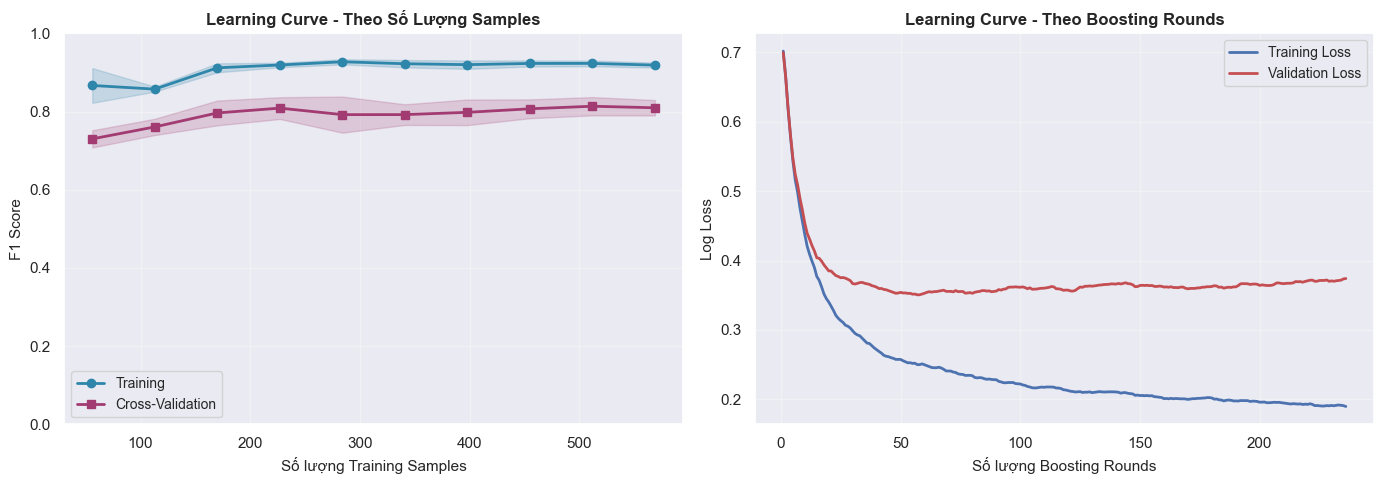


 Training F1: 0.9187 ± 0.0065
Validation F1: 0.8096 ± 0.0197
Chênh lệch: 0.1092
Best Epoch: 57 (Val Loss: 0.3506)


In [67]:
# Vẽ Learning Curve - Đường cong học tập (Ngắn gọn)
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

print("="*70)
print("LEARNING CURVE - ĐƯỜNG CONG HỌC TẬP")
print("="*70)

# ========== 1. Learning Curve theo số lượng samples ==========
lc_model = XGBClassifier(**final_params)
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes_abs, train_scores, val_scores = learning_curve(
    lc_model, X_train_full, y_train_full,
    train_sizes=train_sizes, cv=5, scoring='f1', n_jobs=-1, random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# ========== 2. Learning Curve theo boosting rounds ==========
# Tạo model riêng với eval_metric đầy đủ để lấy cả logloss và error
eval_model_params = final_params.copy()
eval_model_params['eval_metric'] = ['logloss', 'error']  # Thêm logloss và error

eval_model = XGBClassifier(**eval_model_params)
eval_model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_vl, y_vl)], verbose=False)

results = eval_model.evals_result()
# Lấy logloss từ results (có thể là 'logloss' hoặc 'validation_0/logloss')
train_loss = results['validation_0']['logloss']
val_loss = results['validation_1']['logloss']
epochs = range(1, len(train_loss) + 1)

# ========== Vẽ 2 biểu đồ chính ==========
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Biểu đồ 1: Learning Curve theo số lượng samples
ax1 = axes[0]
ax1.plot(train_sizes_abs, train_mean, 'o-', color='#2E86AB', label='Training', linewidth=2, markersize=6)
ax1.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.2, color='#2E86AB')
ax1.plot(train_sizes_abs, val_mean, 's-', color='#A23B72', label='Cross-Validation', linewidth=2, markersize=6)
ax1.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.2, color='#A23B72')
ax1.set_xlabel('Số lượng Training Samples', fontsize=11)
ax1.set_ylabel('F1 Score', fontsize=11)
ax1.set_title('Learning Curve - Theo Số Lượng Samples', fontsize=12, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Biểu đồ 2: Learning Curve theo boosting rounds
ax2 = axes[1]
ax2.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2)
ax2.plot(epochs, val_loss, 'r-', label='Validation Loss', linewidth=2)
ax2.set_xlabel('Số lượng Boosting Rounds', fontsize=11)
ax2.set_ylabel('Log Loss', fontsize=11)
ax2.set_title('Learning Curve - Theo Boosting Rounds', fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========== Thông tin tóm tắt ==========
print(f"\n Training F1: {train_mean[-1]:.4f} ± {train_std[-1]:.4f}")
print(f"Validation F1: {val_mean[-1]:.4f} ± {val_std[-1]:.4f}")
print(f"Chênh lệch: {abs(train_mean[-1] - val_mean[-1]):.4f}")
print(f"Best Epoch: {np.argmin(val_loss) + 1} (Val Loss: {min(val_loss):.4f})")